# Data Cruncher
This notebook includes the raw data and code for generating research figures on MoE communication overhead and one-sided communication exploratory work, specifically on NVSHMEM.

We start with necessary imports. Ensure to install missing packages via `pip`

In [2]:
import re
import bisect
import math

import numpy as np
from matplotlib import pyplot
from statsmodels.distributions.empirical_distribution import ECDF
from typing import List, Tuple, Callable, Dict
import locale
locale.setlocale(locale.LC_ALL, '')

'en_US.UTF-8'

## Data Loading
For a collective operation, below returns the min and max durations across concurrent executions on `num_gpus`

In [8]:
def get_collective_duration(data_file: str,
                            delimiter_regex: str,
                            gpus_per_node: int,
                            duration_index: int,
                            skip=1,
                            time_unit='ms') -> [list, list, float]:
    scaling_factor = 1  # us
    if time_unit == 'ms':
        scaling_factor = 1000
    elif time_unit == 's':
        scaling_factor = 1000 * 1000

    durations = open(data_file, "r")
    total_durations = []
    actual_durations = []
    max_delay = 0.0  # >= 0
    max_delay_index = 0
    p = re.compile(delimiter_regex)
    for _ in range(skip):
        durations.readline()  # skip header information

    line = durations.readline()

    j = 0
    while line:
        split_line = p.findall(line)
        duration = (float(split_line[duration_index - 1]) / scaling_factor)
        total = duration
        actual = duration

        line = durations.readline()

        for i in range(1, gpus_per_node):  # Obtain longest and shortest duration from concurrent executions
            split_line = p.findall(line)
            duration = (float(split_line[duration_index - 1]) / scaling_factor)  # microseconds to milliseconds
            total = max(duration, total)
            actual = min(actual, duration)
            line = durations.readline()

        if (total - actual) > max_delay:
            max_delay_index = j
            max_delay = (total - actual)
        total_durations.append(total)
        actual_durations.append(actual)
        j = j + 1
    return total_durations, actual_durations, max_delay_index

In [3]:
def single_plot(data_x: np.ndarray, data: list, header: str, x_title: str, out_name: str,
                color=None, y_title=None, labels=None, n_plots=None, stats=None, s_coords=None,
                x_lim_left=None, x_lim_right=None, y_lim_top=None, y_lim_bottom=None,
                plot_marker=None, sub_title=None, x_ticks=None, y_ticks=None,
                y_scale=None, y_scale_base=None, x_func_formatter:Callable=None,
                y_func_formatter:Callable=None, x_rotation=None, y_rotation=None,
                x_scale=None, x_scale_base=None,
                annotate_font_size=8, header_font_size=10, axis_font_size=8):
    fig, axs = pyplot.subplots(figsize=(6, 5), dpi=300)
    fig.suptitle(header, fontsize=header_font_size)
    if n_plots == 1:
        if plot_marker is not None:
            if labels is not None:
                axs.plot(data_x, data, marker=plot_marker, label=labels)
            else:
                axs.plot(data_x, data, marker=plot_marker, color='green')
        else:
            axs.plot(data_x, data, color='green')
    else:
        for i in range(n_plots):
            axs.plot(data_x[:len(data[i])], data[i], color[i], label=labels[i], marker=plot_marker)
    if stats is not None:
        bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
        axs.text(s_coords[0], s_coords[1], stats, fontsize=annotate_font_size, bbox=bbox,
                 transform=axs.transAxes, horizontalalignment='right')
    axs.set_xlabel(x_title, fontsize=axis_font_size)

    if y_title != "":
        axs.set_ylabel(y_title, fontsize=axis_font_size)

    if sub_title is not None:
        axs.set_title(sub_title, fontsize=header_font_size)

    if x_lim_left is not None:
        axs.set_xlim(left=x_lim_left, right=x_lim_right)

    if y_lim_top is not None:
        axs.set_ylim(top=y_lim_top, bottom=y_lim_bottom)

    if labels is not None:
        axs.legend(fontsize=axis_font_size)
    axs.grid()
    
    if x_ticks is not None:
        axs.set_xticks(data_x, x_ticks)
    
    if y_ticks is not None:
        axs.set_yticks(y_ticks)
    
    if y_scale is not None:
        if y_scale_base is None:
            y_scale_base = 2
        pyplot.yscale(y_scale, base=y_scale_base)
    
    if x_scale is not None:
        if x_scale_base is None:
            x_scale_base = 2
        pyplot.xscale(x_scale, base=x_scale_base)
    
    if x_func_formatter is not None:
        axs.xaxis.set_major_formatter(x_func_formatter)
    
    if y_func_formatter is not None:
        axs.yaxis.set_major_formatter(y_func_formatter)
    
    if x_rotation is not None:
        pyplot.xticks(rotation=x_rotation, ha='right')
    
    if y_rotation is not None:
        pyplot.yticks(rotation=y_rotation, ha='right')
    
    pyplot.xticks(fontsize=axis_font_size)
    pyplot.yticks(fontsize=axis_font_size)
    fig.tight_layout()
    pyplot.savefig(out_name)
    pyplot.show()

In [10]:
def get_kernel_percentages(data_file: str, 
                           delimiter_regex: str, metadata: dict, skip=0) -> tuple[list, list]:
    percentages = []
    for _ in range(len(metadata)):
        percentages.append(0.0)

    summary = open(data_file, "r")
    p = re.compile(delimiter_regex)

    for _ in range(skip):
        summary.readline()

    line = summary.readline()
    non_misc_percentages = 0
    while line:
        split_summary = p.findall(line) # locale.atof('23.5')
        time_percent = float(split_summary[0])

        if time_percent > 0.0:
            for i in range(10, len(split_summary)):
                stop_search = False
                j = 0
                # This is correct since dict remembers insertion order per https://stackoverflow.com/a/39980744
                for kernel_pattern in metadata.keys():
                    val = split_summary[i]
                    if re.match(kernel_pattern, val):
                        percentages[j] = percentages[j] + time_percent
                        non_misc_percentages = non_misc_percentages + time_percent
                        stop_search = True
                        break
                    j = j + 1
                if stop_search:
                    print(line)
                    break

        line = summary.readline()

    kernel_groups = list(metadata.values())
    kernel_groups.append("Misc")
    percentages.append(100.0 - non_misc_percentages)

    return kernel_groups, percentages

In [11]:
def get_kernel_time_breakdown(data_file: str, 
                           delimiter_regex: str, metadata: dict, skip=0) -> Dict[str, float]:
    breakdown = {}

    summary = open(data_file, "r")
    p = re.compile(delimiter_regex)

    for _ in range(skip):
        summary.readline()

    line = summary.readline()
    while line:
        split_summary = p.findall(line) # locale.atof('23.5')
        time_percent = locale.atof(split_summary[0])

        if time_percent > 0.0:
            key = split_summary[-1]
            for kernel_pattern in zip(metadata.keys(), metadata.values()):
                if re.match(kernel_pattern[1], key):
                    breakdown.update({kernel_pattern[0]: (time_percent + breakdown.get(kernel_pattern[0], 0.0))})
                    break
            
        line = summary.readline()
    return breakdown

In [12]:
def get_kernel_breakdown(data_file: str, delimiter_regex: str, 
                         cutoff: float, skip=0, misc_index=-1) -> list:
    percentages = []

    summary = open(data_file, "r")
    p = re.compile(delimiter_regex)

    for _ in range(skip):
        summary.readline()

    line = summary.readline()
    non_misc_percentages = 0
    
    split_summary = p.findall(line)
    time_percent = float(split_summary[0])
    
    while time_percent >= cutoff:
        non_misc_percentages = non_misc_percentages + time_percent
        percentages.append(time_percent)
        
        line = summary.readline()
        split_summary = p.findall(line)
        time_percent = float(split_summary[0])
    
    percentages.insert(misc_index, 100.0 - non_misc_percentages)
    
    return percentages

In [36]:
# Adapted from https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def plot_donut_chart(description: list, data: list, title: str, out_name:str, y_size=3, 
                     title_fontsize=14, ann_font_size=16, sup_title=None, s_font_size=14) -> None:
    fig, ax = pyplot.subplots(figsize=(6, y_size), subplot_kw=dict(aspect="equal"), dpi=300)
    if sup_title is not None:
        fig.suptitle(sup_title, fontsize=s_font_size)
    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="->"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate('{}: {:.1f}%'.format(description[i], data[i]), xy=(x, y), 
                    xytext=(1.35 * np.sign(x), 1.4 * y),
                    horizontalalignment=horizontalalignment, fontsize=ann_font_size, **kw)

    ax.set_title(title, fontweight='bold', fontsize=title_fontsize)
    pyplot.savefig(out_name, format= 'pdf', bbox_inches='tight')
    pyplot.show()

In [33]:
def gen_batch_collective_duration(data_files: list,
                                  delimiter_regex: str,
                                  gpus_per_node: list,
                                  duration_index: int,
                                  skips=None,
                                  time_unit='ms') -> list:
    if skips is None:
        skips = [0, 0, 0]
    batch = []
    for filename, n_gpus, skip in zip(data_files, gpus_per_node, skips):
        t_dur, a_dur, max_i = get_collective_duration(data_file=filename,
                                                      delimiter_regex=delimiter_regex,
                                                      gpus_per_node=n_gpus,
                                                      duration_index=duration_index,
                                                      skip=skip,
                                                      time_unit=time_unit)
        batch.append((t_dur, a_dur, max_i))
    return batch


def plot_straggler_delays(dataset: list, output_names: list, file_prefix="", addenda=None, 
                          x_left=None, x_right=None, plot_marker=None) -> None:
    if addenda is None:
        addenda = []
        for _ in range(len(dataset)):
            addenda.append("")

    plot_stats = []
    coord = [(0.7, 0.5), (0.9, 0.85), (0.7, 0.65)]
    dur_unit = 'ms'

    for row in dataset:
        m_idx = row[2]
        plot_stats.append((f'max delay = {(row[0][m_idx] - row[1][m_idx]): .2f} ' + dur_unit + 
                           f'\n avg actual = {np.array(row[1]).mean(): .2f}' + dur_unit))

    for i in range(len(dataset)):
        output_name = "{}{}.pdf".format(file_prefix, re.sub(r'\s+', "_", output_names[i]))
        data_x = np.linspace(1, len(dataset[i][0]), num=len(dataset[i][0]), dtype=int)

        single_plot(data_x, [dataset[i][0], dataset[i][1]],
                    header="{} All-to-All Straggler Effect: {}".format(output_names[i], addenda[i]),
                    labels=["Total Time", "Actual Time"], stats=plot_stats[i], s_coords=coord[i], 
                    color=['tab:red', 'tab:green'],
                    out_name=output_name, y_title="Time ({})".format(dur_unit),
                    x_title="All-to-All Steps", n_plots=2, sub_title="Raw Distribution", 
                    x_lim_left=x_left, x_lim_right=x_right, plot_marker=plot_marker,
                    annotate_font_size=14, axis_font_size=14, header_font_size=14)


def plot_ecdf(dataset: list, output_names: list, file_prefix="", addenda=None) -> None:
    for i in range(len(dataset)):
        t_durs = np.array(dataset[i][0])
        a_durs = np.array(dataset[i][1])
        ecdf = ECDF((t_durs - a_durs))
        median_cdf = bisect.bisect_left(ecdf.y, 0.5)
        p_95_cdf = bisect.bisect_left(ecdf.y, 0.95)
        x_unit = 'ms'
        filtered_data = [v for v in ecdf.x if not math.isnan(v) and not math.isinf(v)]
        
        stats = (f'$\mu$ = {np.array(filtered_data).mean():.2f}{x_unit}\n'
             f'$median$ = {ecdf.x[median_cdf]:.2f}{x_unit}\n'
                 f'$P95$ = {ecdf.x[p_95_cdf]:.2f}{x_unit}')
        
        output_name = "{}{}_ecdf.pdf".format(file_prefix, re.sub(r'\s+', "_", output_names[i]))
        single_plot(ecdf.x, ecdf.y,
                    header="{} All-to-All Straggler Effect: {}".format(output_names[i], addenda[i]),
                    color='tab:green', out_name=output_name, 
                    x_title="Delay ({})".format(x_unit), n_plots=1, sub_title="ECDF", 
                    stats=stats, s_coords=(0.7, 0.5), axis_font_size=14, header_font_size=14, annotate_font_size=14)

In [8]:
values = get_kernel_breakdown("data/single/single_1x8_filtered_sum.txt", r"(\d+\.?\d+|[^\W_]+)", 
                              cutoff=6, skip=6, misc_index=0)
print(values)
# Manually obtained below from ./data/single_1x8_filtered_sum.txt
kernel_types = ["miscellaneous", "volta_128x128_s884", 
                "apex_fused_dropout", "cutlass_fused_relu_256", 
                "volta_s884_64x128_tn", "volta_s884_64x128_nn", 
                "nccl_All-to-All", "cutlass_fused_relu_128"]

[49.2, 10.2, 7.9, 6.8, 6.7, 6.5, 6.4, 6.3]


## Communication Overhead: Figure 1

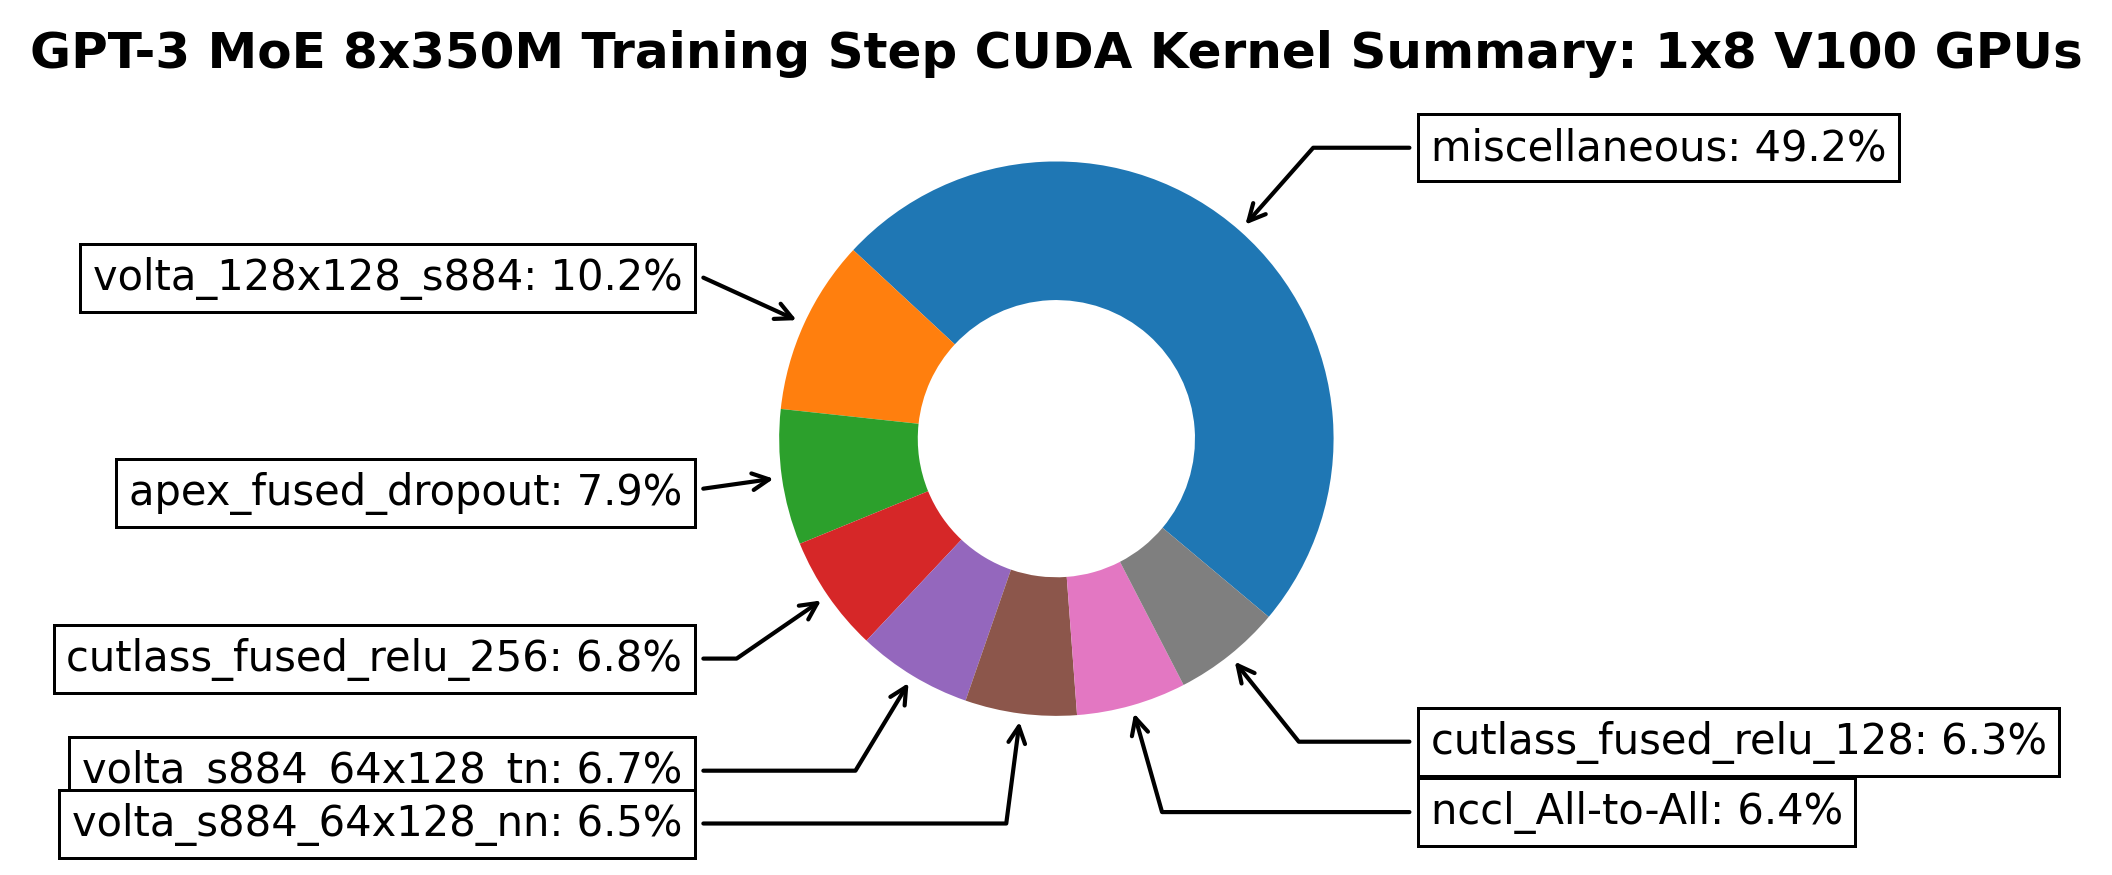

In [9]:
plot_donut_chart(kernel_types, values, 
                 "GPT-3 MoE 8x350M Training Step CUDA Kernel Summary: 1x8 V100 GPUs", 
                 "figures/single_trace_1x8_donut.pdf", y_size=3)

In [10]:
m_values = get_kernel_breakdown("data/multi/multi_8x4_1.3B_sum.txt", r"(\d+\.?\d+|[^\W_]+)", 
                                cutoff=5, skip=6, misc_index=0)
print(m_values)

m_kernel_types = ["miscellaneous", "nccl_All-to-All", 
                  "ampere_s16816_128x128_tn", "ampere_s16816_256x128", 
                  "ampere_s16816_128x128_nt", "ampere_s16816_128x256_tn", 
                  "ampere_s1688_256x128_tn", "apex_fused_dropout"]

[44.7, 14.7, 11.4, 9.7, 9.3, 5.2, 5.0]


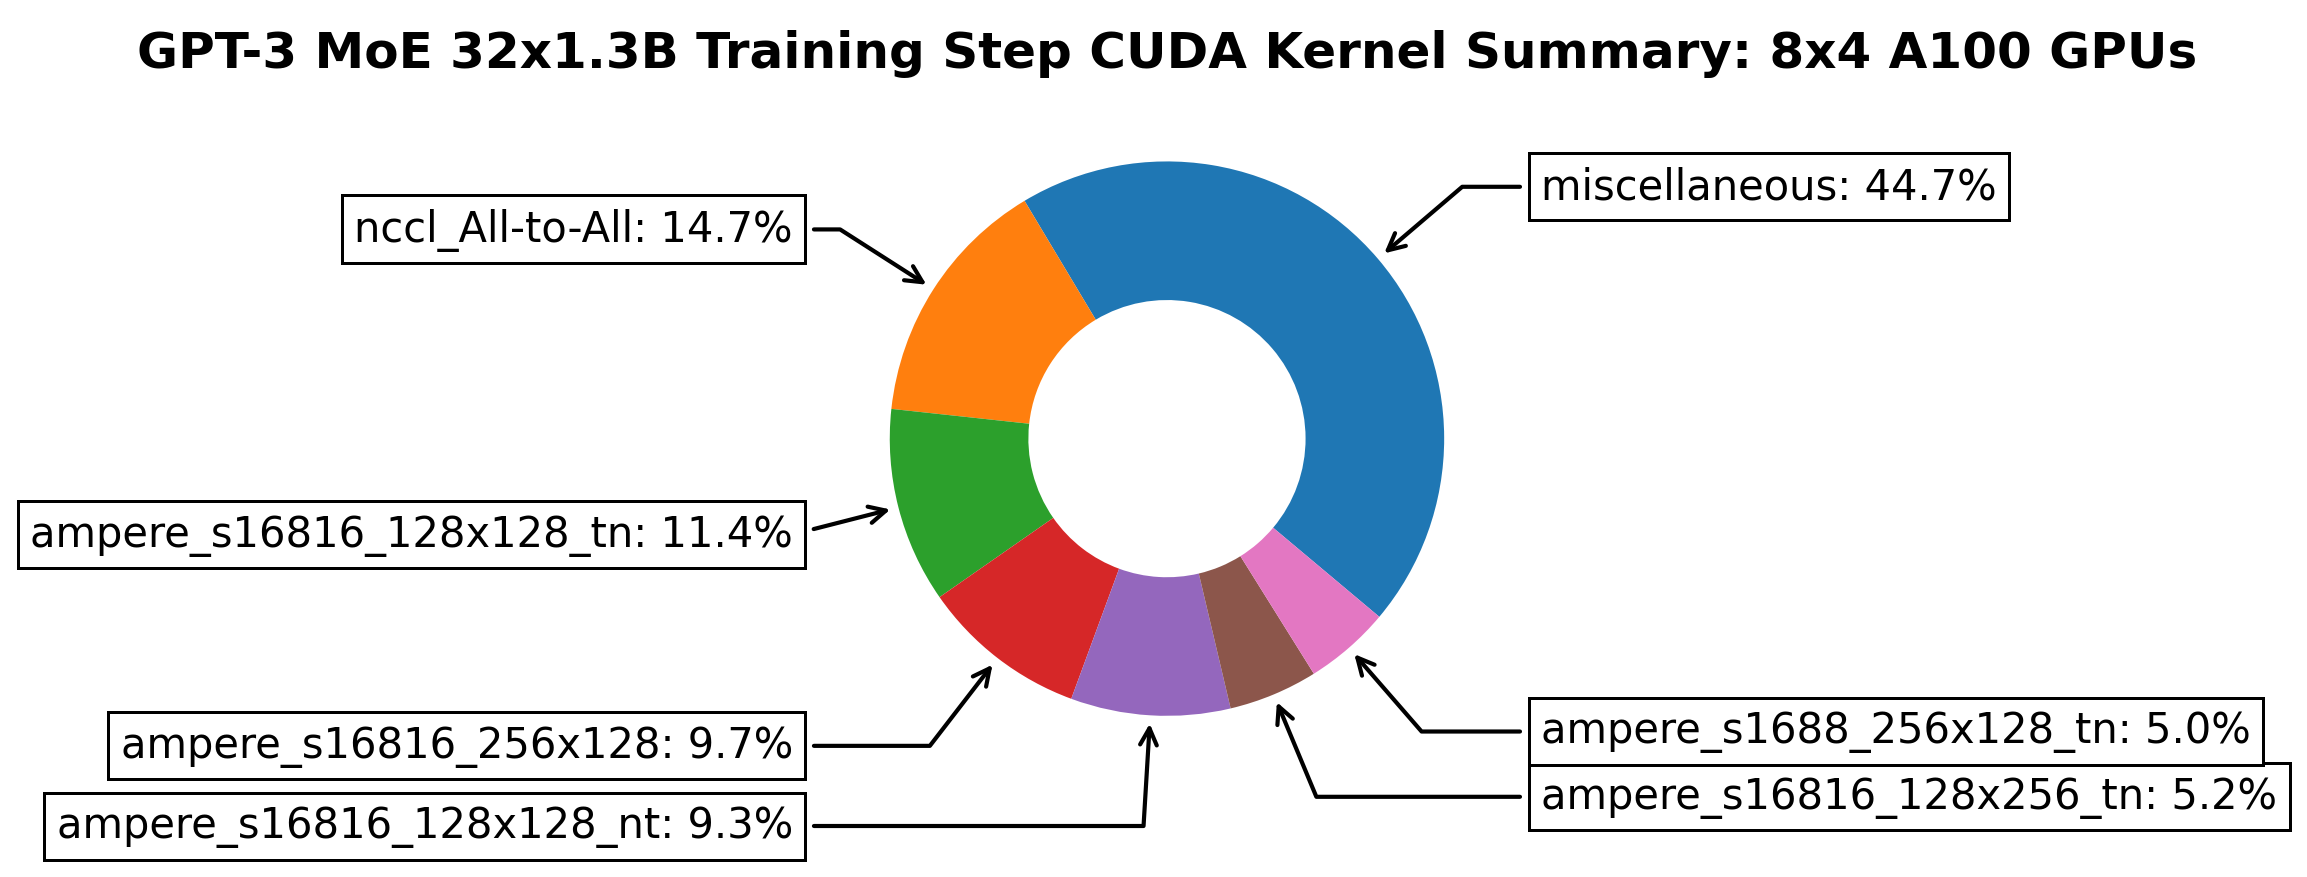

In [11]:
plot_donut_chart(m_kernel_types, m_values, 
                 "GPT-3 MoE 32x1.3B Training Step CUDA Kernel Summary: 8x4 A100 GPUs", 
                 "figures/multi_sum_8x4_1.3B_donut.pdf", y_size=3)

In [12]:
m_t_values = get_kernel_breakdown("data/multi/multi_8x4_350M_sum.txt", r"(\d+\.?\d+|[^\W_]+)", 
                                  cutoff=4, skip=6, misc_index=0)
print(m_t_values)

m_t_kernel_types = ["miscellaneous", "nccl_All-to-All", 
                    "apex_fused_dropout", "ampere_s1688gemm_256x64_tn",
                    "tensor_scan_outer_dim", "ampere_s16816gemm_128x128_nt", 
                    "apex_softmax", "ampere_s16816gemm_128x128_nn", 
                    "ampere_s16816gemm_64x128_nn", "cutlass_fused_relu_256x128_tn"]

[44.599999999999994, 13.1, 7.0, 7.0, 6.0, 4.7, 4.6, 4.5, 4.3, 4.2]


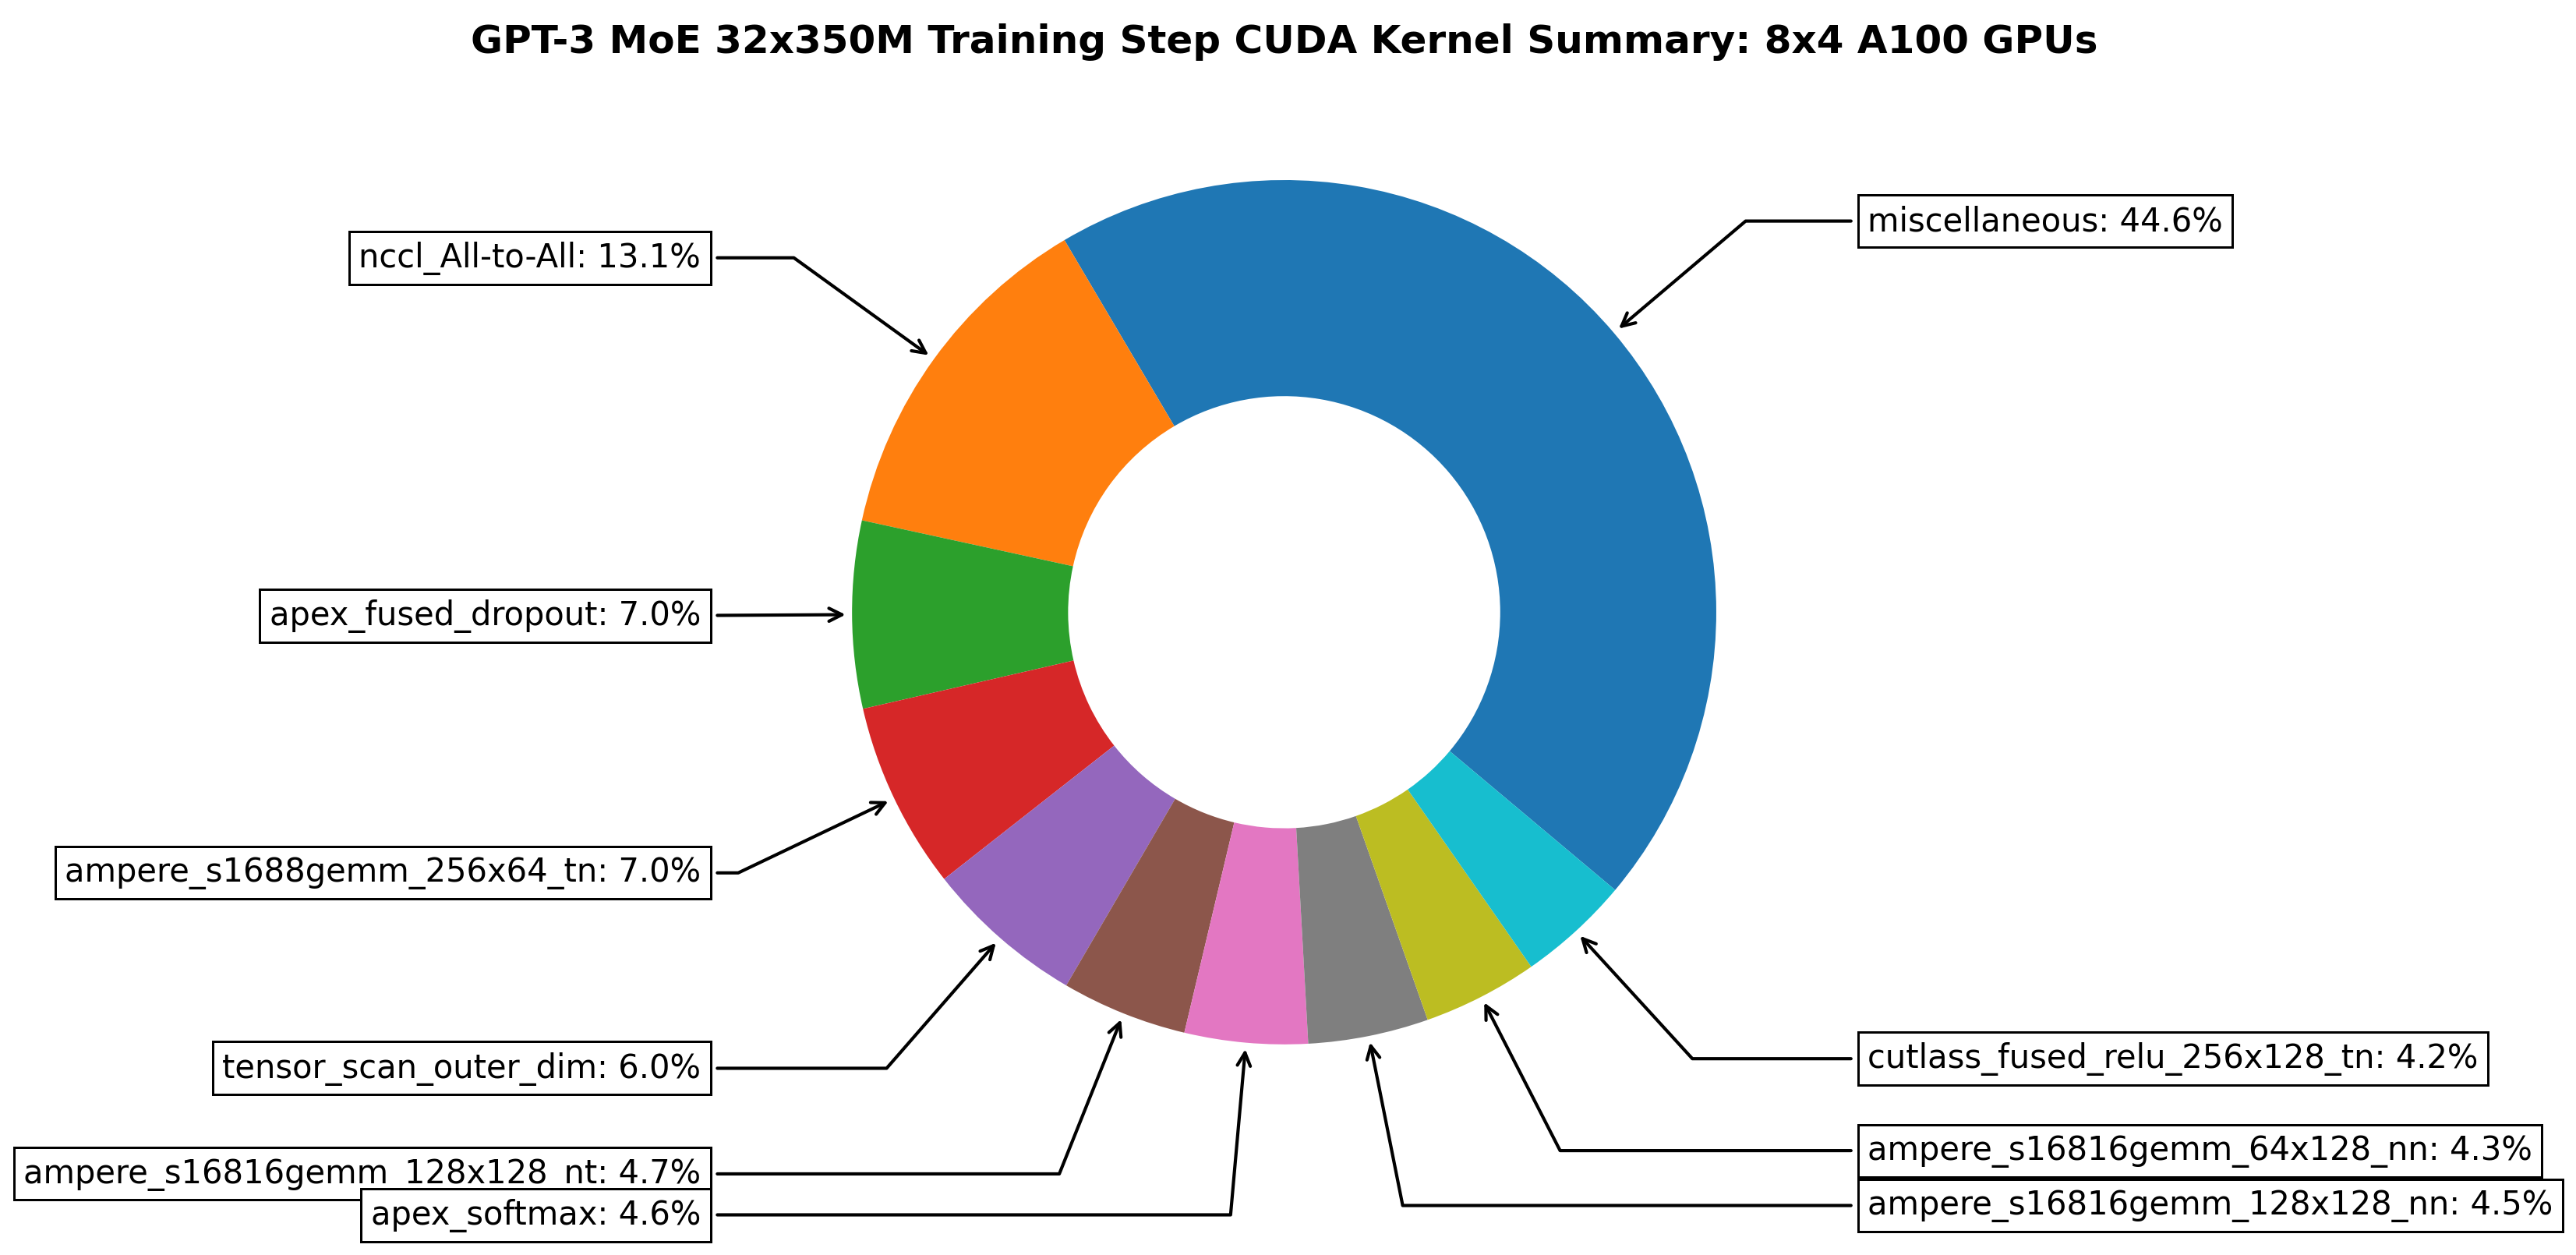

In [13]:
plot_donut_chart(m_t_kernel_types, m_t_values, 
                 "GPT-3 MoE 32x350M Training Step CUDA Kernel Summary: 8x4 A100 GPUs", 
                 "figures/multi_sum_8x4_350M_donut.pdf", y_size=6)

## Forward Pass Kernel Breakdown
The data below is *manually* derived from [this file](data/breakdown_2B/2.7B_forw_2x4_f_MoE.txt) and its corresponding `*.nsys-rep` file.

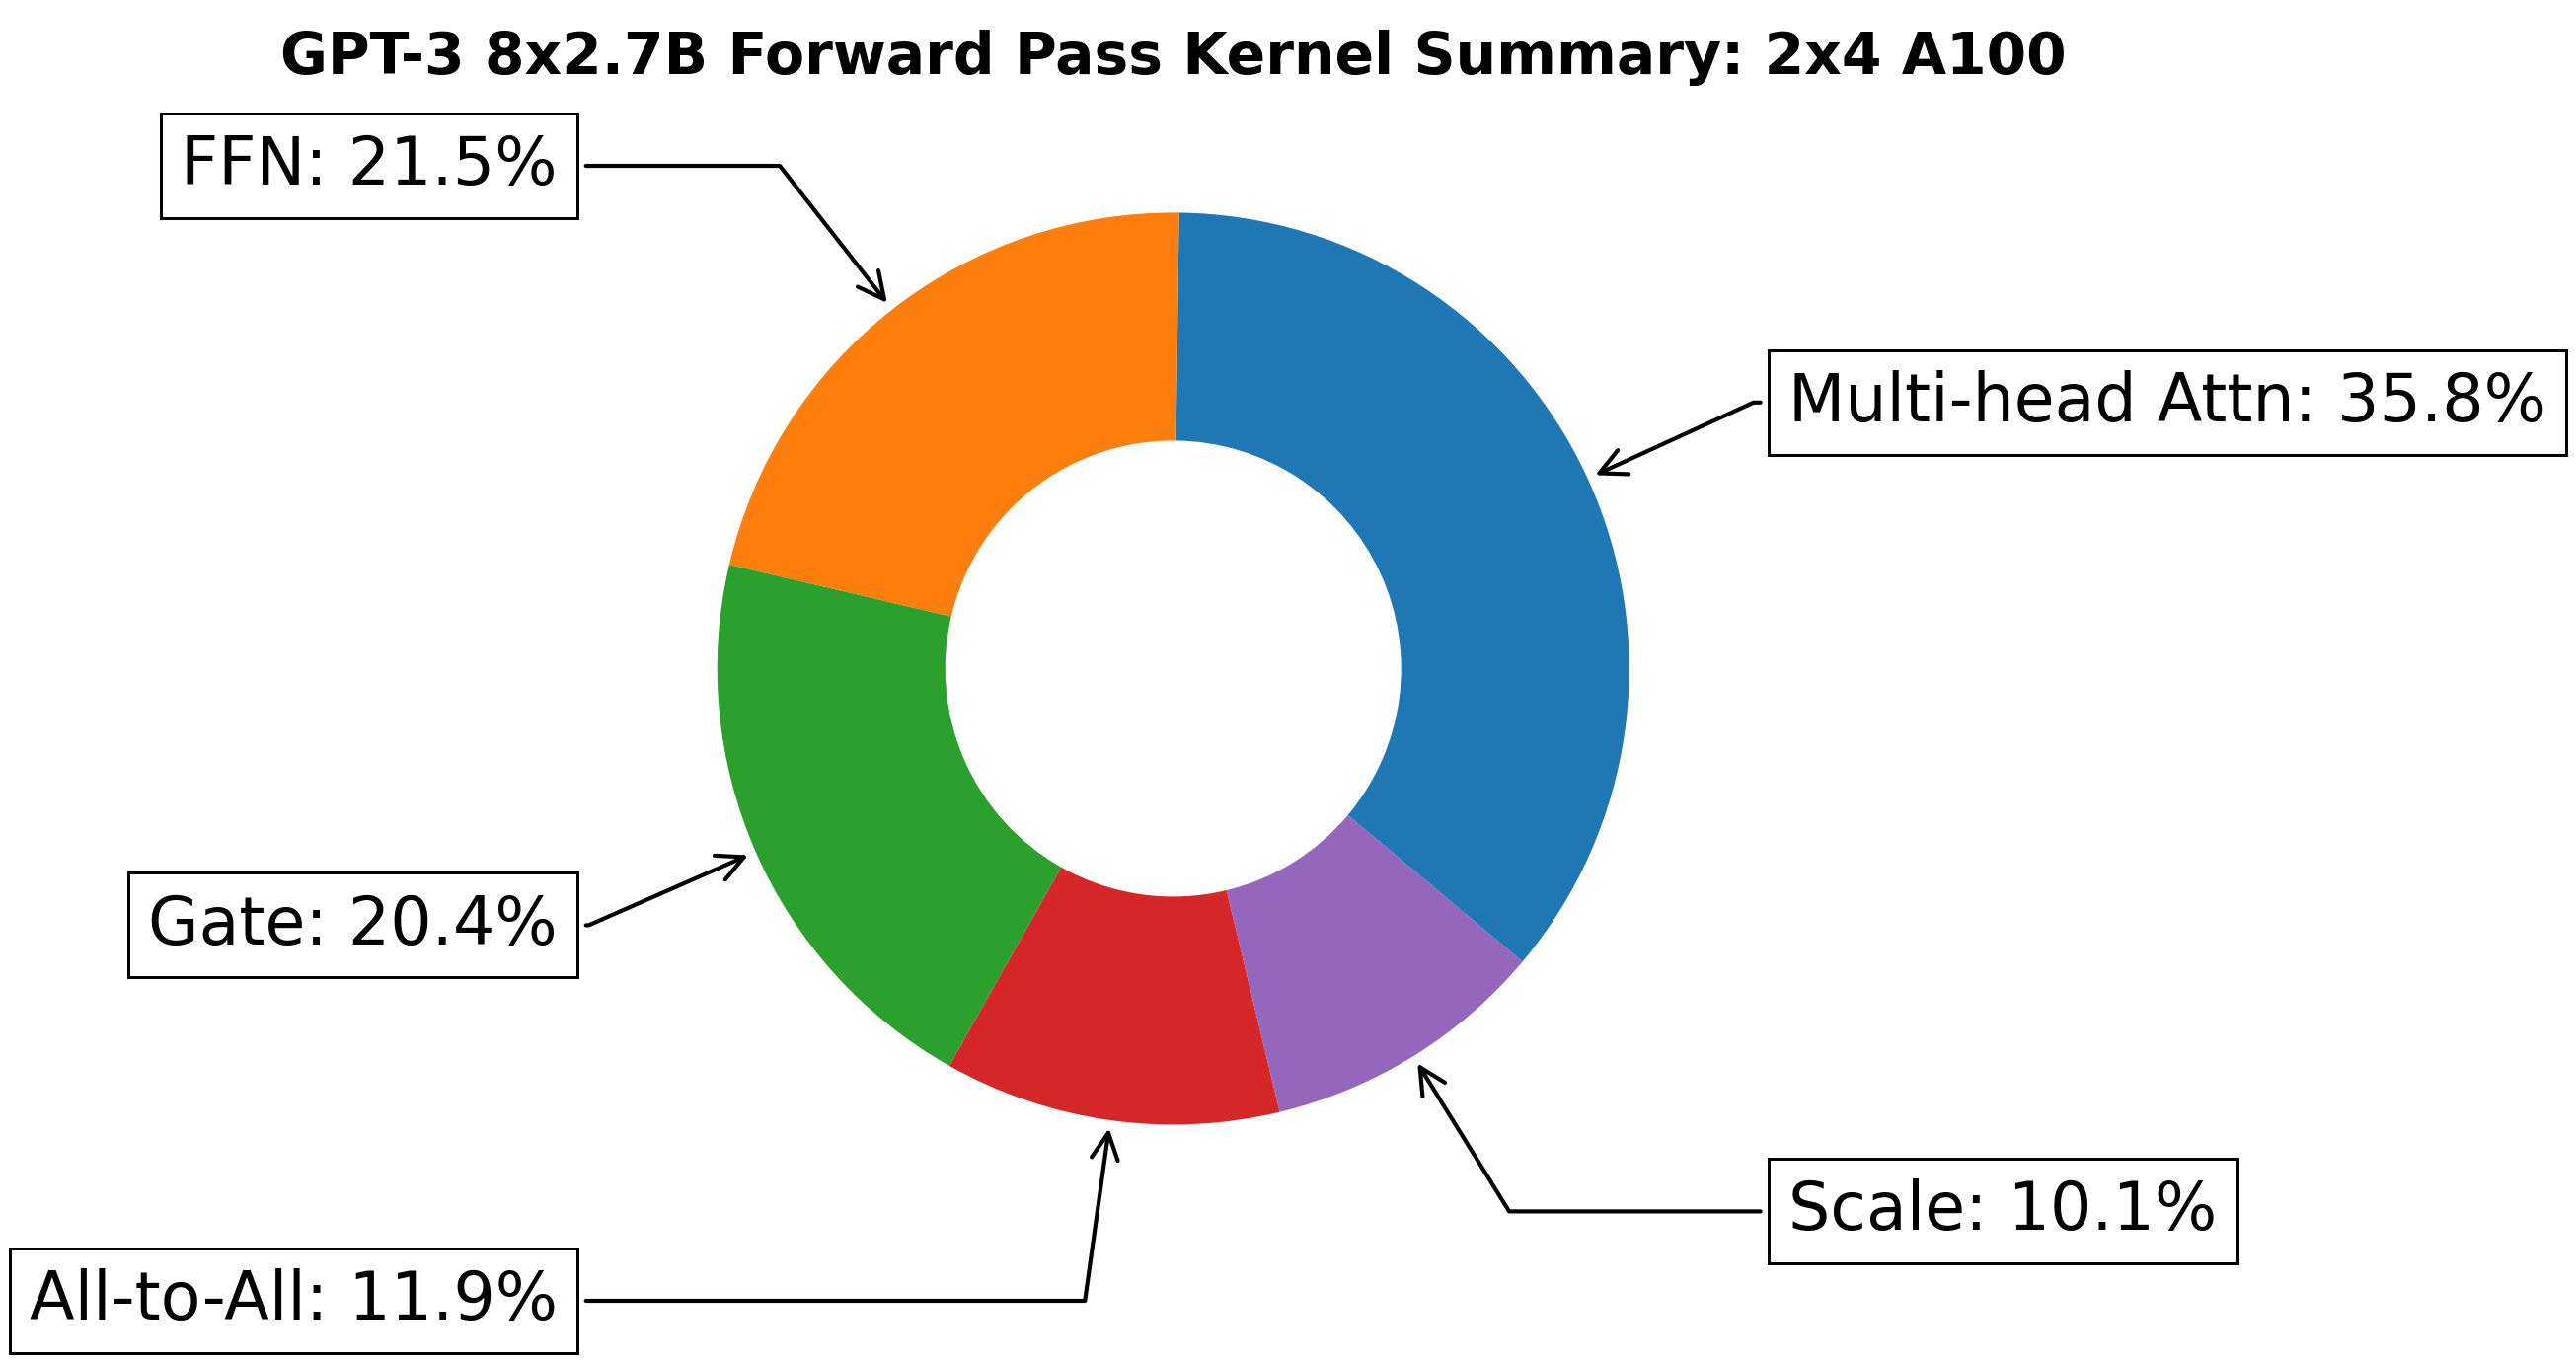

In [58]:
kernel_desc = {"Multi-head Attn": 35.837,
               "FFN": 21.5,
               "Gate": 20.45,
               "All-to-All": 11.9,
               "Scale": 10.116}
plot_donut_chart(list(kernel_desc.keys()), list(kernel_desc.values()),
                 "GPT-3 8x2.7B Forward Pass Kernel Summary: 2x4 A100",
                 "figures/multi_sum_2x4_2.7B_donut.pdf", y_size=5)

In [29]:
print(list(kernel_desc.values()))

[35.837, 20.45, 21.5, 11.9, 10.116]


## Straggler Effect: Figure 2

In [25]:
delim = r"(\d+\.?\d+)"
delays_dataset = gen_batch_collective_duration(data_files=["data/single/single_1x8_350M_trace.txt",
                                                           "data/multi/multi_8x4_1.3B_trace.txt",
                                                           "data/multi/multi_8x4_350M_trace.txt"],
                                               delimiter_regex=delim,
                                               gpus_per_node=[8, 4, 4],
                                               duration_index=2,
                                               skips=[2, 2, 3],
                                               time_unit='ms')

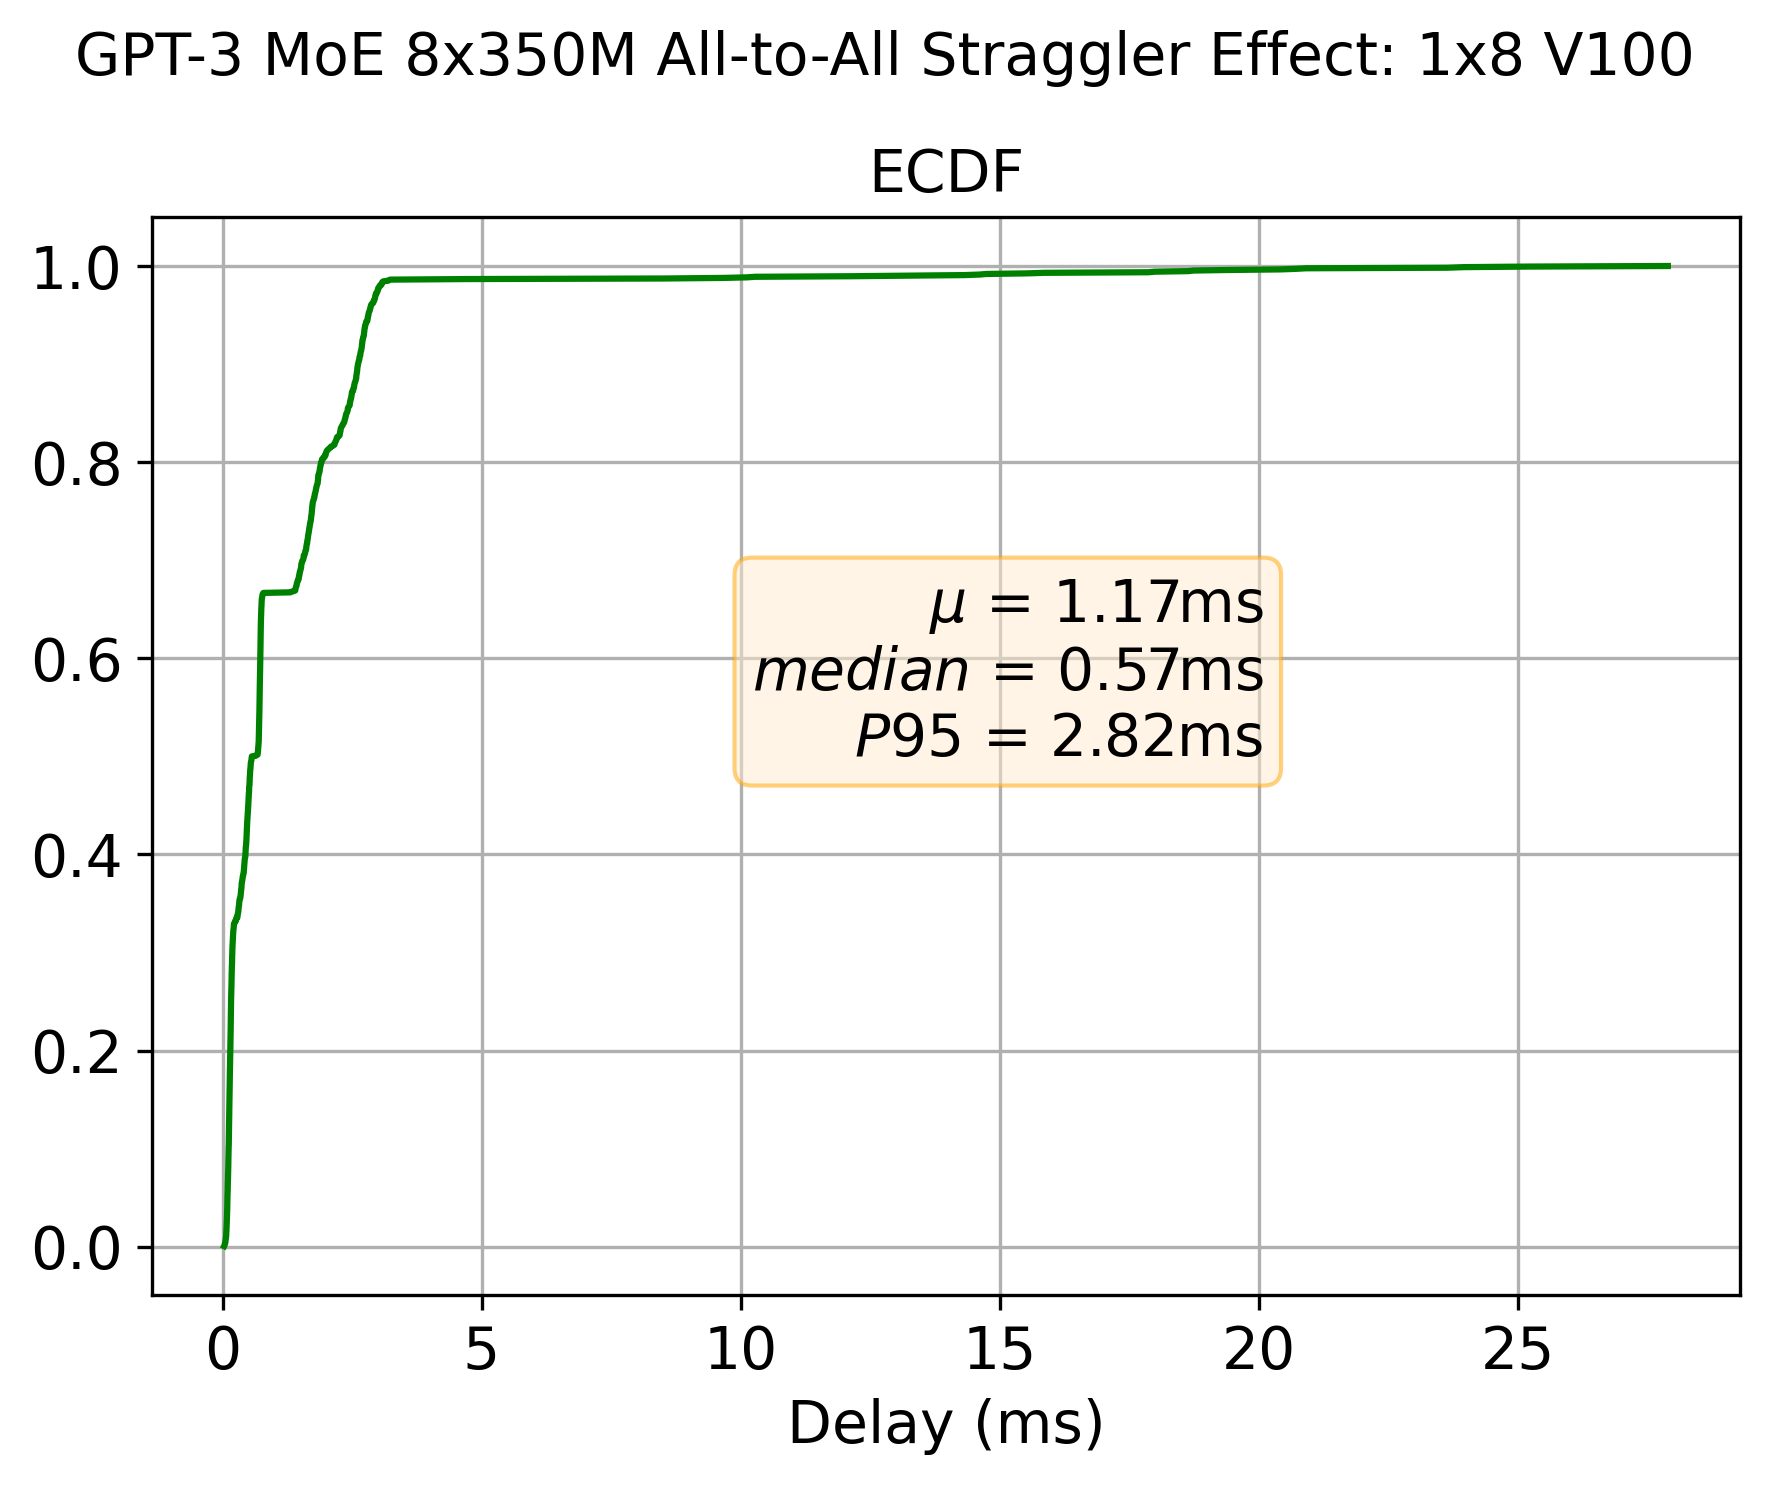

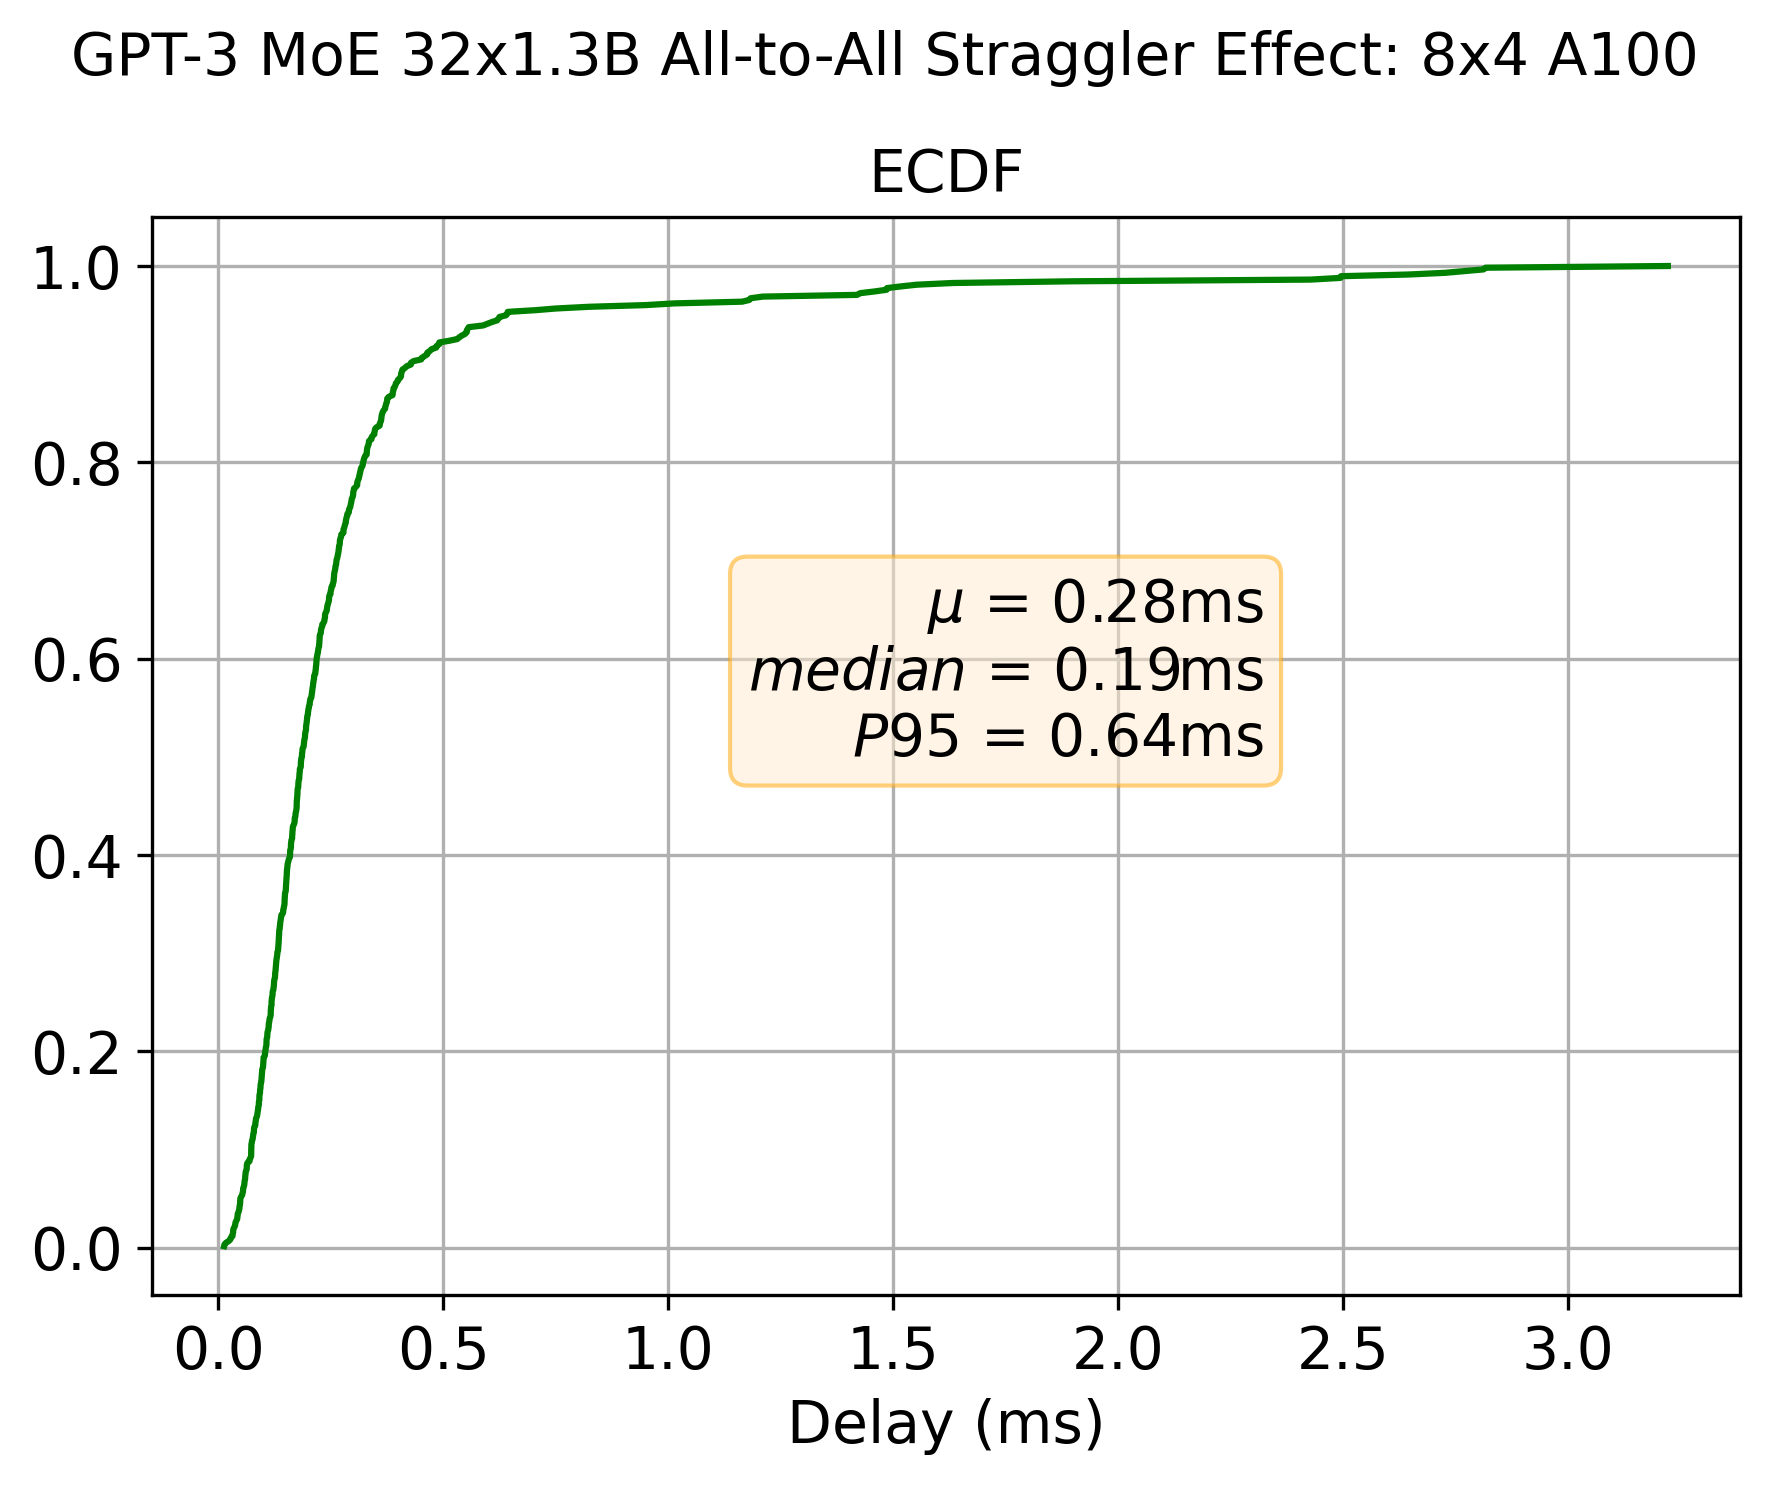

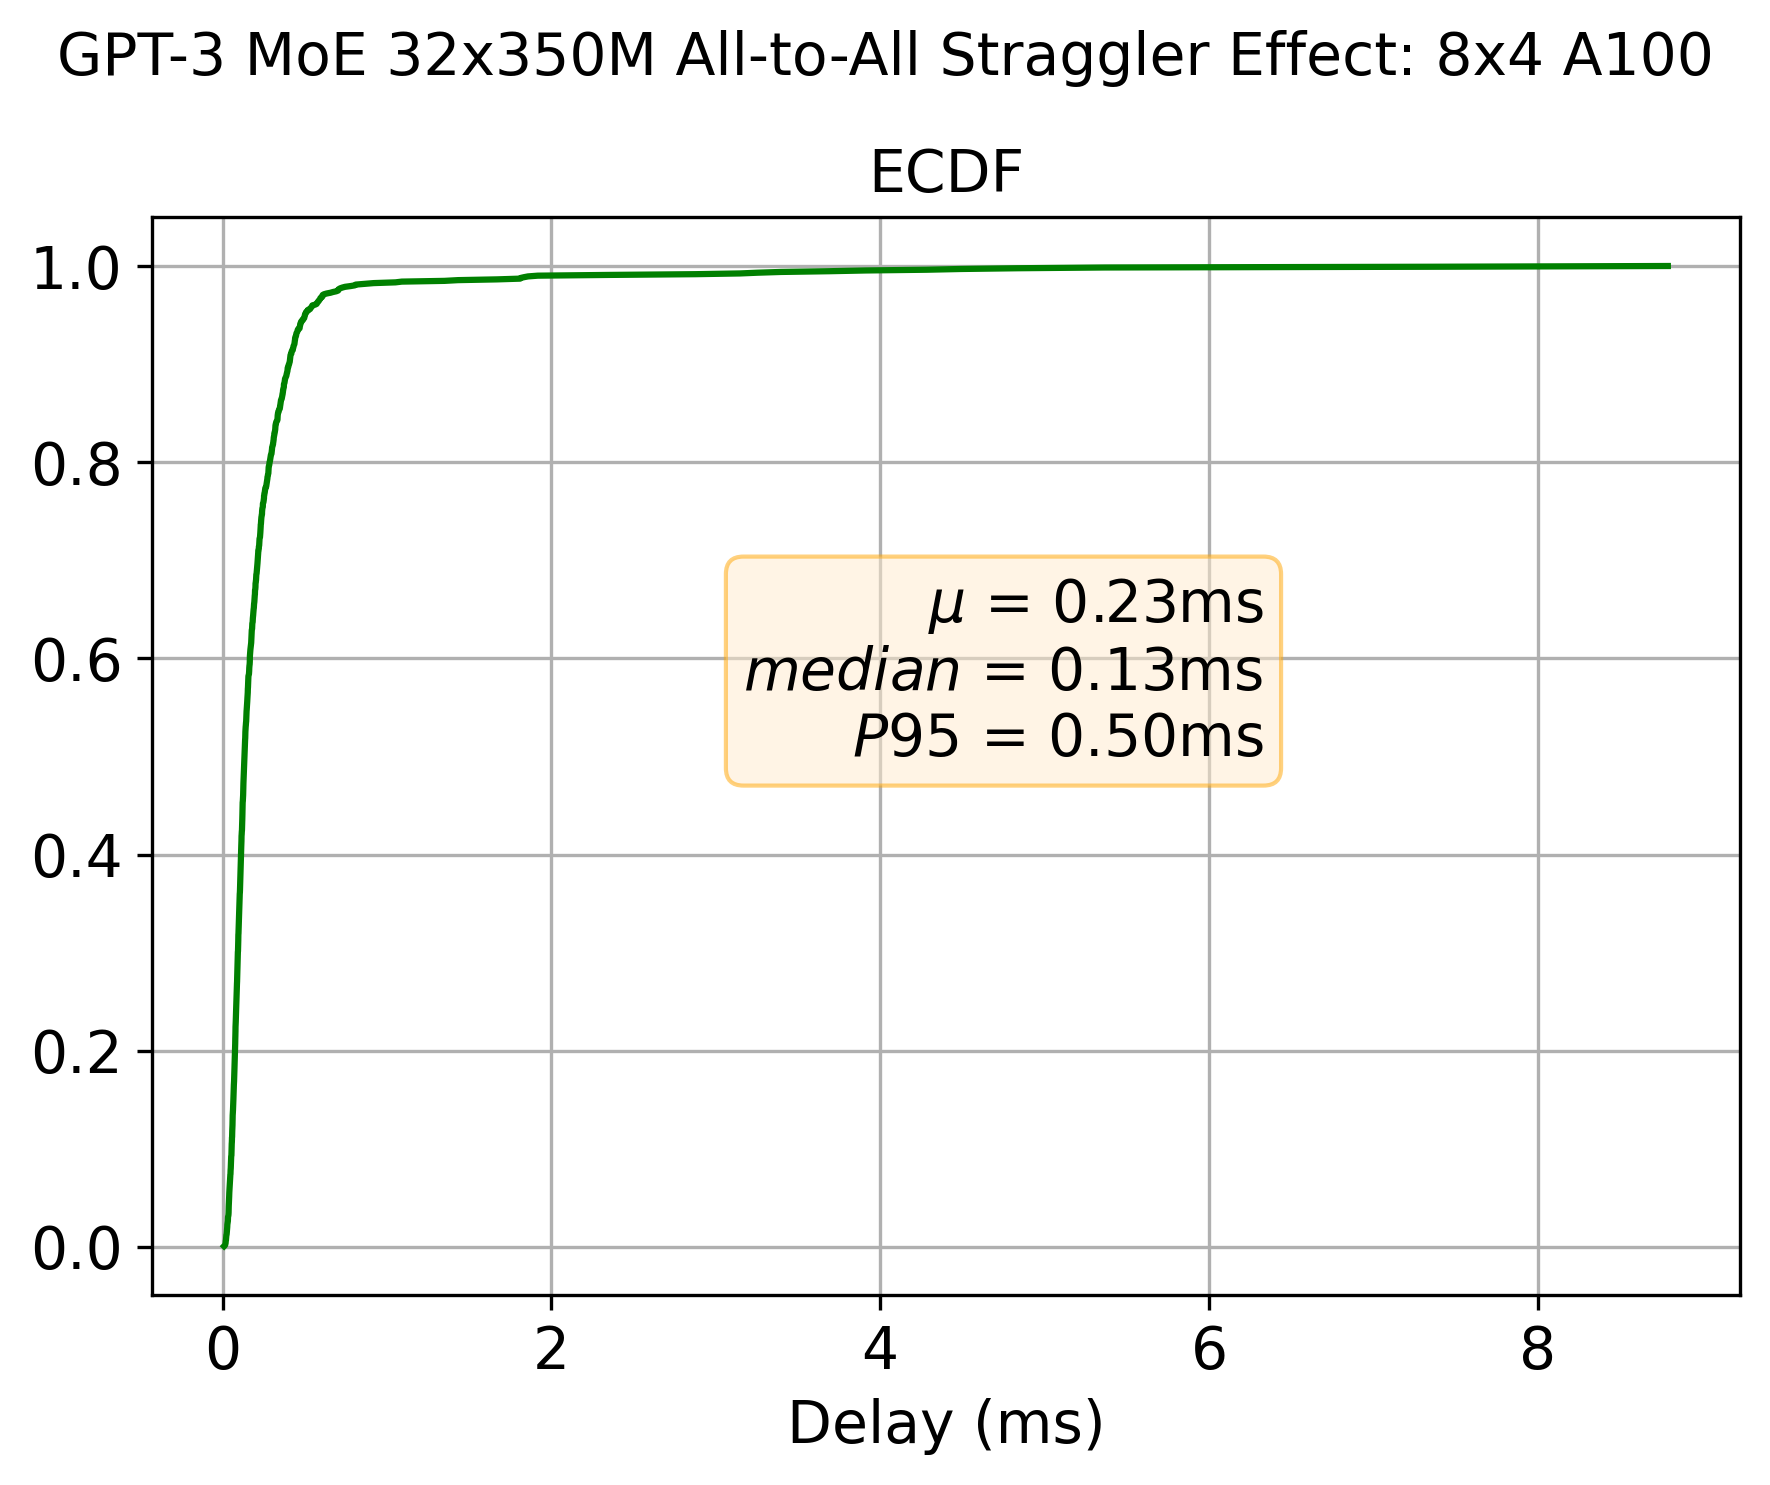

In [34]:
plot_ecdf(delays_dataset,
              output_names=["GPT-3 MoE 8x350M", "GPT-3 MoE 32x1.3B", "GPT-3 MoE 32x350M"],
              file_prefix='figures/',
              addenda=["1x8 V100", "8x4 A100", "8x4 A100"])

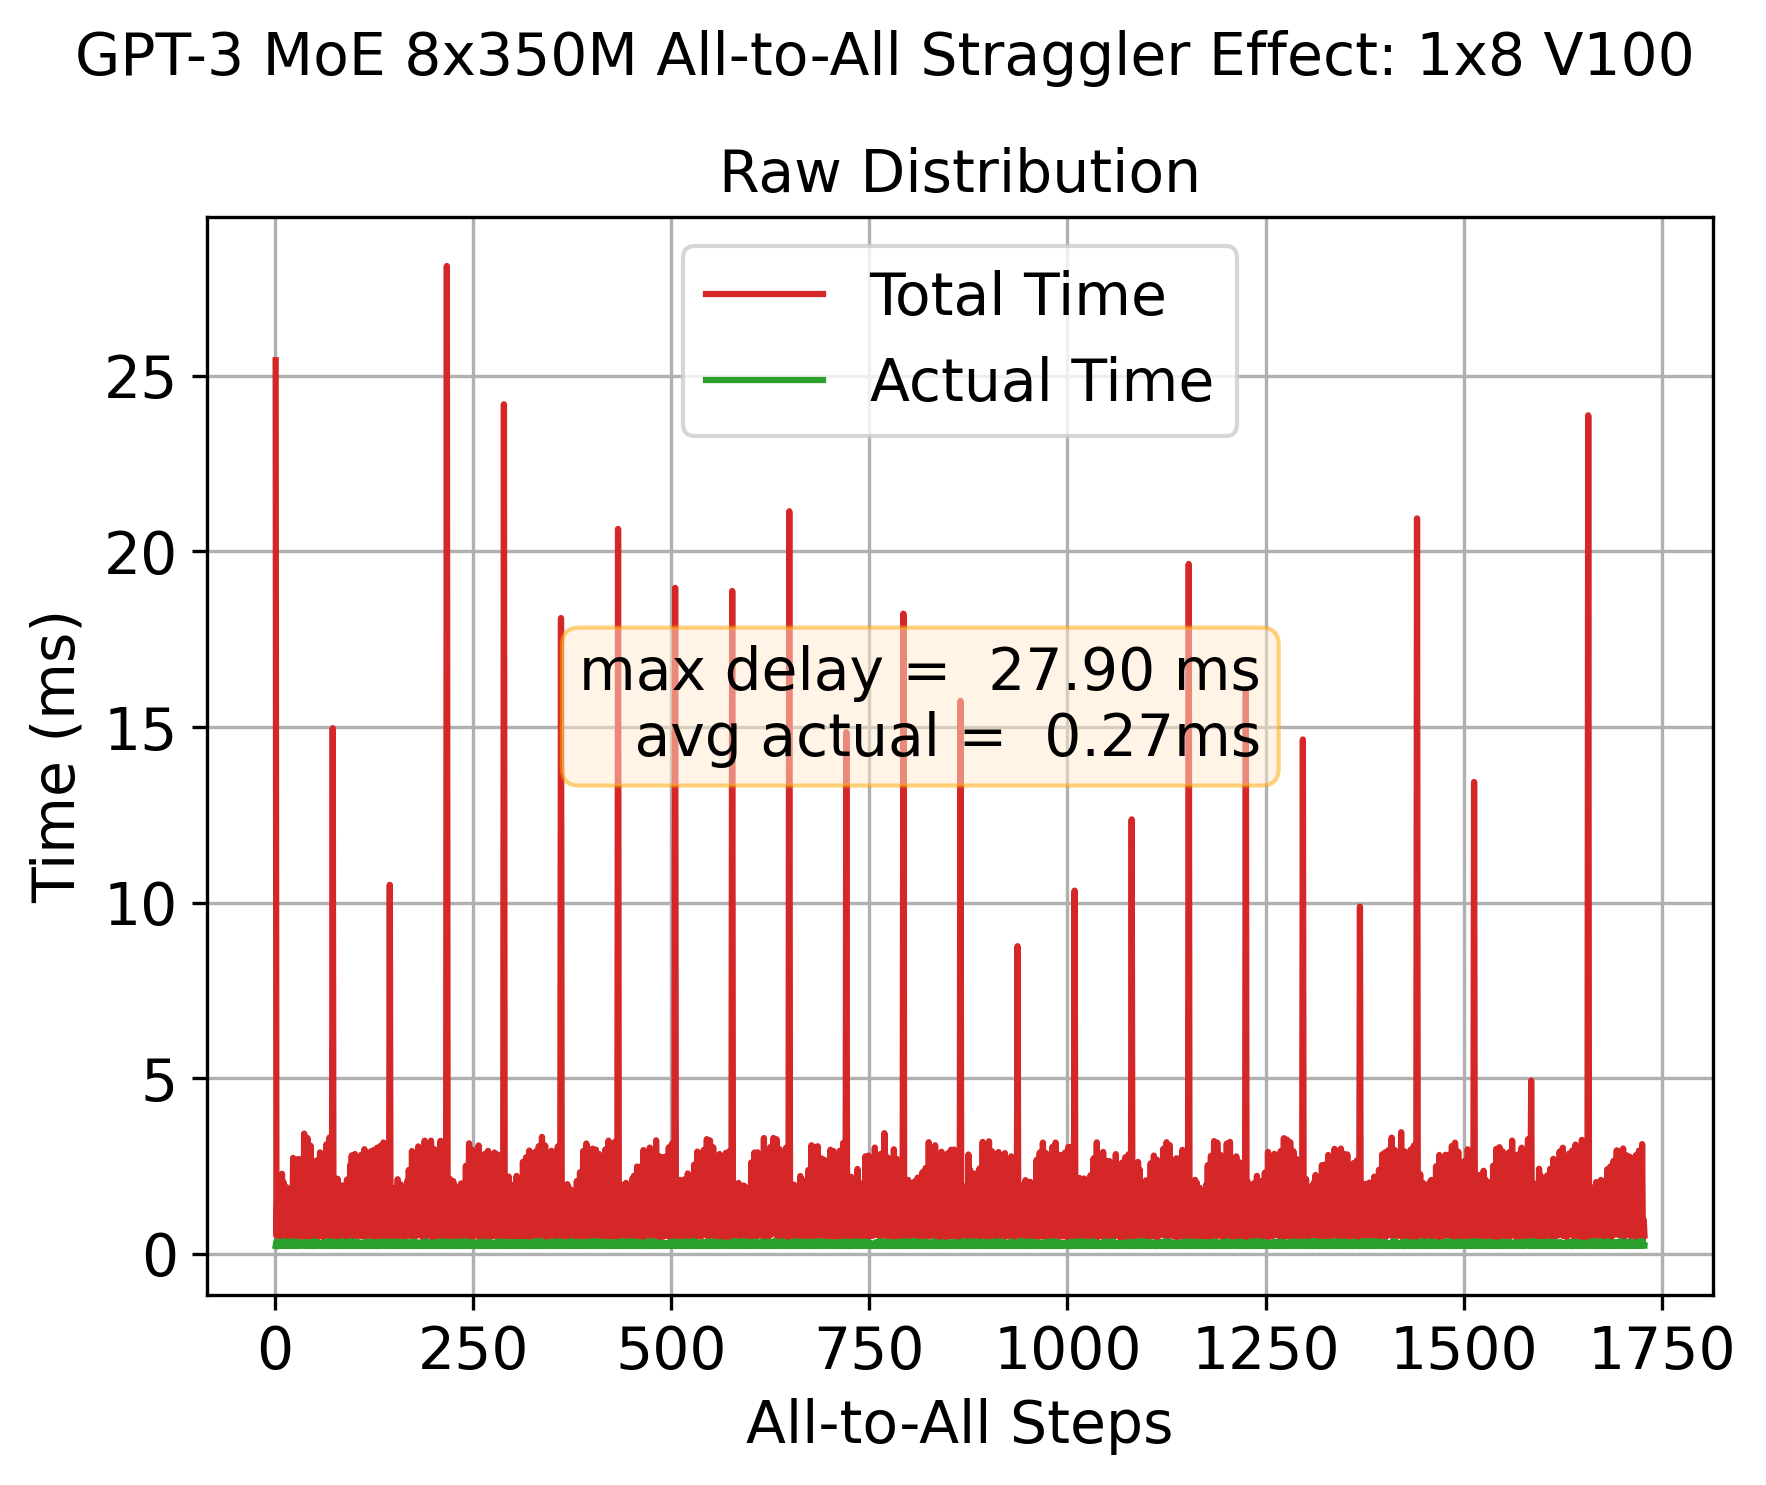

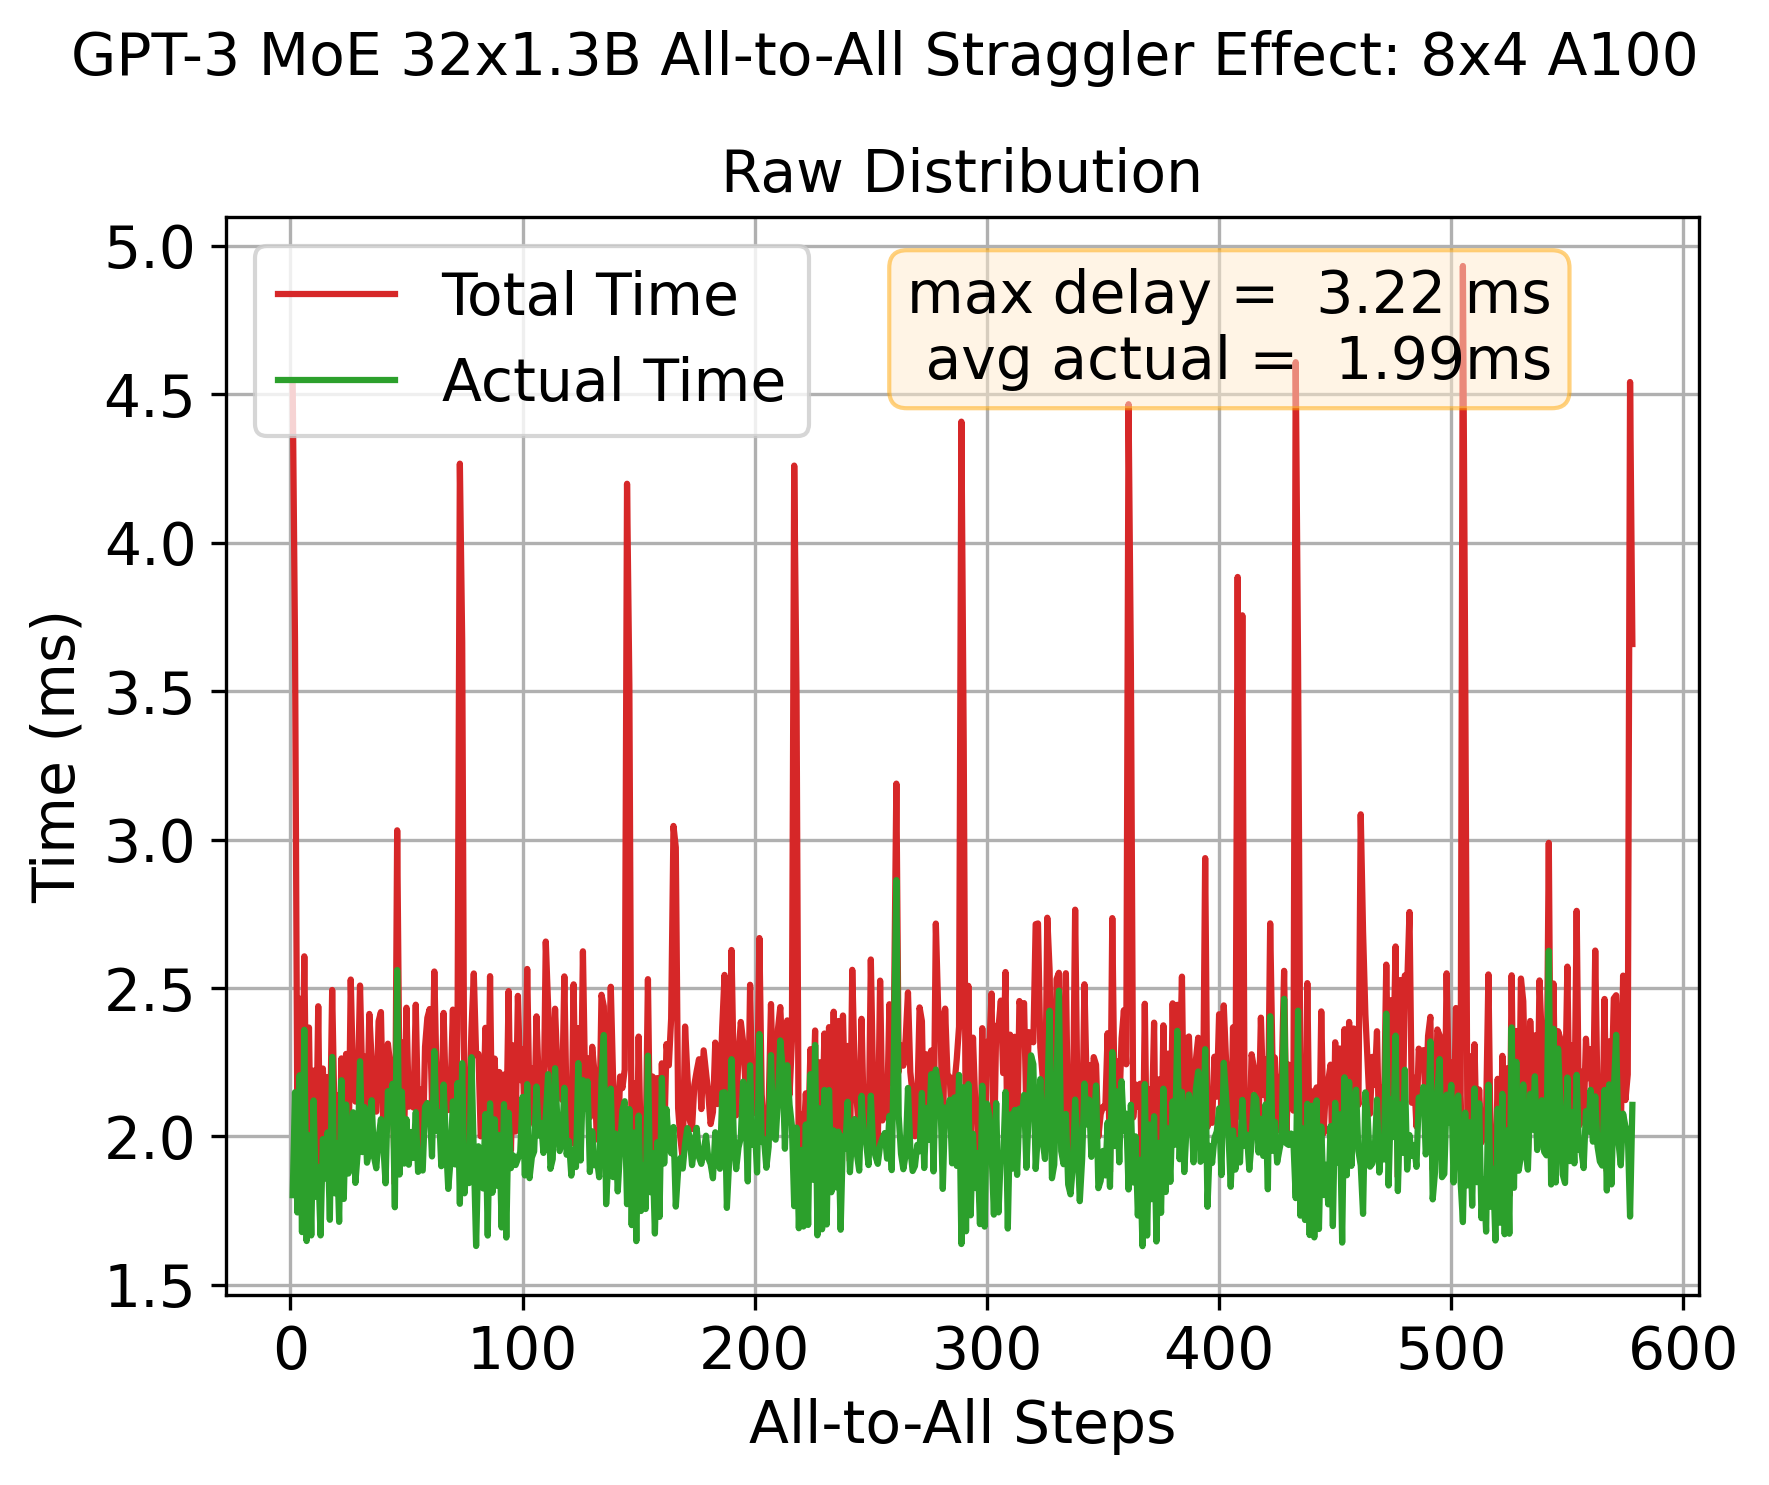

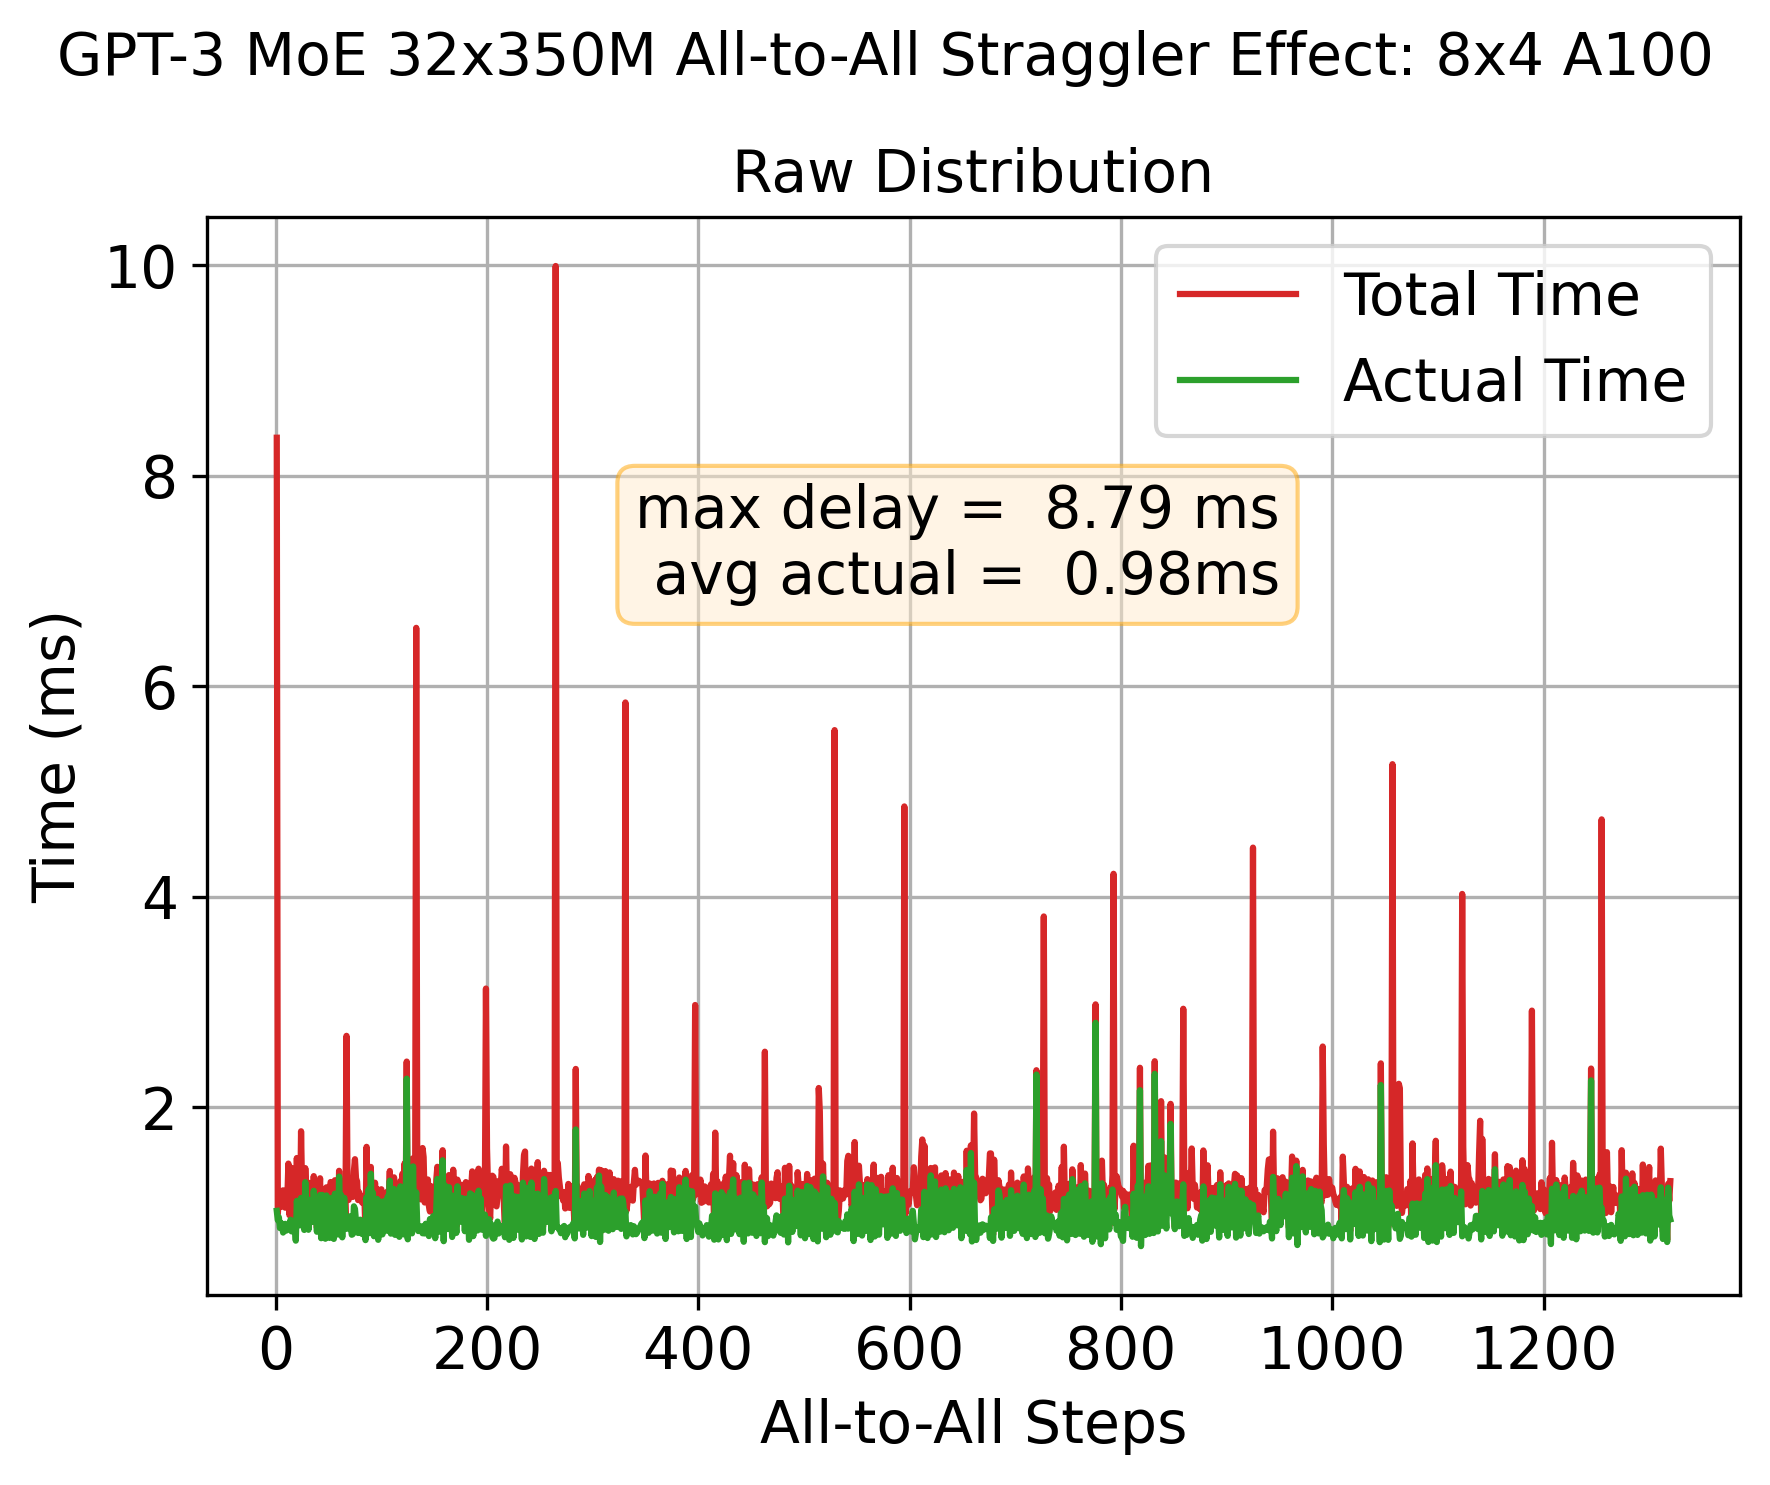

In [37]:
plot_straggler_delays(delays_dataset,
                      output_names=["GPT-3 MoE 8x350M", "GPT-3 MoE 32x1.3B", "GPT-3 MoE 32x350M"],
                      file_prefix='figures/',
                      addenda=["1x8 V100", "8x4 A100", "8x4 A100"])

## Memory Cost for Training and Inference
We present a case study motivating distributed training by contrasting the memory capacity of a single device with the footprint of the [PaLM family](https://arxiv.org/abs/2204.02311). We use the models from [Pope et al](https://proceedings.mlsys.org/paper_files/paper/2023/hash/523f87e9d08e6071a3bbd150e6da40fb-Abstract-mlsys2023.html).

### Training Memory Cost
We adapt [Smith et al.](https://arxiv.org/abs/2201.11990) to derive below.
#### Training Weights per Parameter
$$\underbrace{\rho+4}_{\text{weights}} +\underbrace{\rho+4}_{\text{gradients}}+\underbrace{4+4}_{\text{Adam moments}}=20\text{ bytes}$$

#### Activations
$$\underbrace{L}_{\text{layers}}\times \underbrace{s}_{\text{seq len}}\times \underbrace{b}_{\mu\text{ batch}} \times \underbrace{h}_{\text{hidden}} \times \underbrace{\rho}_{\text{precision}}$$

#### Inference Cost w/o KV Cache
$$\underbrace{(P\times \rho)}_{\text{weights}} +\underbrace{(s\times b \times h \times \rho)}_{\text{prev layer activations }}$$

In [53]:
# All in TB
training_weights = [934, 2640, 2820, 6280, 9600]
inference_cost=[93.4, 264, 282, 628, 960]
#Source: https://en.wikipedia.org/wiki/Tensor_Processing_Unit
tpu_memory_capacity=[32, 32, 32, 32, 32] 
dist_tpu_memory_capacity=[512*32, 512*32, 512*32, 512*32, 512*32]
#Source: https://resources.nvidia.com/en-us-blackwell-architecture/blackwell-architecture-technical-brief
gpu_memory_capacity=[192, 192, 192, 192, 192]
dist_gpu_memory_capacity=[192*64, 192*64, 192*64, 192*64, 192*64]
model_spec=np.linspace(1, len(training_weights), num=len(training_weights), dtype=int)

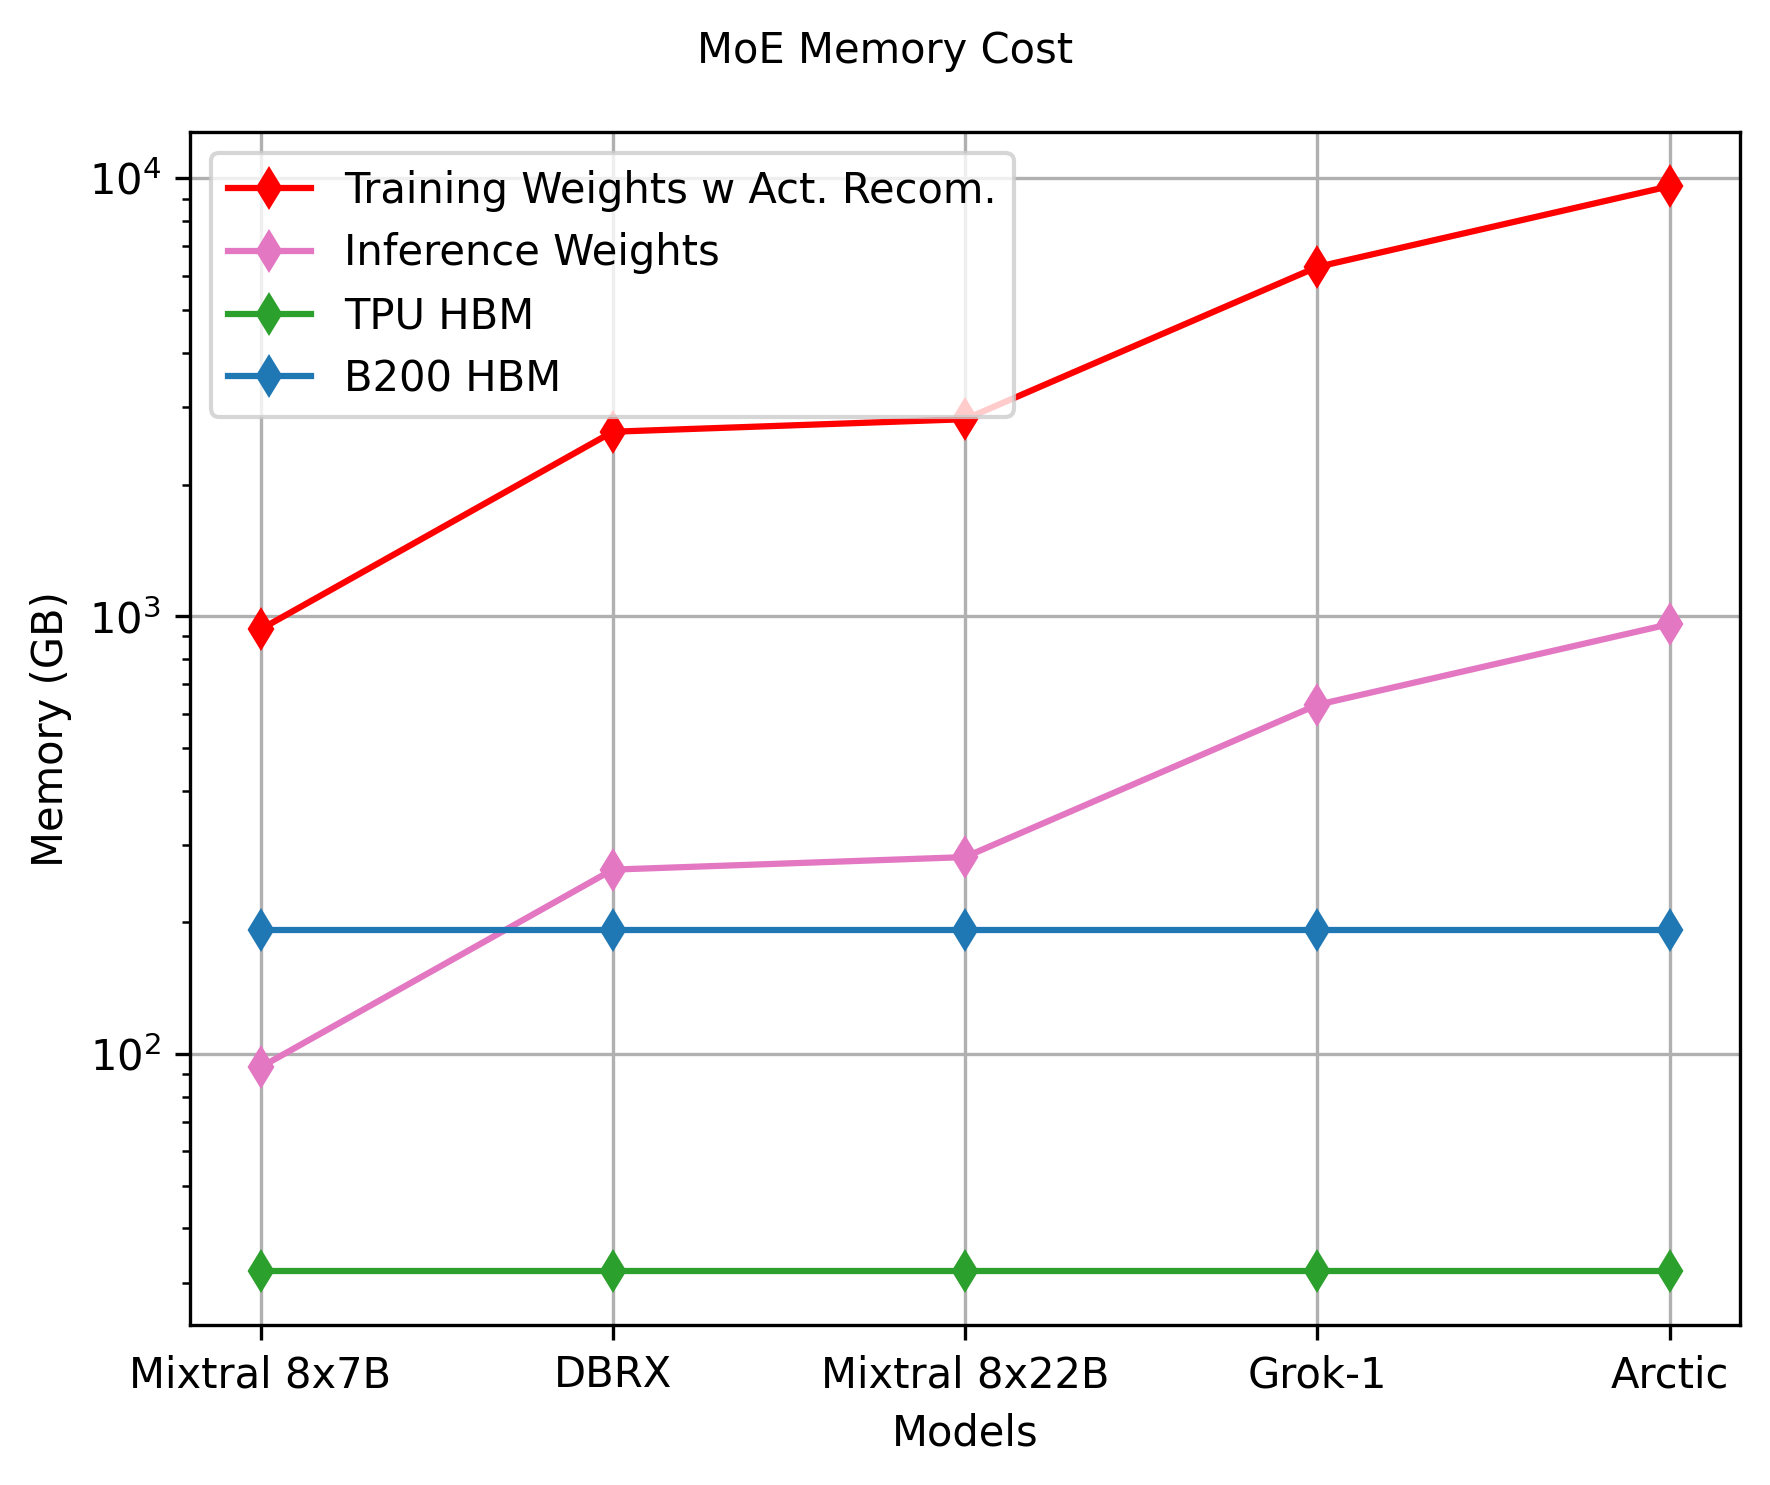

In [26]:
single_plot(model_spec, [training_weights, 
                         inference_cost, tpu_memory_capacity, 
                         gpu_memory_capacity], 
            "MoE Memory Cost", "Models", n_plots=4, 
            color=["red", "tab:pink", "tab:green", "tab:blue"], y_title="Memory (GB)", 
            out_name="mem_cap_gpu_cost.pdf", 
            labels=["Training Weights w Act. Recom.", "Inference Weights", "TPU HBM", "B200 HBM"], 
            plot_marker="d", x_ticks=["Mixtral 8x7B", "DBRX", "Mixtral 8x22B", "Grok-1", "Arctic"], y_scale='log', y_scale_base=10)

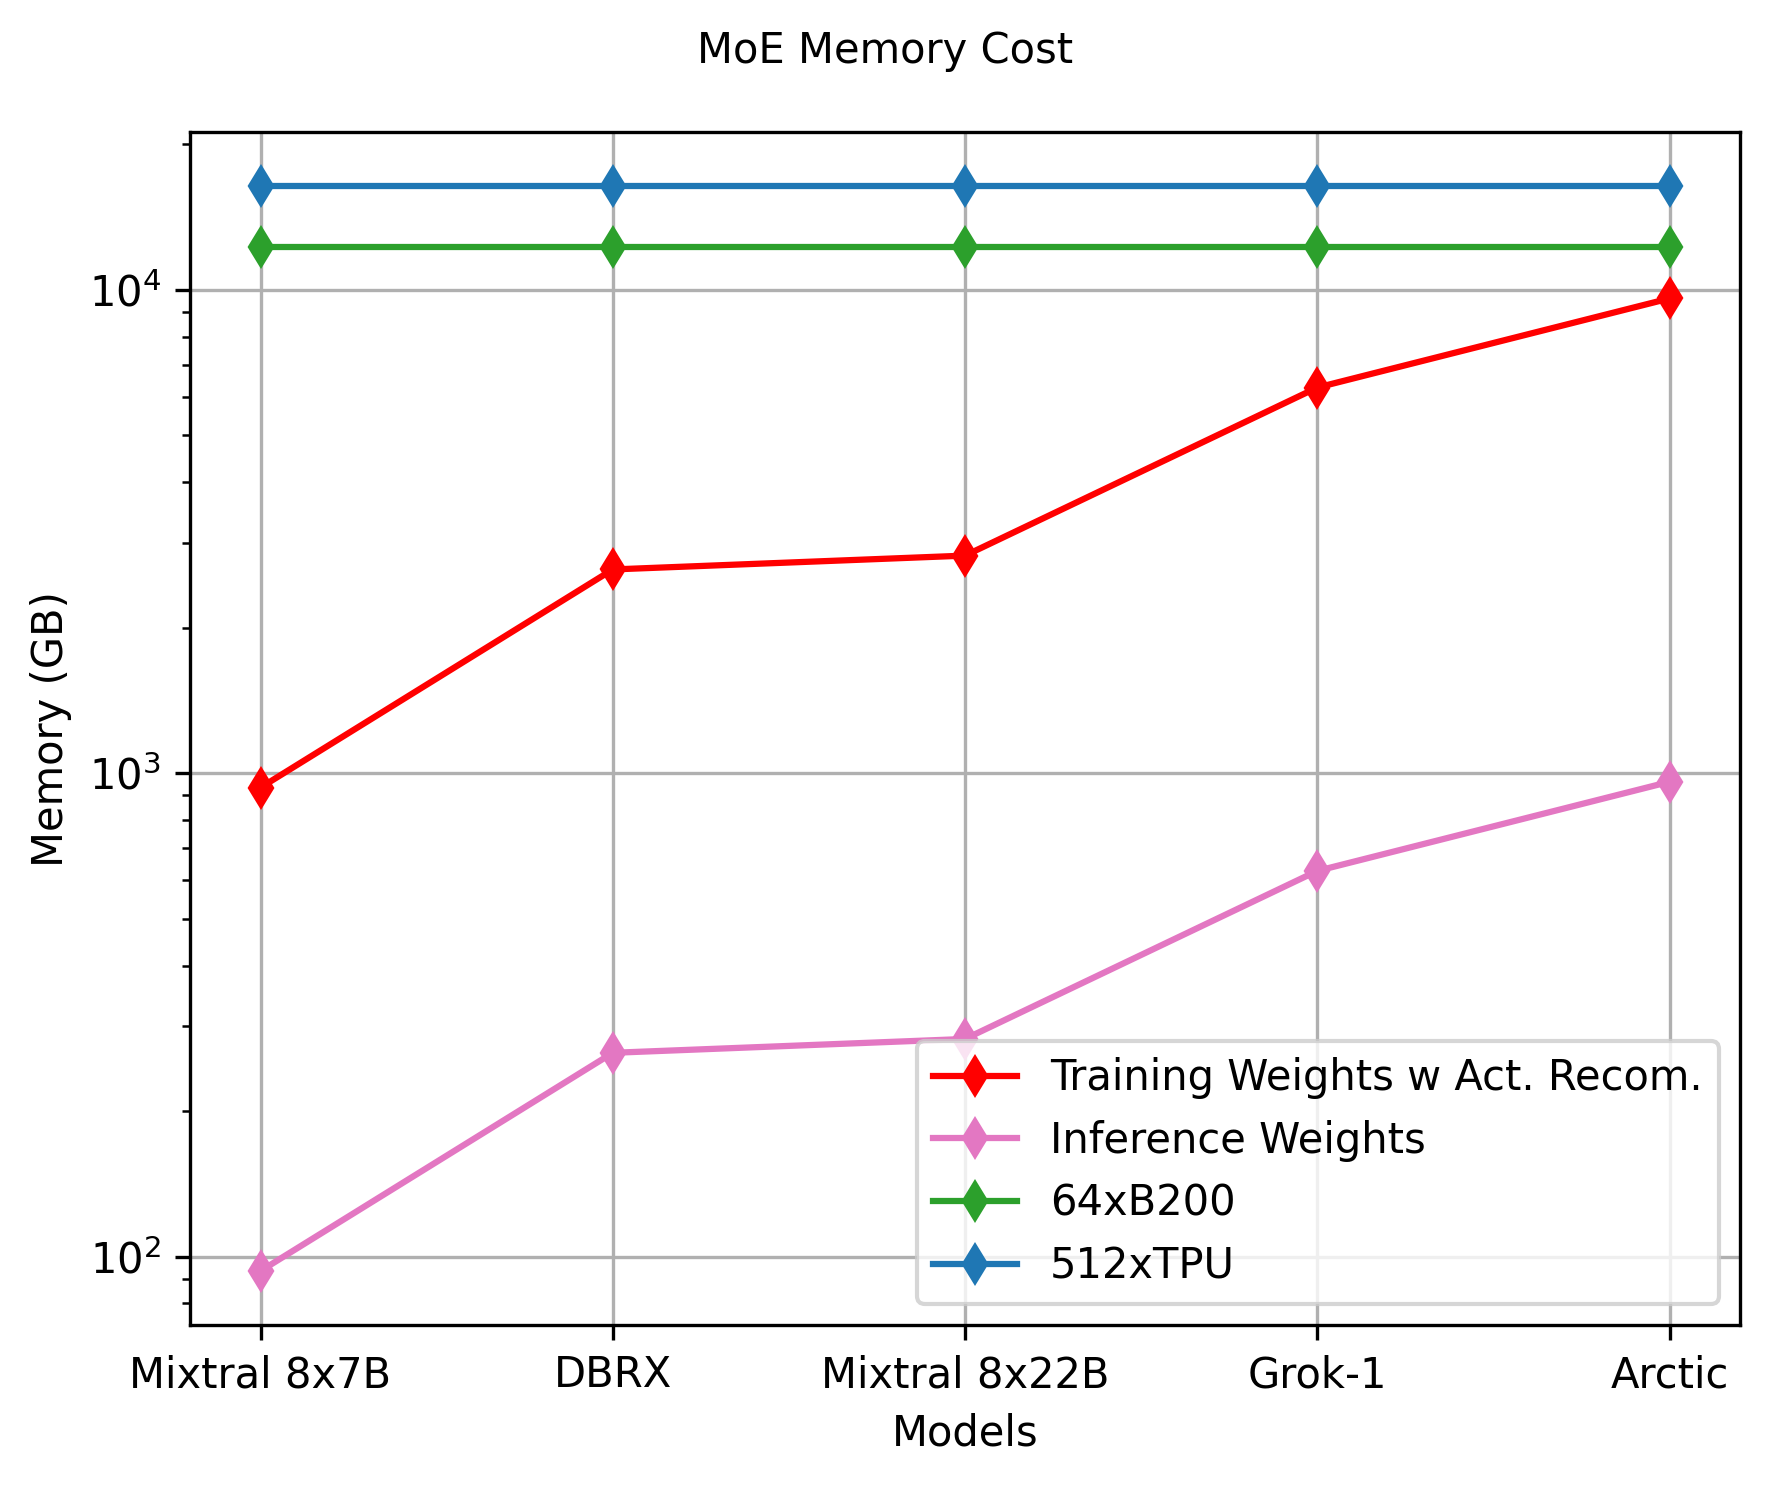

In [56]:
single_plot(model_spec, [training_weights, 
                         inference_cost, dist_gpu_memory_capacity, dist_tpu_memory_capacity], 
            "MoE Memory Cost", "Models", n_plots=4, 
            color=["red", "tab:pink", "tab:green", "tab:blue", "cyan", "purple"], y_title="Memory (GB)", 
            out_name="dist_mem_cap_gpu_cost.pdf", 
            labels=["Training Weights w Act. Recom.", "Inference Weights", "64xB200", "512xTPU"], 
            plot_marker="d", x_ticks=["Mixtral 8x7B", "DBRX", "Mixtral 8x22B", "Grok-1", "Arctic"], y_scale='log', y_scale_base=10)

# Lysi Evaluation
- Global batch size $B=256$
- Mini-batch size $b=4$
- Hidden size $H=1024$
- All experiments done on the [Perlmutter](https://docs.nersc.gov/systems/perlmutter/architecture/)

### Latency and OOM

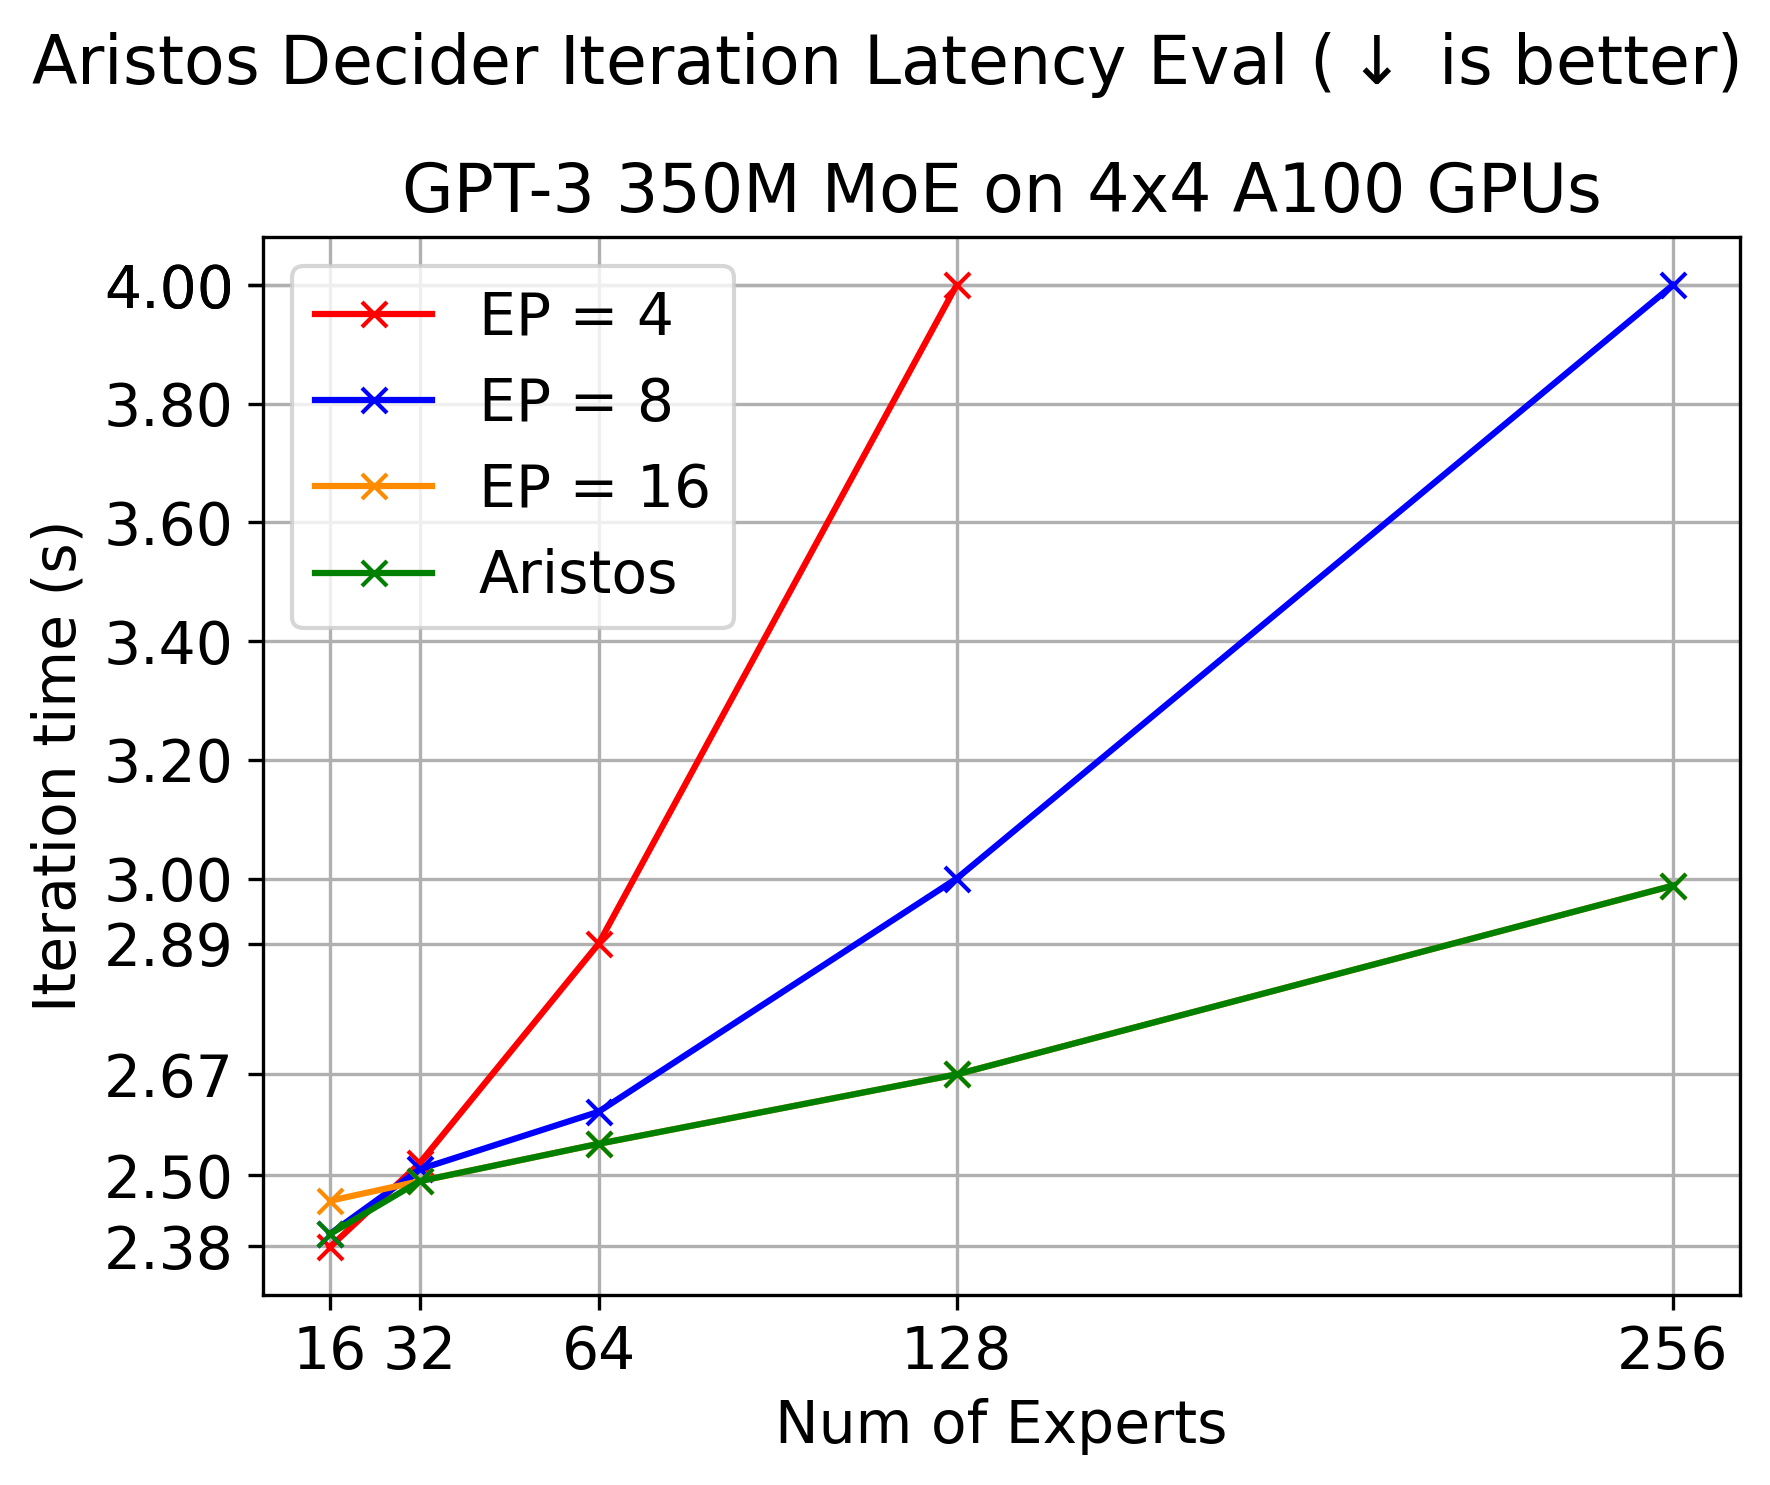

In [12]:
experts = [16, 32, 64, 128, 256]
ep_4 = [2.379, 2.52, 2.890, 4]
ep_8 = [2.401, 2.510, 2.607, 3, 4]
ep_16 = [2.457, 2.49, 2.553, 2.67, 2.988]
aristos = [2.401, 2.49, 2.553, 2.67, 2.988]
single_plot(experts, [ep_4, ep_8, ep_16, aristos], header=r"Aristos Decider Iteration Latency Eval ($\downarrow$ is better)", 
            x_title="Num of Experts", y_title="Iteration time (s)",
            out_name="multi_node_ep_times_ari.pdf", n_plots=4,
            labels=[r"EP = 4", r"EP = 8", r"EP = 16", r"Aristos"], color=["red", "blue", "darkorange", "green"], plot_marker="x",  
            x_ticks=experts, y_ticks=[2.38, 2.5, 2.67, 2.89, 3.0, 4.0, 3.2, 3.4, 3.6, 3.8, 4.0], header_font_size=16, axis_font_size=14,
            sub_title='GPT-3 350M MoE on 4x4 A100 GPUs')

## NVSHMEM vs NCCL
We compare NVSHMEM and NCCL, specifically assessing latency and bandwidth utilization for point-to-point communication.

### Multi-Node Results
4X4 Perlmutter GPU 40GB nodes

In [61]:
def parse_nccl_times(file_name: str, 
                     delimiter_regex: str, 
                     latency_index:int, 
                     bw_index:int, 
                     skip=0, time_unit='us', 
                     read_limit=0) -> Tuple[List[int], List[float], List[float]]:
    scaling_factor = 1  # us
    if time_unit == 'ms':
        scaling_factor = 1000
    
    results = open(file_name, "r")
    x = []
    latency = []
    bw = []
    reg = re.compile(delimiter_regex)
    
    for _ in range(skip):
        results.readline()
    
    line = results.readline()
    while line and read_limit > 0:
        split_line = reg.findall(line)
        print(split_line)
        x.append(int(split_line[0]))
        latency.append(float(split_line[latency_index]) / scaling_factor)
        bw.append(float(split_line[bw_index]) / scaling_factor)
        read_limit -= 1
        line = results.readline()
    return x, latency, bw

In [62]:
data_sizes, multi_nccl_latency, multi_nccl_bw = parse_nccl_times(
    "data/one_sided/fourXfour_nodes_80GB/sendrecv_nccl.txt",
    delimiter_regex=r"[^(\s+)]+",
    latency_index=5,
    bw_index=7,
    skip=9,
    read_limit=24)

['8', '2', 'float', 'sum', '-1', '26.63', '0.00', '0.00', '0', '25.80', '0.00', '0.00', 'N/A']
['16', '4', 'float', 'sum', '-1', '24.92', '0.00', '0.00', '0', '25.02', '0.00', '0.00', 'N/A']
['32', '8', 'float', 'sum', '-1', '25.13', '0.00', '0.00', '0', '25.19', '0.00', '0.00', 'N/A']
['64', '16', 'float', 'sum', '-1', '25.19', '0.00', '0.00', '0', '25.30', '0.00', '0.00', 'N/A']
['128', '32', 'float', 'sum', '-1', '29.76', '0.00', '0.00', '0', '29.83', '0.00', '0.00', 'N/A']
['256', '64', 'float', 'sum', '-1', '24.78', '0.01', '0.01', '0', '24.71', '0.01', '0.01', 'N/A']
['512', '128', 'float', 'sum', '-1', '24.82', '0.02', '0.02', '0', '24.50', '0.02', '0.02', 'N/A']
['1024', '256', 'float', 'sum', '-1', '24.79', '0.04', '0.04', '0', '24.74', '0.04', '0.04', 'N/A']
['2048', '512', 'float', 'sum', '-1', '25.28', '0.08', '0.08', '0', '25.54', '0.08', '0.08', 'N/A']
['4096', '1024', 'float', 'sum', '-1', '25.34', '0.16', '0.16', '0', '25.27', '0.16', '0.16', 'N/A']
['8192', '2048', 'fl

In [35]:
def parse_nvshmem_times(file_name: str, 
                        delimiter_regex: str, 
                        skip=0, time_unit='us', 
                        read_limit=0) -> Tuple[List[int], List[float]]:
    scaling_factor = 1  # us
    if time_unit == 'ms':
        scaling_factor = 1000
    
    results = open(file_name, "r")
    x = []
    data=[]
    reg = re.compile(delimiter_regex)
    
    for _ in range(skip):
        results.readline()
    
    line = results.readline()
    while line and read_limit > 0:
        split_line = reg.findall(line)
        print(split_line)
        if len(split_line) > 0 and split_line[0] != 'WARN:':
            x.append(int(split_line[0]))
            data.append(float(split_line[1]) / scaling_factor)
        results.readline()
        line = results.readline()
        read_limit -= 1
    return x, data

In [64]:
nvsh_data_sizes, put_latency = parse_nvshmem_times("data/one_sided/fourXfour_nodes_80GB/put_latency.txt",
                                                   delimiter_regex=r"[^(\s+)\|]+",
                                                   skip=123, time_unit='us',
                                                   read_limit=25)

['8', '10.482719']
['16', '10.485120']
['32', '10.482880']
['64', '10.457439']
['128', '10.510560']
['256', '10.606240']
['512', '10.557760']
['1024', '10.637600']
['2048', '10.793279']
['4096', '10.712800']
['8192', '11.162400']
['16384', '11.948800']
['32768', '12.502721']
['65536', '13.865761']
['131072', '16.524160']
['262144', '21.936481']
['524288', '32.805920']
['1048576', '55.054405']
['2097152', '99.215683']
['4194304', '187.533615']
['8388608', '364.320770']
['16777216', '726.047791']
['WARN:', 'FI_CXI_OPTIMIZED_MRS', 'is', 'set.', 'This', 'may', 'cause', 'a', 'hang', 'at', 'runtime', 'if', 'the', 'value', 'is', 'not', '0.']
['33554432', '1426.653442']
['67108864', '2857.879395']


In [65]:
_, get_latency = parse_nvshmem_times("data/one_sided/fourXfour_nodes_80GB/get_latency.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=123, time_unit='us',
                                     read_limit=24)

['8', '10.024479']
['16', '10.071200']
['32', '9.962080']
['64', '9.914720']
['128', '9.960640']
['256', '9.964001']
['512', '10.023680']
['1024', '10.196000']
['2048', '10.082400']
['4096', '10.290081']
['8192', '11.248800']
['16384', '11.524320']
['32768', '12.699680']
['65536', '13.962720']
['131072', '16.431200']
['262144', '21.958721']
['524288', '33.042877']
['1048576', '54.461124']
['2097152', '98.360001']
['4194304', '184.682083']
['8388608', '360.302063']
['16777216', '724.193726']
['33554432', '1422.876587']
['67108864', '2866.320068']


In [36]:
def fmt_bytes(x, pos):
    if x < 1024:
        return "{:d}B".format(int(x))
    if 1024 <= x < 1024 ** 2:
        return "{:d}KB".format(int(x/1024))
    return "{:d}MB".format(int(x/(1024**2)))

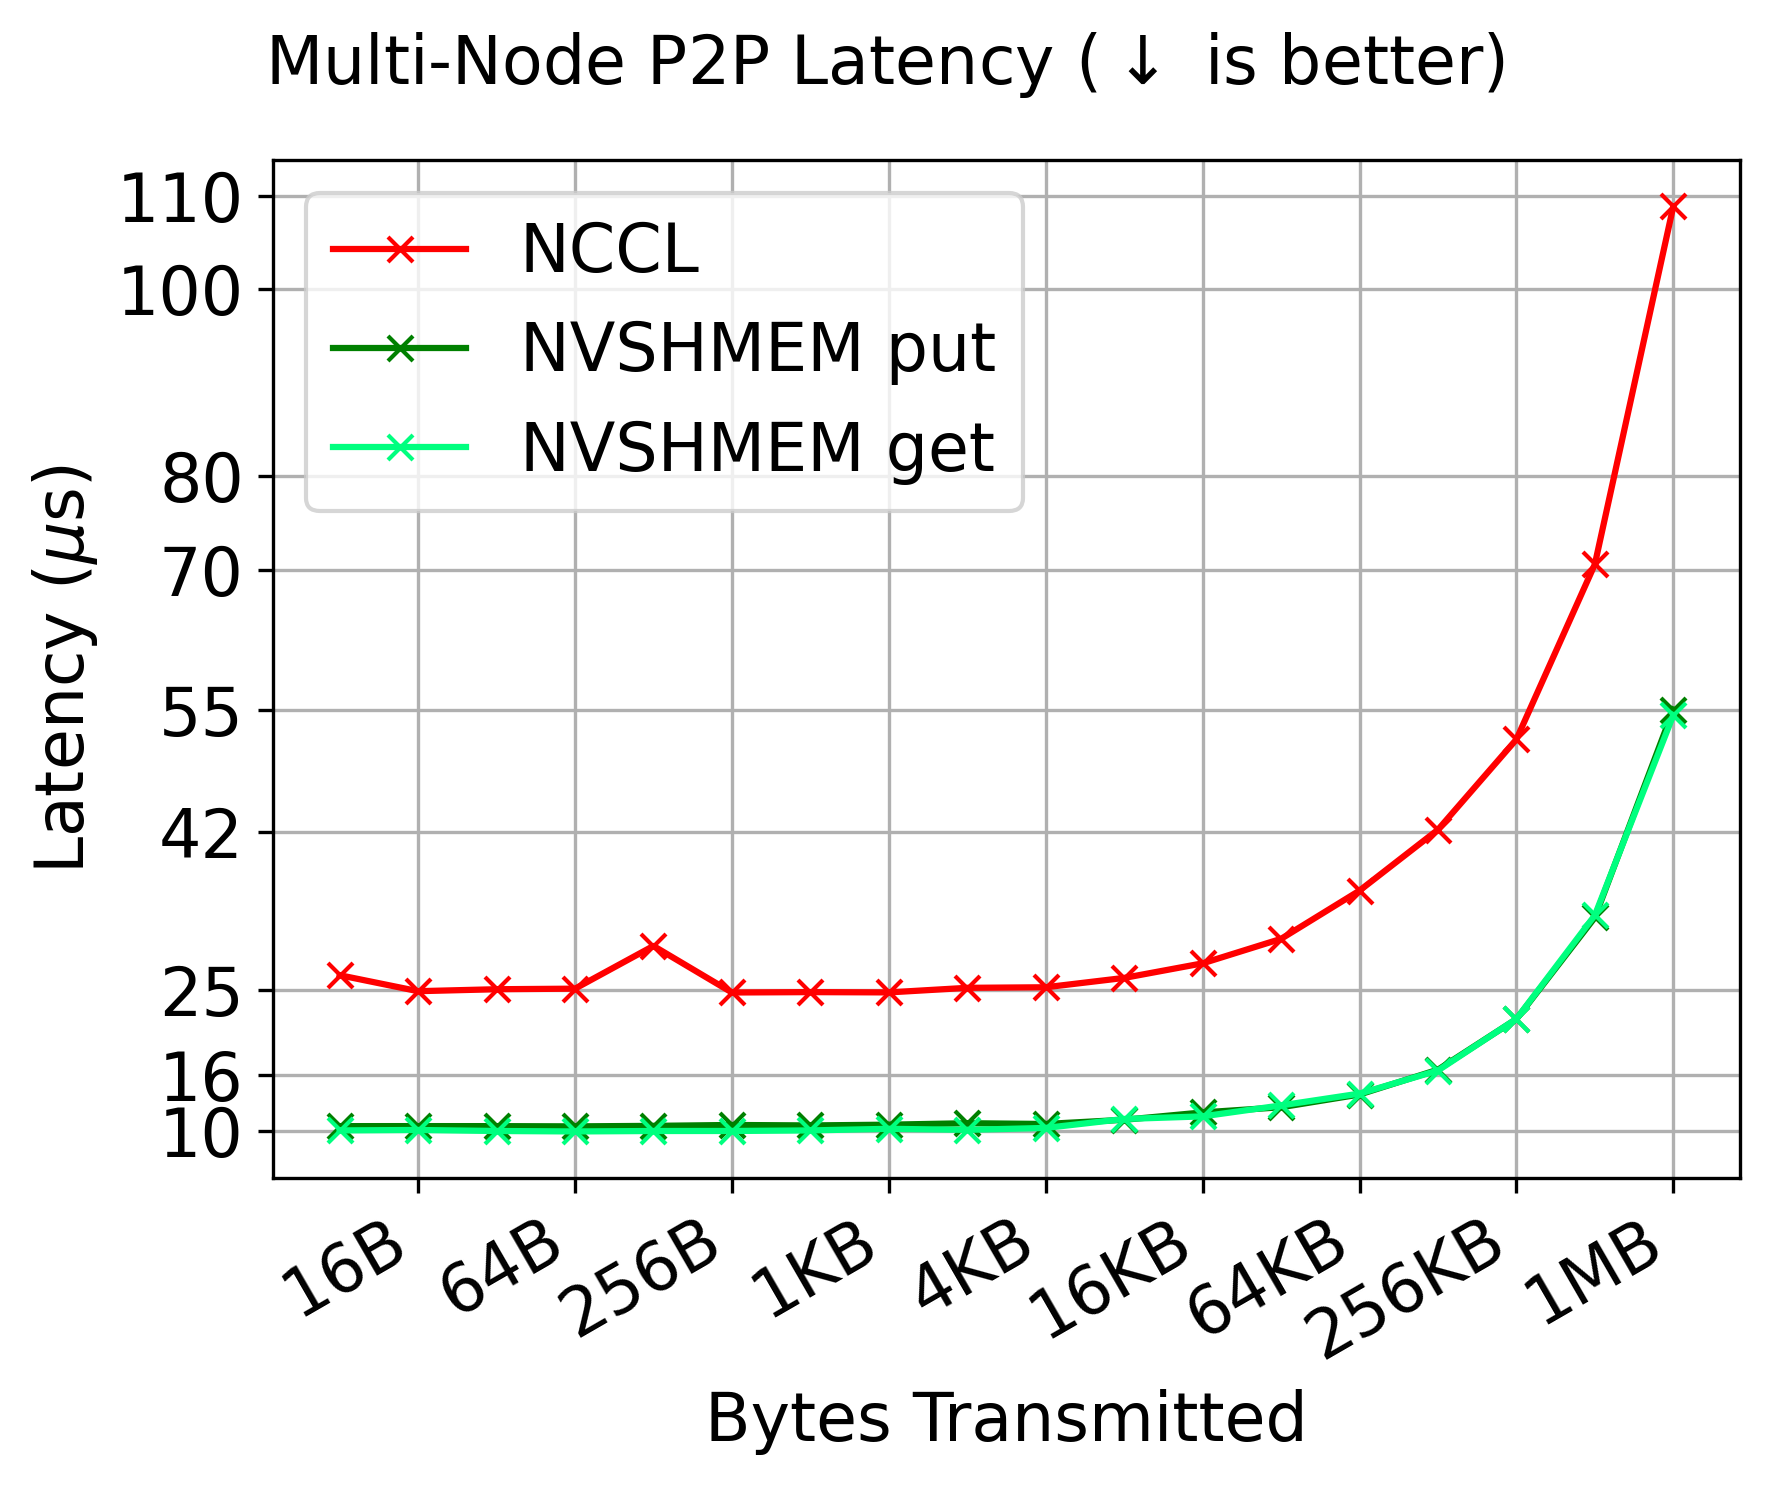

In [110]:
first = 0
# second = len(data_sizes)
second = 18
single_plot(data_sizes[first:second], [multi_nccl_latency[first:second], put_latency[first:second], get_latency[first:second]], 
            header=r"Multi-Node P2P Latency ($\downarrow$ is better)", 
            x_title="Bytes Transmitted", y_title=r"Latency ($\mu$s)",
            out_name="nccl_v_nvsh_lat_left.pdf", n_plots=3,
            labels=[r"NCCL", r"NVSHMEM put", r"NVSHMEM get"], color=["red", "green", "springgreen"], 
            plot_marker="x", x_rotation=30, x_scale='log', x_func_formatter=fmt_bytes, y_ticks=[10, 16, 25, 42, 55, 70,80, 100, 110],
            header_font_size=16, axis_font_size=16)

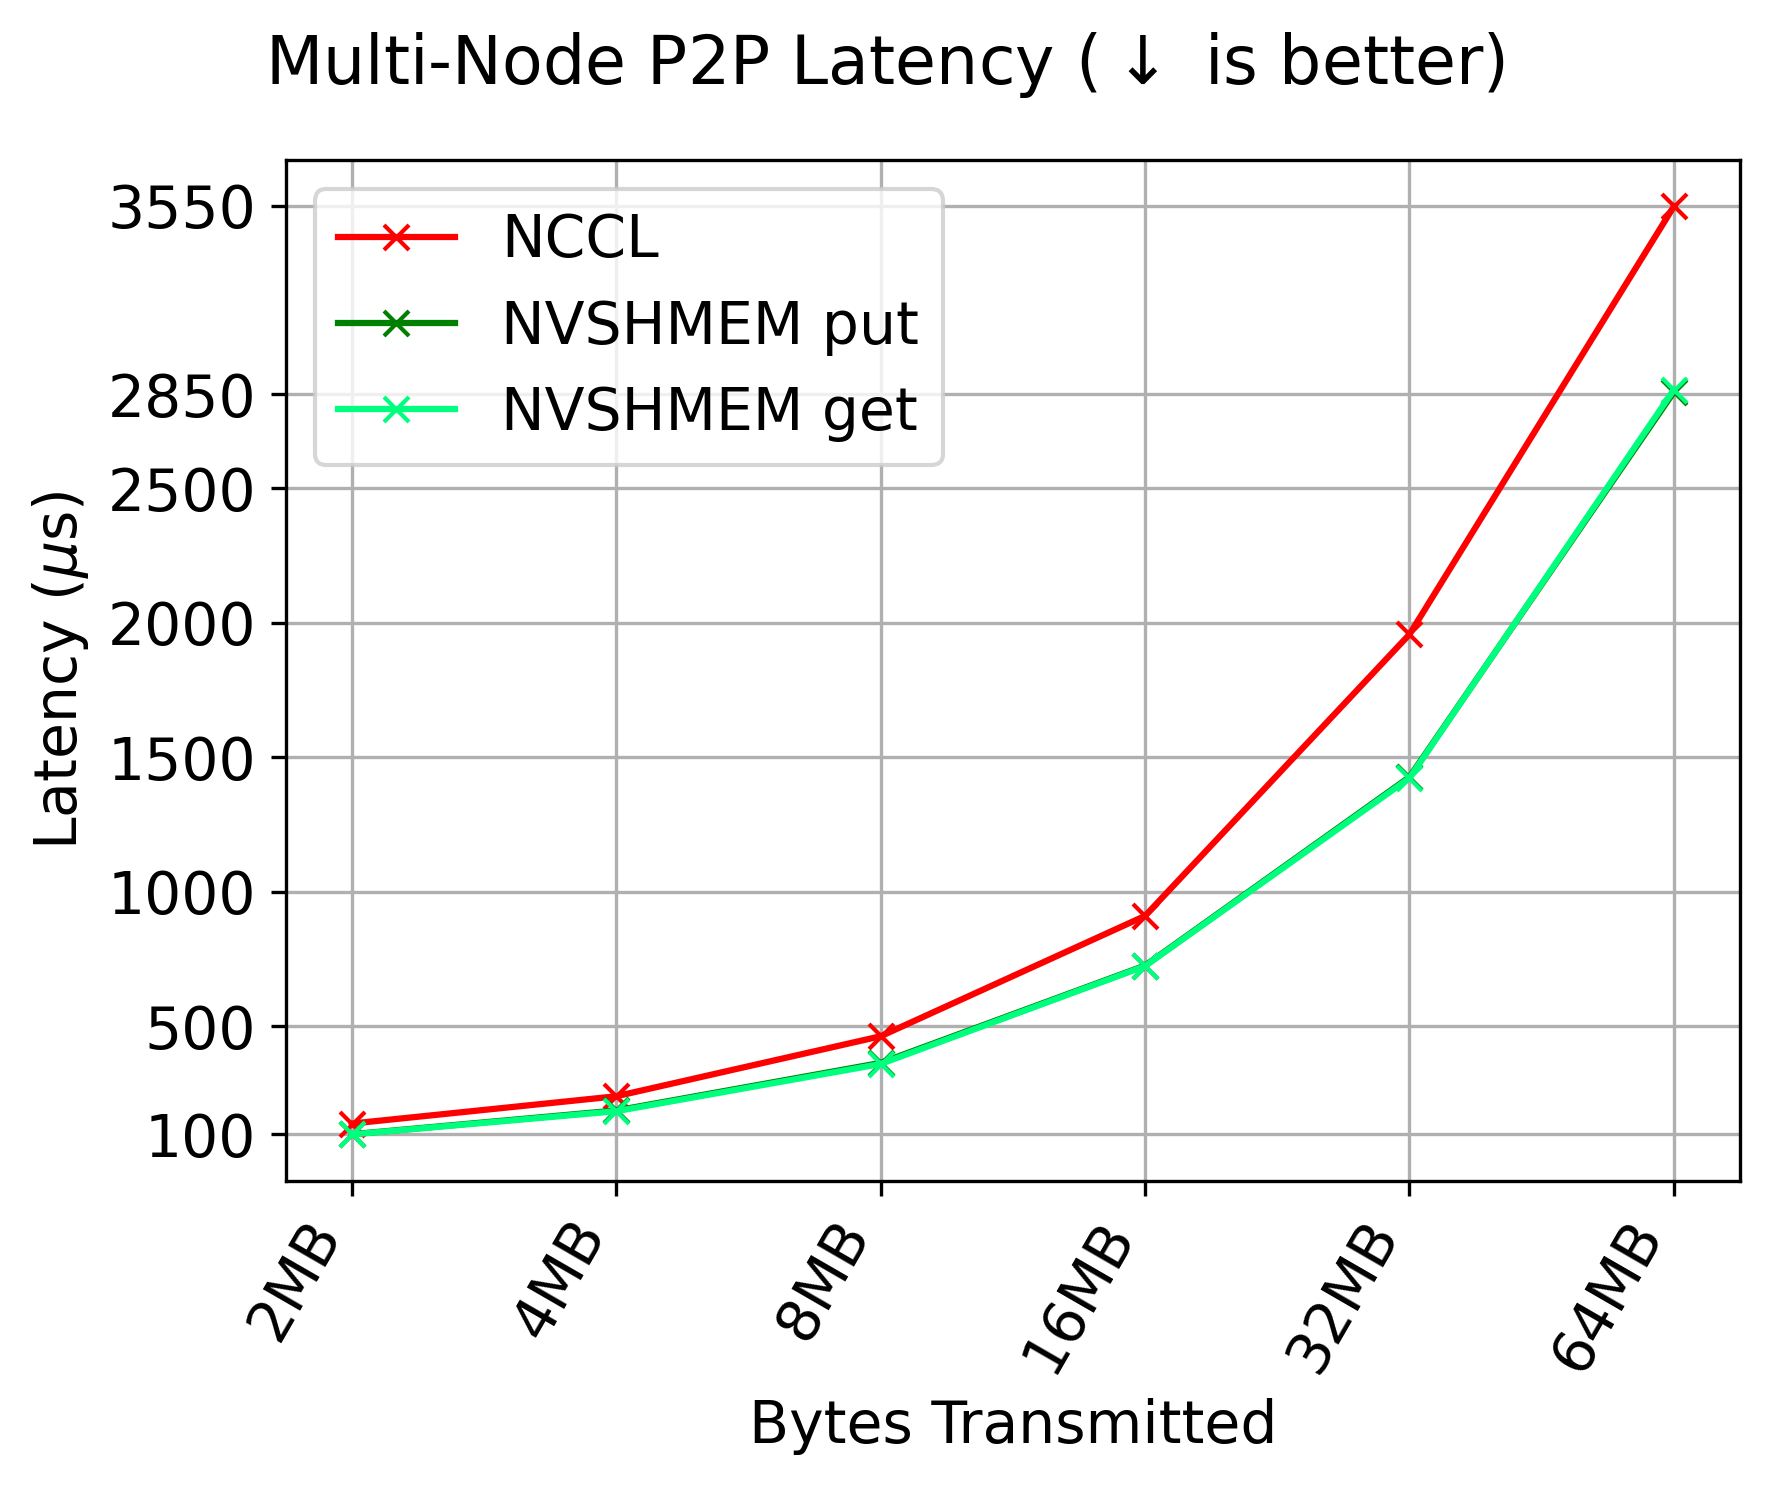

In [109]:
first_slice = 18
second_slice = len(data_sizes)
single_plot(data_sizes[first_slice:second_slice], 
            [multi_nccl_latency[first_slice:second_slice], 
             put_latency[first_slice:second_slice], 
             get_latency[first_slice:second_slice]], 
            header=r"Multi-Node P2P Latency ($\downarrow$ is better)", 
            x_title="Bytes Transmitted", y_title=r"Latency ($\mu$s)",
            out_name="nccl_v_nvsh_lat_right.pdf", n_plots=3,
            labels=[r"NCCL", r"NVSHMEM put", r"NVSHMEM get"], color=["red", "green", "springgreen"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_ticks=data_sizes[first_slice:second_slice], y_ticks=[100, 500, 1000, 1500, 2000, 2500, 2850, 3550],
            header_font_size=16, axis_font_size=14, x_scale='log')

In [77]:
bw_data, put_bw = parse_nvshmem_times("data/one_sided/fourXfour_nodes_80GB/put_bw.txt",
                                      delimiter_regex=r"[^(\s+)\|]+",
                                      skip=9,
                                      read_limit=17)

['1024', '0.382794']
['2048', '0.772083']
['4096', '1.528624']
['8192', '3.092938']
['16384', '6.162695']
['32768', '12.204739']
['65536', '21.466276']
['131072', '21.825468']
['262144', '22.016914']
['524288', '21.988840']
['1048576', '22.130579']
['2097152', '22.037502']
['4194304', '22.100992']
['8388608', '21.594481']
['16777216', '22.110109']
['33554432', '21.977303']
['67108864', '21.982590']


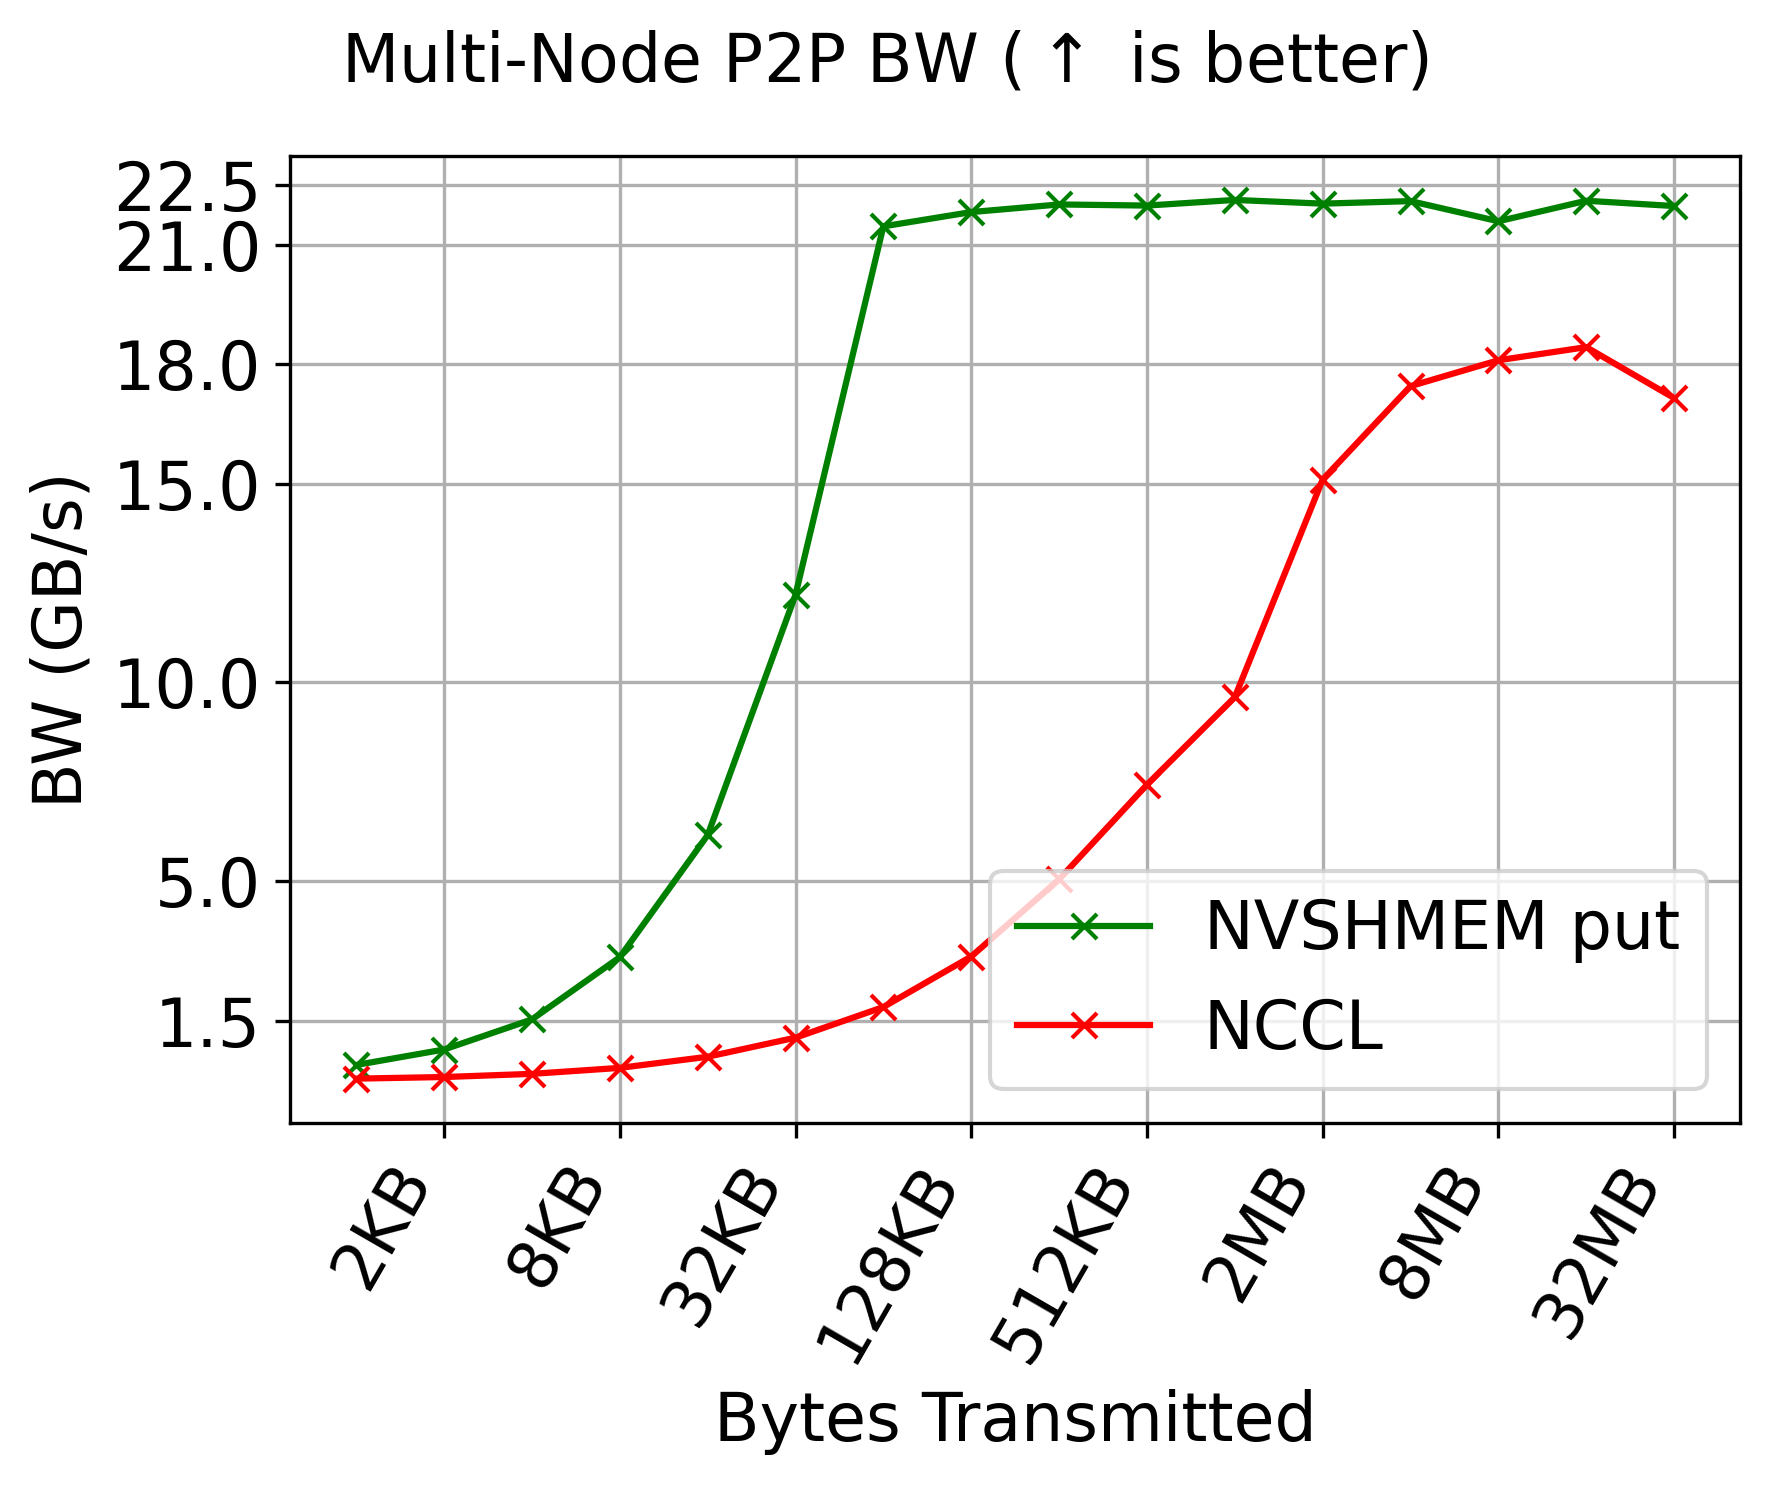

In [108]:
first = 0
second = 16
nccl_offset = 7
single_plot(bw_data[first:second], 
            [put_bw[first:second], multi_nccl_bw[nccl_offset+first:nccl_offset+second]], 
            header=r"Multi-Node P2P BW ($\uparrow$ is better)", 
            x_title="Bytes Transmitted", y_title="BW (GB/s)",
            out_name="nccl_v_nvsh_bw.pdf", n_plots=2,
            labels=[r"NVSHMEM put", r"NCCL"], color=["green", "red"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log', y_ticks=[1.5, 5, 10, 15, 18, 21, 22.5],
            header_font_size=16, axis_font_size=16)

In [41]:
a2a_data, a2a_lat = parse_nvshmem_times("data/one_sided/fourXfour_nodes_80GB/a2a_nvsh.txt",
                                        delimiter_regex=r"[^(\s+)\|]+",
                                        skip=164,
                                        read_limit=31)

['8', '37.321920']
['16', '37.657599']
['32', '37.242241']
['64', '37.978239']
['128', '38.965120']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['256', '38.151360']
['512', '37.249601']
['1024', '37.079041']
['2048', '37.154241']
['4096', '37.406399']
['8192', '38.797121']
['16384', '45.527039']
['32768', '58.868160']
['65536', '87.059841']
['131072', '145.872002']
['262144', '243.359680']
['524288', '455.120010']
['1048576', '816.309738']
['2097152', '1626.018524']


In [42]:
a2a_comm_vol, a2a_nccl_latency, a2a_nccl_bw = parse_nccl_times("data/one_sided/fourXfour_nodes_80GB/a2a_nccl.txt",
                                                               delimiter_regex=r"[^(\s+)]+",
                                                               latency_index=5,
                                                               bw_index=7,
                                                               skip=27,
                                                               read_limit=19)

['128', '2', 'float', 'none', '-1', '94.11', '0.00', '0.00', '0', '97.55', '0.00', '0.00', 'N/A']
['256', '4', 'float', 'none', '-1', '94.27', '0.00', '0.00', '0', '92.32', '0.00', '0.00', 'N/A']
['512', '8', 'float', 'none', '-1', '94.65', '0.01', '0.01', '0', '99.02', '0.01', '0.00', 'N/A']
['1024', '16', 'float', 'none', '-1', '93.79', '0.01', '0.01', '0', '92.77', '0.01', '0.01', 'N/A']
['2048', '32', 'float', 'none', '-1', '134.4', '0.02', '0.01', '0', '143.8', '0.01', '0.01', 'N/A']
['4096', '64', 'float', 'none', '-1', '90.20', '0.05', '0.04', '0', '94.30', '0.04', '0.04', 'N/A']
['8192', '128', 'float', 'none', '-1', '92.48', '0.09', '0.08', '0', '87.07', '0.09', '0.09', 'N/A']
['16384', '256', 'float', 'none', '-1', '95.75', '0.17', '0.16', '0', '90.84', '0.18', '0.17', 'N/A']
['32768', '512', 'float', 'none', '-1', '91.70', '0.36', '0.33', '0', '95.40', '0.34', '0.32', 'N/A']
['65536', '1024', 'float', 'none', '-1', '93.07', '0.70', '0.66', '0', '94.19', '0.70', '0.65', 'N/A'

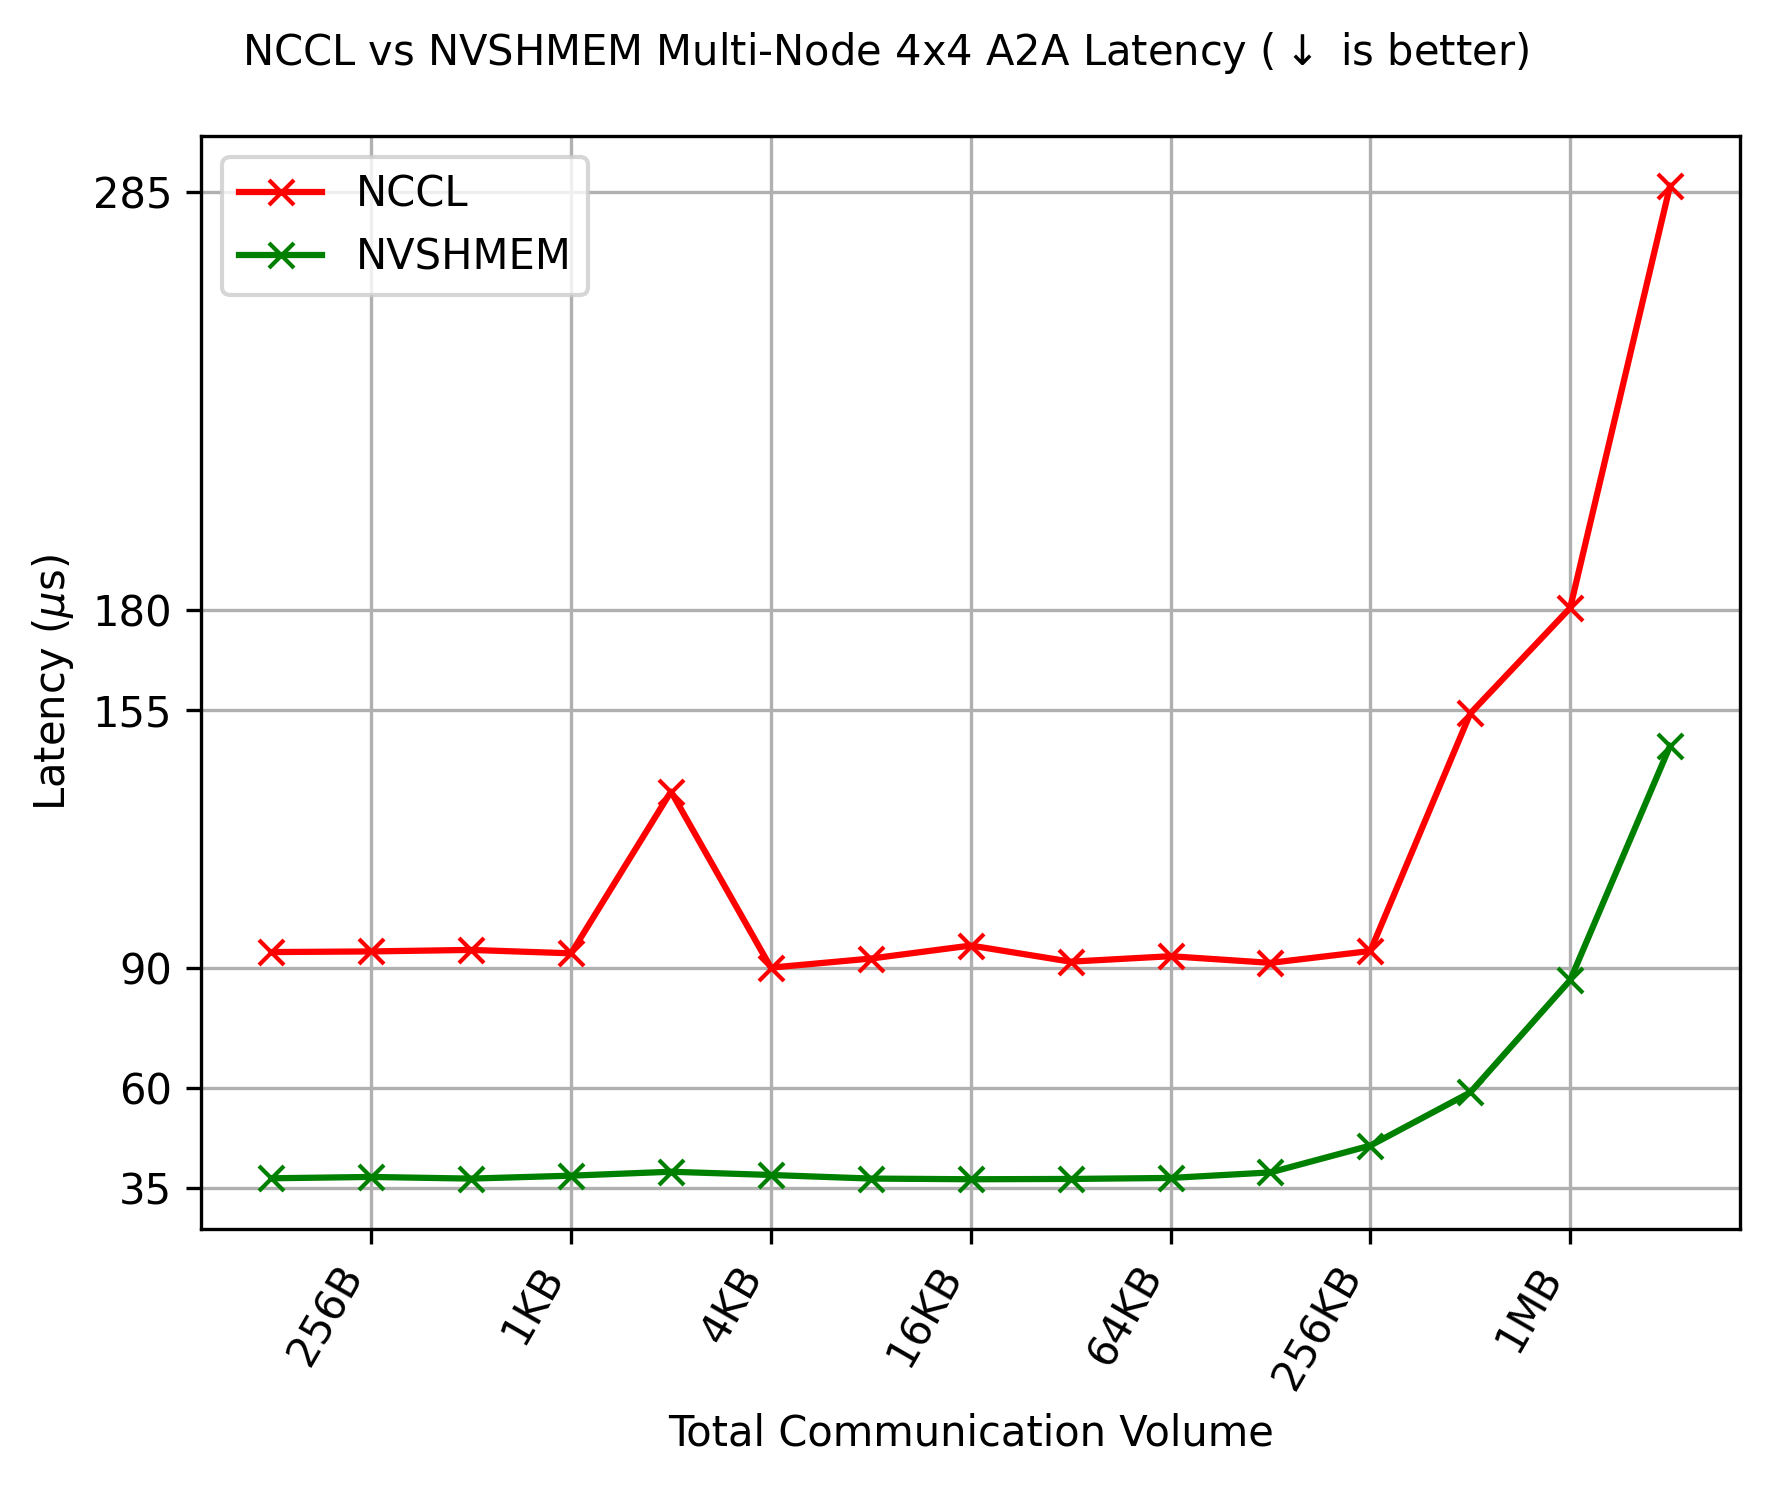

In [43]:
first = 0
second = 15
single_plot(a2a_comm_vol[first:second], 
            [a2a_nccl_latency[first:second], a2a_lat[first:second]], 
            header=r"NCCL vs NVSHMEM Multi-Node 4x4 A2A Latency ($\downarrow$ is better)", 
            x_title="Total Communication Volume", y_title=r"Latency ($\mu$s)",
            out_name="nccl_v_nvsh_a2a_lat", n_plots=2,
            labels=[r"NCCL", r"NVSHMEM"], color=["red", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log', y_ticks=[35, 60, 90, 155, 180, 285])

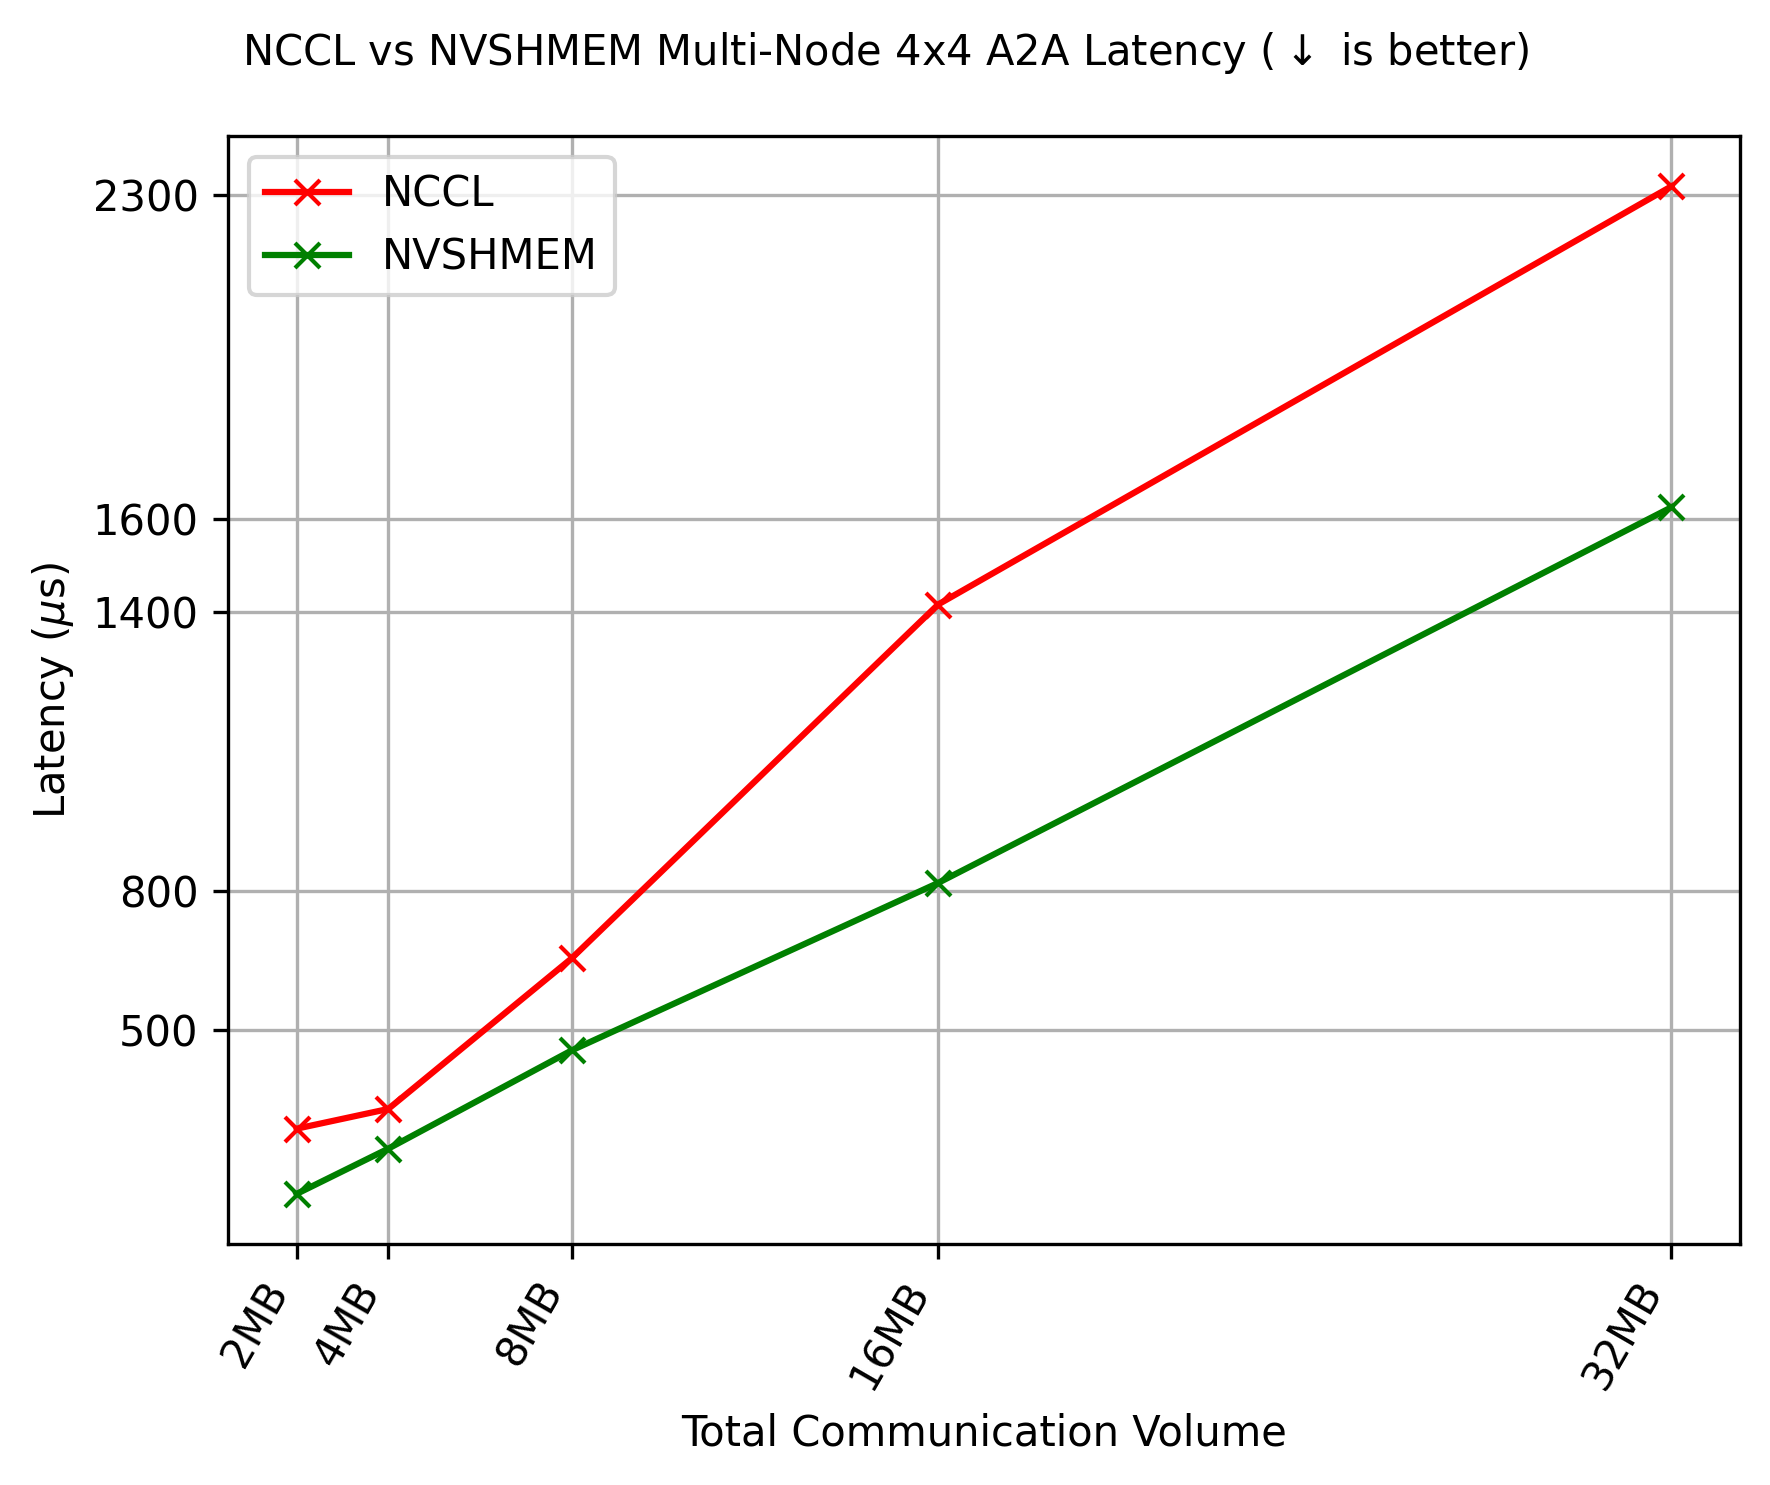

In [44]:
first = 14
second = len(a2a_comm_vol)
single_plot(a2a_comm_vol[first:second], 
            [a2a_nccl_latency[first:second], a2a_lat[first:second]], 
            header=r"NCCL vs NVSHMEM Multi-Node 4x4 A2A Latency ($\downarrow$ is better)", 
            x_title="Total Communication Volume", y_title=r"Latency ($\mu$s)",
            out_name="nccl_v_nvsh_a2a_lat_right", n_plots=2,
            labels=[r"NCCL", r"NVSHMEM"], color=["red", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_ticks=a2a_comm_vol[first:second], y_ticks=[500, 800, 1400, 1600, 2300])

In [45]:
num_gpus = 16
nvsh_ideal_a2a = []
print(put_latency[14:19])
for t in put_latency[14:19]:
    nvsh_ideal_a2a.append(t*num_gpus)
print(nvsh_ideal_a2a)

[16.52416, 21.936481, 32.80592, 55.054405, 99.215683]
[264.38656, 350.983696, 524.89472, 880.87048, 1587.450928]


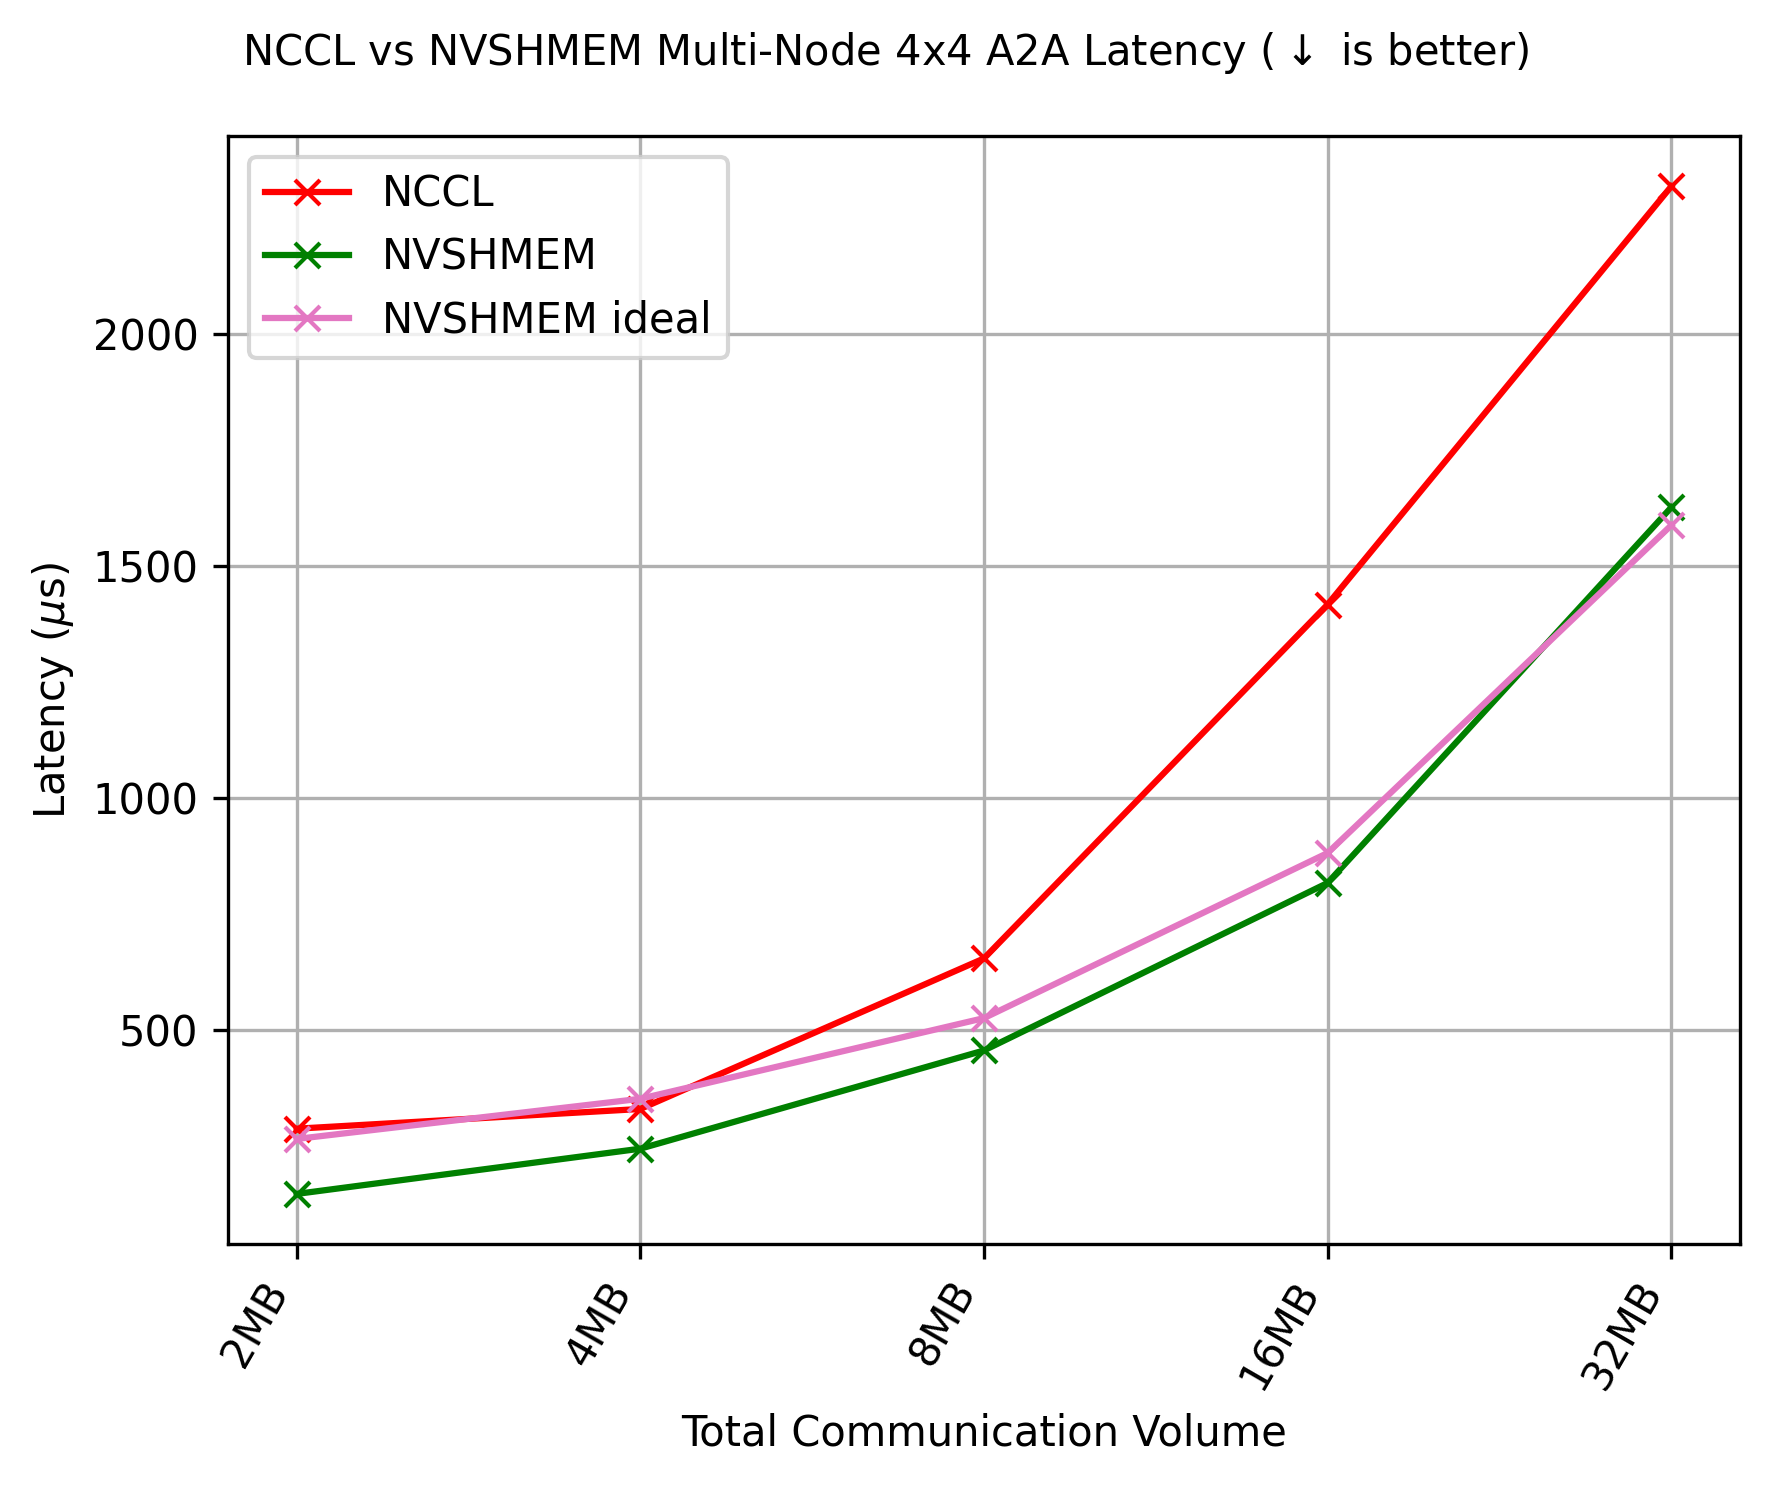

In [46]:
first = 14
second = len(a2a_comm_vol)
single_plot(a2a_comm_vol[first:second], 
            [a2a_nccl_latency[first:second], a2a_lat[first:second], nvsh_ideal_a2a], 
            header=r"NCCL vs NVSHMEM Multi-Node 4x4 A2A Latency ($\downarrow$ is better)", 
            x_title="Total Communication Volume", y_title=r"Latency ($\mu$s)",
            out_name="nccl_v_nvsh_v_ideal_a2a_lat", n_plots=3,
            labels=[r"NCCL", r"NVSHMEM", r"NVSHMEM ideal"], color=["red", "green", "tab:pink"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log')

## Single Node Results

In [84]:
s_data_sizes, single_nccl_latency, single_nccl_bw = parse_nccl_times(
    "data/one_sided/single_node_80GB/sendrecv_nccl.txt",
    delimiter_regex=r"[^(\s+)]+",
    latency_index=5,
    bw_index=7,
    skip=9,
    read_limit=27)

['8', '2', 'float', 'sum', '-1', '8.96', '0.00', '0.00', '0', '8.97', '0.00', '0.00', 'N/A']
['16', '4', 'float', 'sum', '-1', '8.89', '0.00', '0.00', '0', '9.05', '0.00', '0.00', 'N/A']
['32', '8', 'float', 'sum', '-1', '8.87', '0.00', '0.00', '0', '9.09', '0.00', '0.00', 'N/A']
['64', '16', 'float', 'sum', '-1', '8.94', '0.01', '0.01', '0', '8.97', '0.01', '0.01', 'N/A']
['128', '32', 'float', 'sum', '-1', '8.97', '0.01', '0.01', '0', '9.07', '0.01', '0.01', 'N/A']
['256', '64', 'float', 'sum', '-1', '8.86', '0.03', '0.03', '0', '8.99', '0.03', '0.03', 'N/A']
['512', '128', 'float', 'sum', '-1', '9.00', '0.06', '0.06', '0', '8.80', '0.06', '0.06', 'N/A']
['1024', '256', 'float', 'sum', '-1', '9.29', '0.11', '0.11', '0', '8.91', '0.11', '0.11', 'N/A']
['2048', '512', 'float', 'sum', '-1', '9.29', '0.22', '0.22', '0', '9.38', '0.22', '0.22', 'N/A']
['4096', '1024', 'float', 'sum', '-1', '10.00', '0.41', '0.41', '0', '9.72', '0.42', '0.42', 'N/A']
['8192', '2048', 'float', 'sum', '-1', 

In [85]:
s_bw_data, s_put_bw = parse_nvshmem_times("data/one_sided/single_node_80GB/put_bw.txt",
                                      delimiter_regex=r"[^(\s+)\|]+",
                                      skip=7,
                                      read_limit=20)

['1024', '0.428251']
['2048', '0.861888']
['4096', '1.705042']
['8192', '3.388759']
['16384', '6.694745']
['32768', '12.756457']
['65536', '23.230843']
['131072', '36.681099']
['262144', '51.008774']
['524288', '62.888363']
['1048576', '71.378883']
['2097152', '75.142601']
['4194304', '79.096634']
['8388608', '80.552544']
['16777216', '81.581390']
['33554432', '81.781700']
['67108864', '82.064659']
['134217728', '82.140953']
['268435456', '82.162476']
['536870912', '82.075249']


In [86]:
_, s_get_bw = parse_nvshmem_times("data/one_sided/single_node_80GB/get_bw.txt",
                                      delimiter_regex=r"[^(\s+)\|]+",
                                      skip=7,
                                      read_limit=20)

['1024', '0.337614']
['2048', '0.717402']
['4096', '1.418839']
['8192', '2.828422']
['16384', '5.515209']
['32768', '10.438878']
['65536', '18.341433']
['131072', '29.338675']
['262144', '42.145275']
['524288', '55.092163']
['1048576', '65.855263']
['2097152', '72.564247']
['4194304', '76.504364']
['8388608', '78.679787']
['16777216', '79.883034']
['33554432', '80.432663']
['67108864', '63.928822']
['134217728', '63.765541']
['268435456', '63.922497']
['536870912', '63.834869']


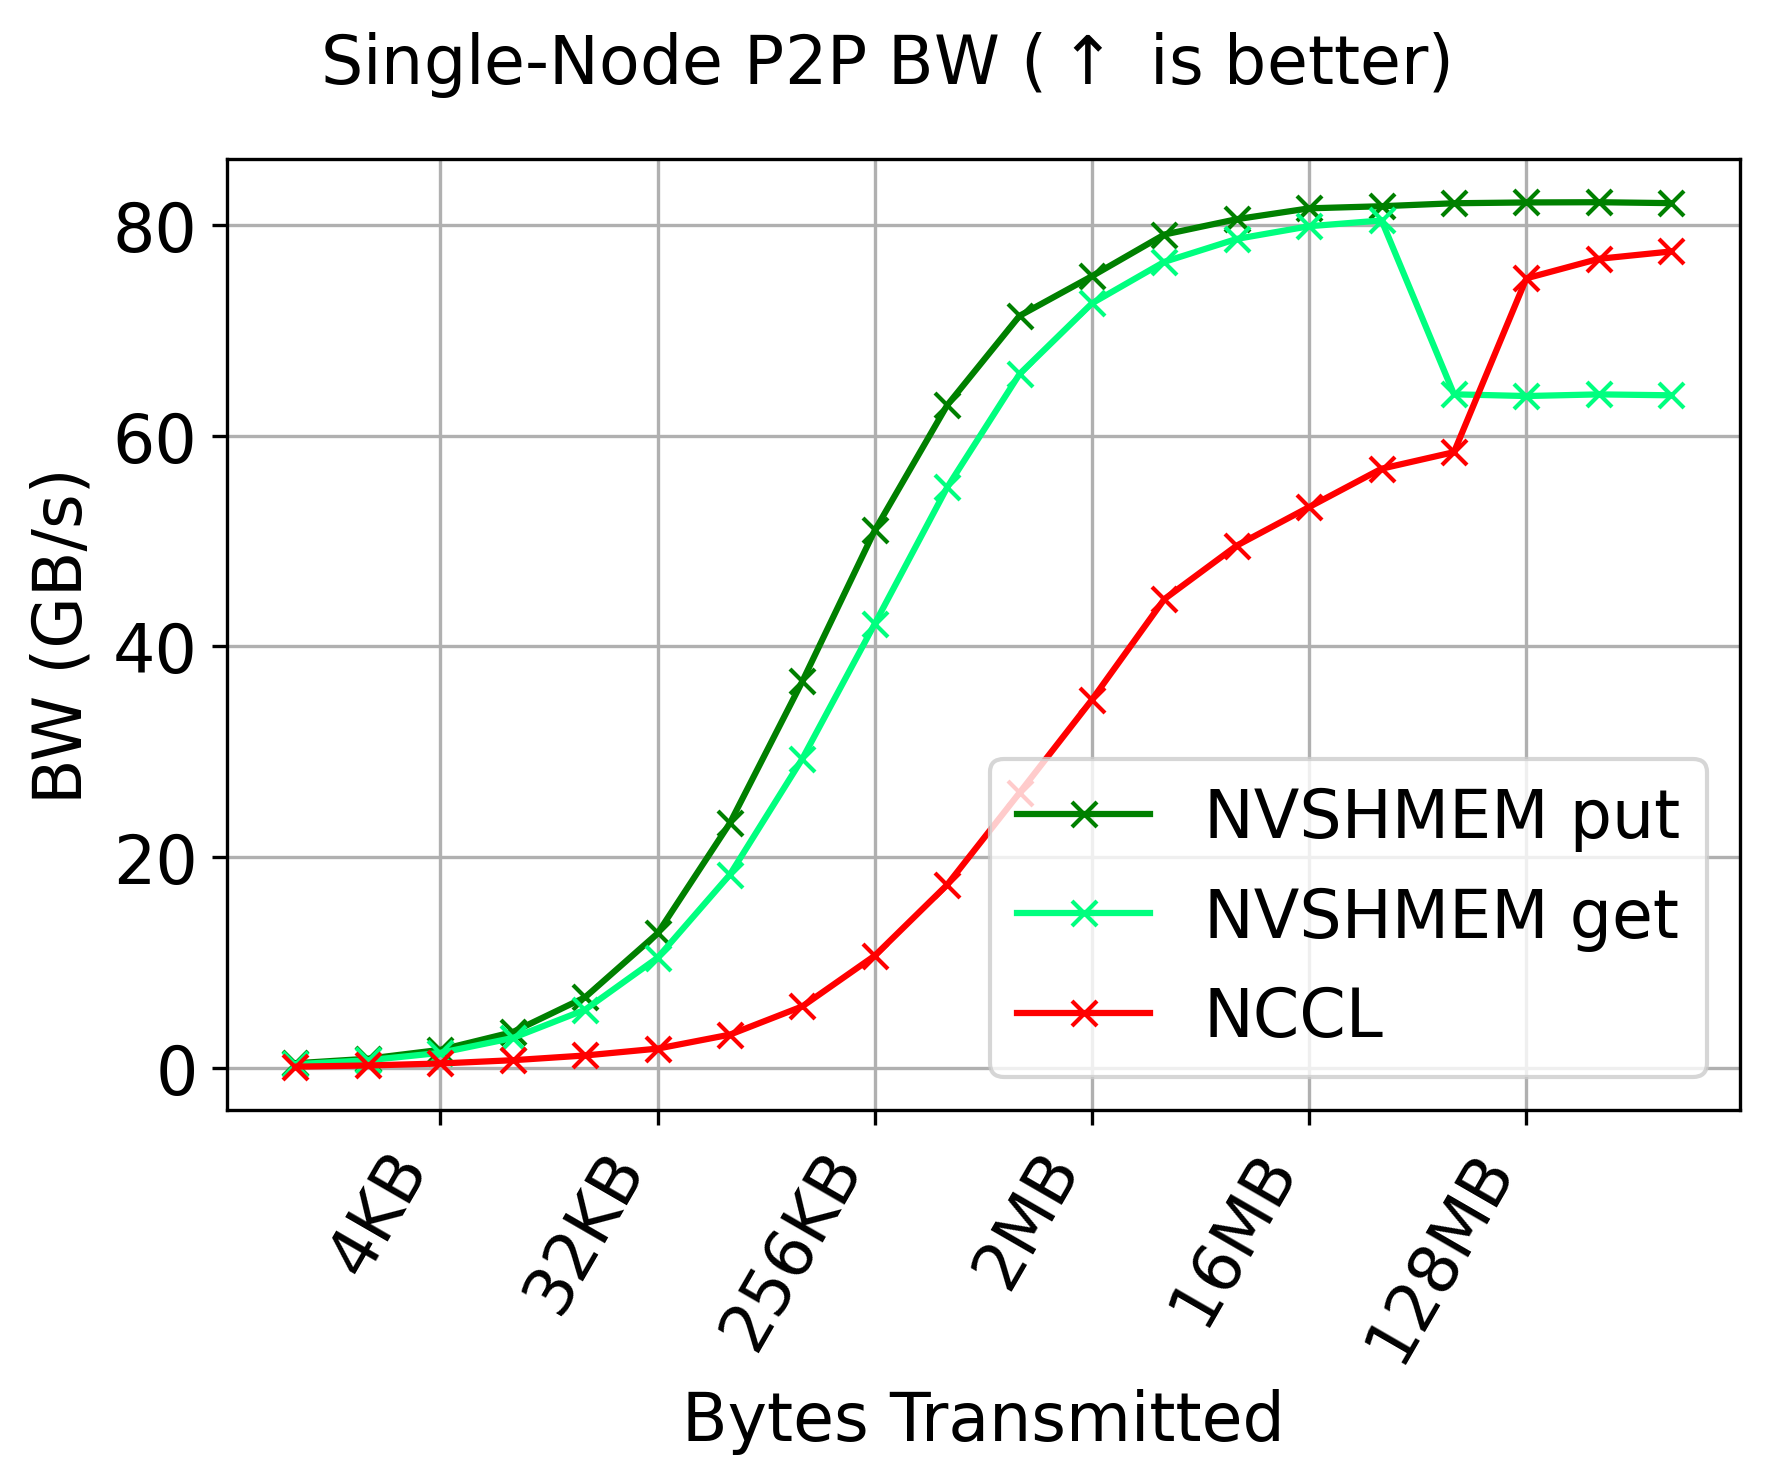

In [112]:
first = 0
second = len(s_bw_data)
nccl_offset = 7
single_plot(s_bw_data[first:second],
            [s_put_bw[first:second], s_get_bw[first:second], single_nccl_bw[nccl_offset + first:nccl_offset + second]],
            header = r"Single-Node P2P BW ($\uparrow$ is better)",
            x_title = "Bytes Transmitted", y_title = "BW (GB/s)",
            out_name = "nccl_v_nvsh_s_bw.pdf", n_plots = 3,
            labels = [r"NVSHMEM put", r"NVSHMEM get", r"NCCL"], color = ["green", "springgreen", "red"],
            plot_marker = "x", x_rotation = 60, x_func_formatter = fmt_bytes, x_scale = 'log', header_font_size=16, axis_font_size=16)

In [113]:
s_nvsh_data_sizes, s_put_latency = parse_nvshmem_times("data/one_sided/single_node_80GB/put_lat.txt",
                                                   delimiter_regex=r"[^(\s+)\|]+",
                                                   skip=123, time_unit='us',
                                                   read_limit=24)

['8', '2.822400']
['16', '2.671200']
['32', '2.669760']
['64', '2.670240']
['128', '2.671840']
['256', '2.667040']
['512', '2.664960']
['1024', '2.706240']
['2048', '2.706240']
['4096', '2.741440']
['8192', '2.848160']
['16384', '3.030560']
['32768', '3.555040']
['65536', '4.558560']
['131072', '6.632800']
['262144', '10.828640']
['524288', '18.988960']
['1048576', '35.336960']
['2097152', '67.764000']
['4194304', '132.783356']
['8388608', '262.470551']
['16777216', '521.744141']
['33554432', '1134.508179']
['67108864', '2592.458984']


In [114]:
_, s_get_latency = parse_nvshmem_times("data/one_sided/single_node_80GB/get_lat.txt",
                                                   delimiter_regex=r"[^(\s+)\|]+",
                                                   skip=123, time_unit='us',
                                                   read_limit=25)

['8', '3.282720']
['16', '3.147040']
['32', '3.172160']
['64', '3.148480']
['128', '3.149600']
['256', '3.148000']
['512', '3.152960']
['1024', '3.160480']
['2048', '3.196480']
['4096', '3.217600']
['8192', '3.282080']
['16384', '3.476000']
['32768', '4.309600']
['65536', '5.710240']
['131072', '8.392160']
['262144', '13.719200']
['524288', '24.504002']
['1048576', '45.516319']
['2097152', '88.115196']
['4194304', '173.084167']
['8388608', '342.920319']
['16777216', '681.882080']
['WARN:', 'FI_CXI_OPTIMIZED_MRS', 'is', 'set.', 'This', 'may', 'cause', 'a', 'hang', 'at', 'runtime', 'if', 'the', 'value', 'is', 'not', '0.']
['33554432', '1360.554810']
['67108864', '3713.168213']


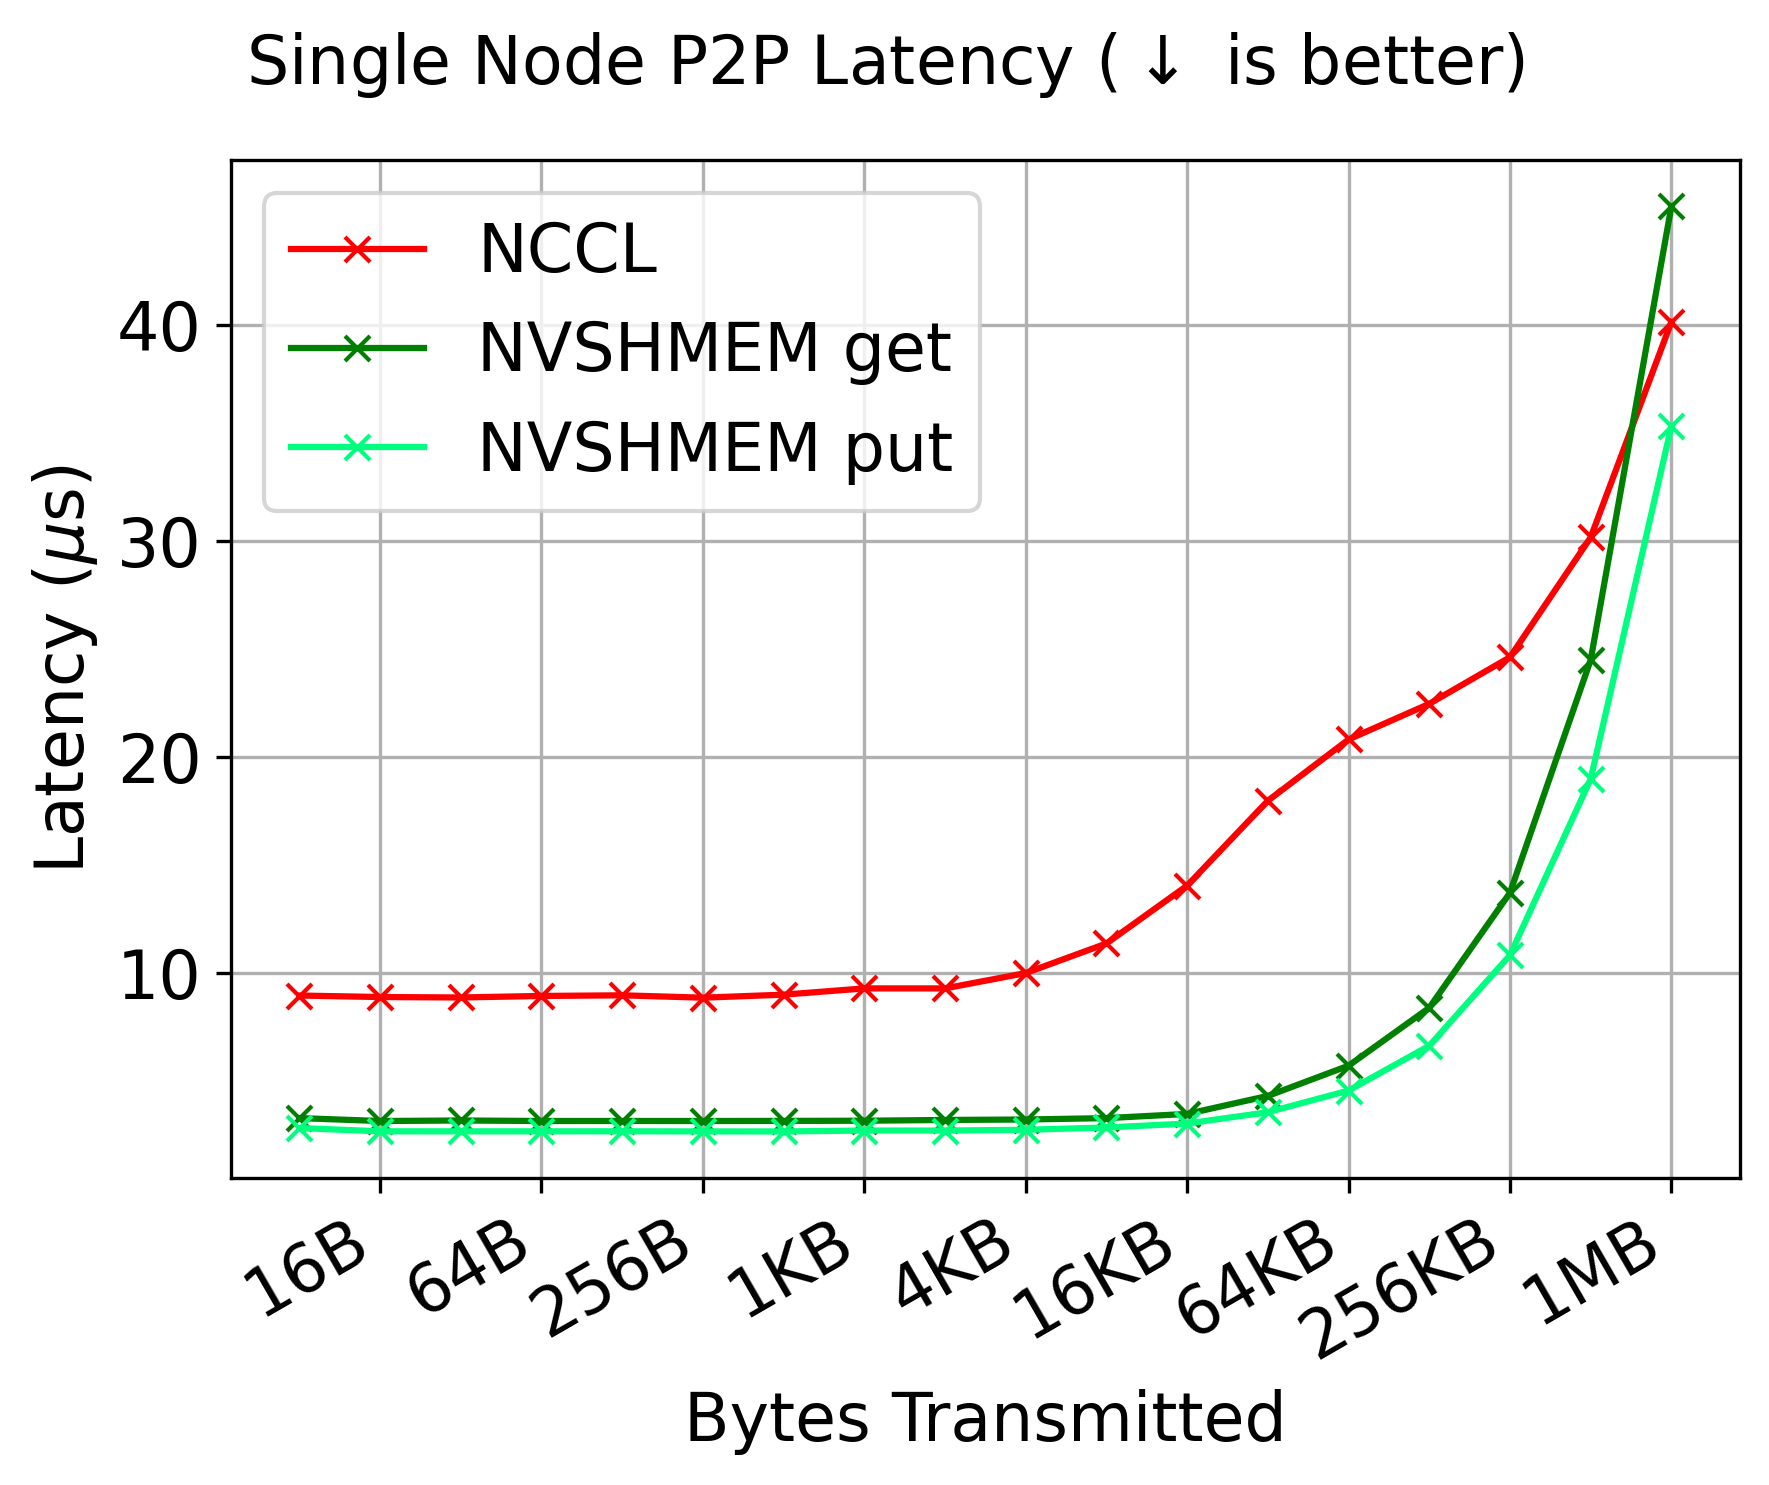

In [115]:
first = 0
# second = len(data_sizes)
second = 18
single_plot(s_nvsh_data_sizes[first:second], [single_nccl_latency[first:second], s_get_latency[first:second], s_put_latency[first:second],], 
            header=r"Single Node P2P Latency ($\downarrow$ is better)", 
            x_title="Bytes Transmitted", y_title=r"Latency ($\mu$s)",
            out_name="nccl_v_nvsh_s_lat_left", n_plots=3,
            labels=[r"NCCL", r"NVSHMEM get", r"NVSHMEM put"], color=["red", "green", "springgreen"], 
            plot_marker="x", x_rotation=30, x_scale='log', x_func_formatter=fmt_bytes, header_font_size=16, axis_font_size=16)

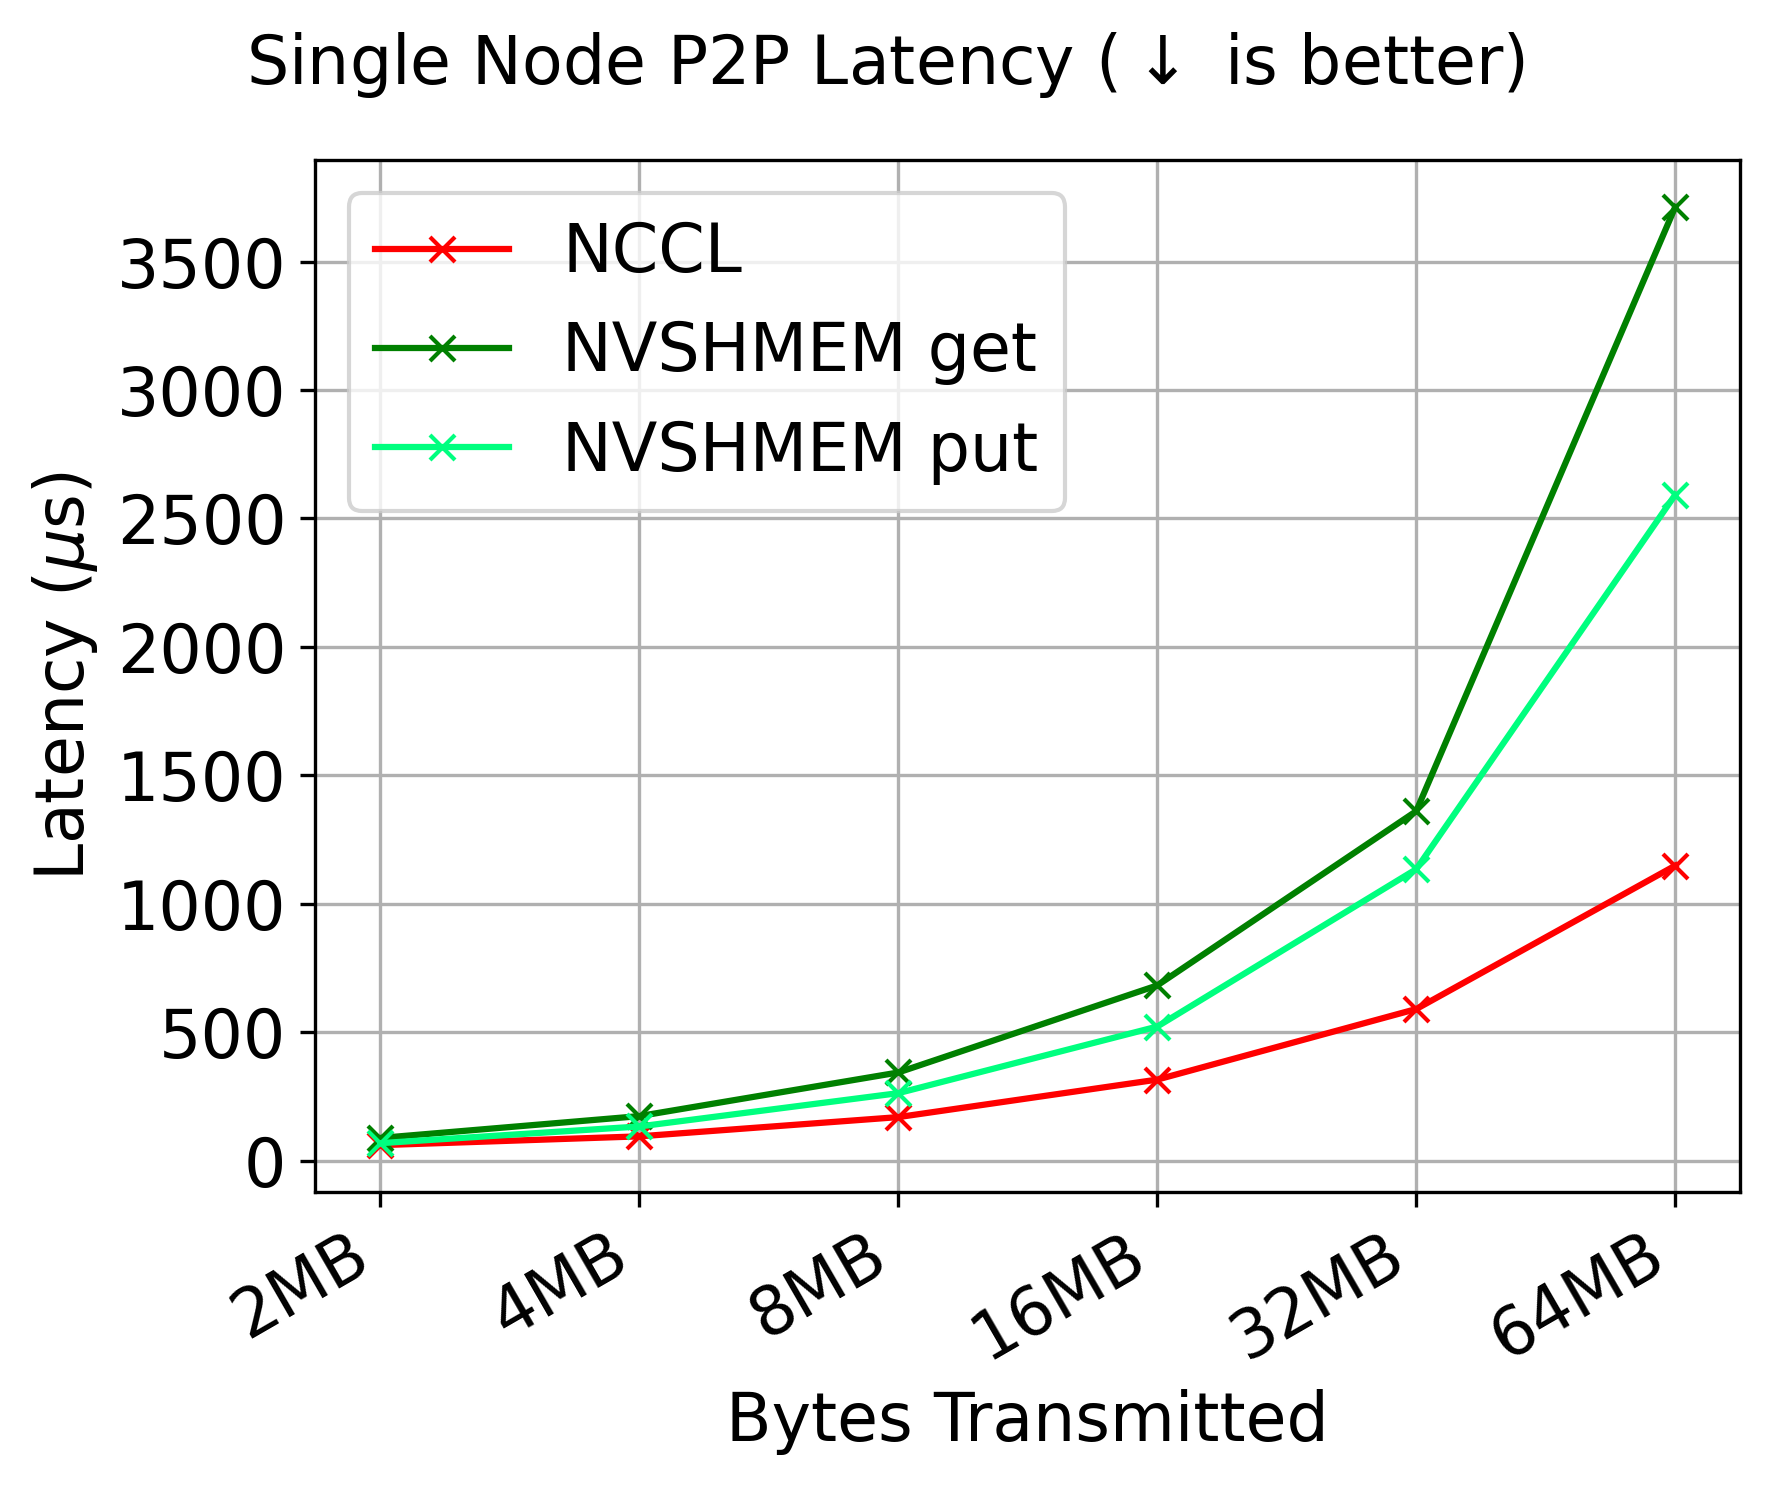

In [116]:
first = 18
second = len(s_nvsh_data_sizes)
single_plot(s_nvsh_data_sizes[first:second], [single_nccl_latency[first:second], s_get_latency[first:second], s_put_latency[first:second]], 
            header=r"Single Node P2P Latency ($\downarrow$ is better)", 
            x_title="Bytes Transmitted", y_title=r"Latency ($\mu$s)",
            out_name="nccl_v_nvsh_s_lat_right.pdf", n_plots=3,
            labels=[r"NCCL", r"NVSHMEM get", r"NVSHMEM put"], color=["red", "green", "springgreen"], 
            plot_marker="x", x_rotation=30, x_func_formatter=fmt_bytes, x_scale='log', x_ticks=s_nvsh_data_sizes[first:second], header_font_size=16, axis_font_size=16)

## Case Study MoE execution

# Non-blocking Latency

In [96]:
nbi_data, nbi_lat = parse_nvshmem_times("data/one_sided/fourXfour_nodes_80GB/nbi_put.txt",
                                        delimiter_regex=r"[^(\s+)\|]+",
                                        skip=7,
                                        read_limit=25)

['4', '0.836160']
['8', '0.830240']
['16', '0.832800']
['32', '0.771040']
['64', '0.734400']
['128', '0.735040']
['256', '0.744160']
['512', '0.832640']
['1024', '0.734880']
['2048', '0.820640']
['4096', '0.832640']
['8192', '0.781280']
['16384', '0.735680']
['32768', '0.735200']
['65536', '0.737280']
['131072', '0.733920']
['262144', '0.824480']
['524288', '0.763200']
['1048576', '0.737440']
['2097152', '0.734880']
['4194304', '0.758240']
['8388608', '0.834880']
['16777216', '0.834400']
['33554432', '0.737760']
['67108864', '0.736320']


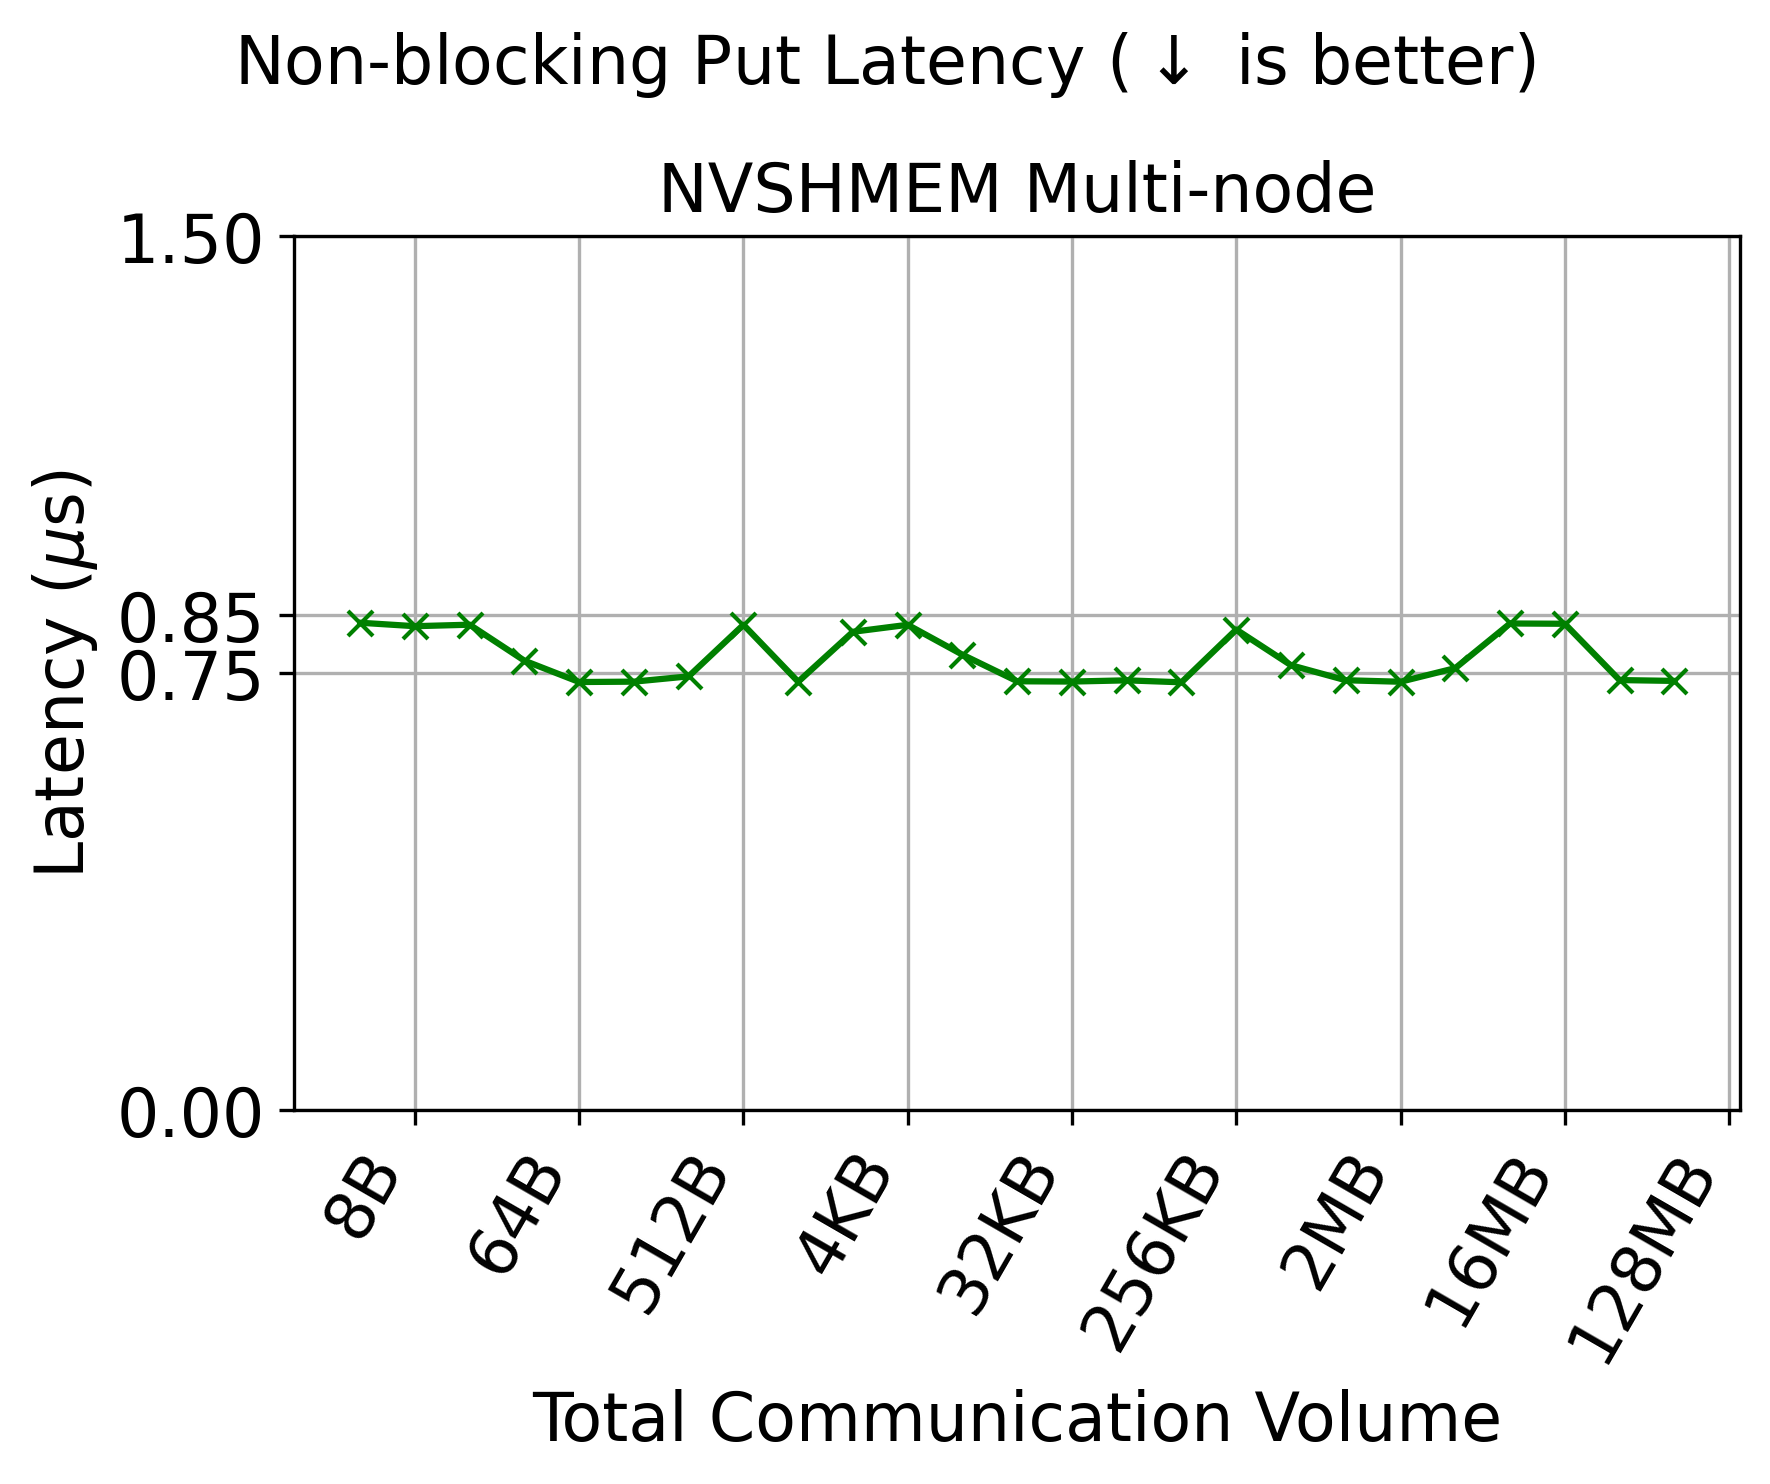

In [117]:
first = 0
second = len(nbi_data)
single_plot(nbi_data[first:second], 
            nbi_lat[first:second], 
            header=r"Non-blocking Put Latency ($\downarrow$ is better)", 
            x_title="Total Communication Volume", y_title=r"Latency ($\mu$s)",
            out_name="nvsh_nbi_lat.pdf", n_plots=1, color=["green"], x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log', 
            y_ticks=[0, 0.75, 0.85, 1.5], header_font_size=16, axis_font_size=16, plot_marker='x', sub_title='NVSHMEM Multi-node')

In [49]:
def fmt_secs(y, pos):
    if 60 <= y < 3600:
        return "{:.1f}mins".format(y / 60)
    if y >= 1:
        return "{:.1f}s".format(y)
    return "{:.1f}ms".format(y * 1000)

def fmt_twos(x, pos):
    return "{:d}".format(int(x))

Note Lysi's times will significantly improve when reimplemented with Cython rather than its current Python.
Alpa's results are collected from the paper.

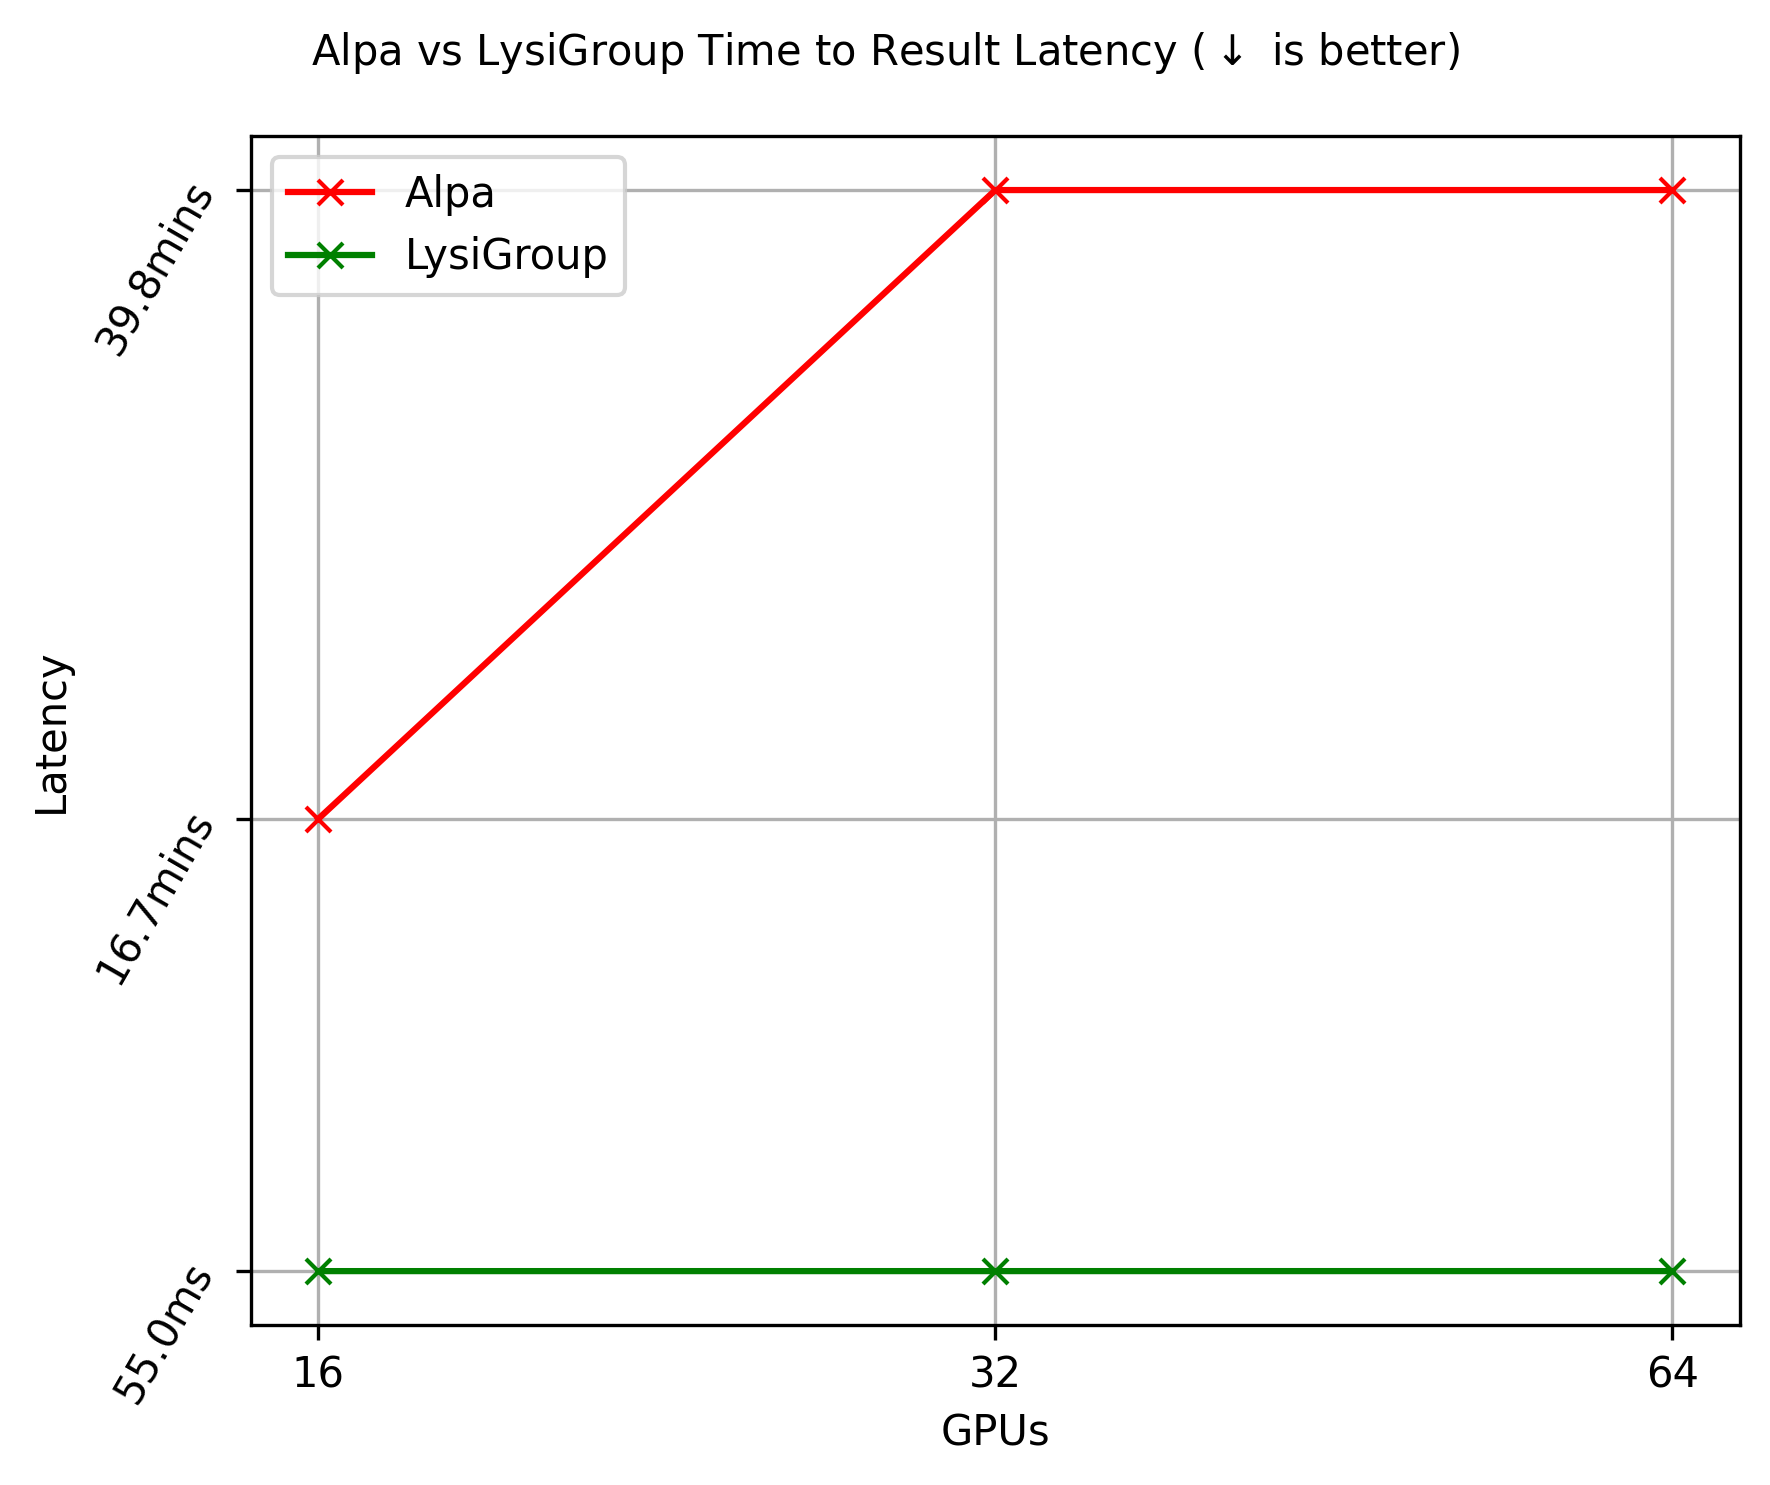

In [50]:
gpus = [16, 32, 64]
alpa_times = [1000, 2390, 2390]
aristos_times = [0.00144, 0.022, 0.055]
single_plot(gpus, 
            [alpa_times, aristos_times], 
            header=r"Alpa vs LysiGroup Time to Result Latency ($\downarrow$ is better)", 
            x_title="GPUs", y_title=r"Latency",
            out_name="alpa_v_lysi_group", n_plots=2,
            labels=[r"Alpa", r"LysiGroup"], color=["red", "green"], 
            plot_marker="x", y_func_formatter=fmt_secs, x_func_formatter=fmt_twos,
            x_scale='log', y_ticks=[0.055, 1000, 2390], y_rotation=60)

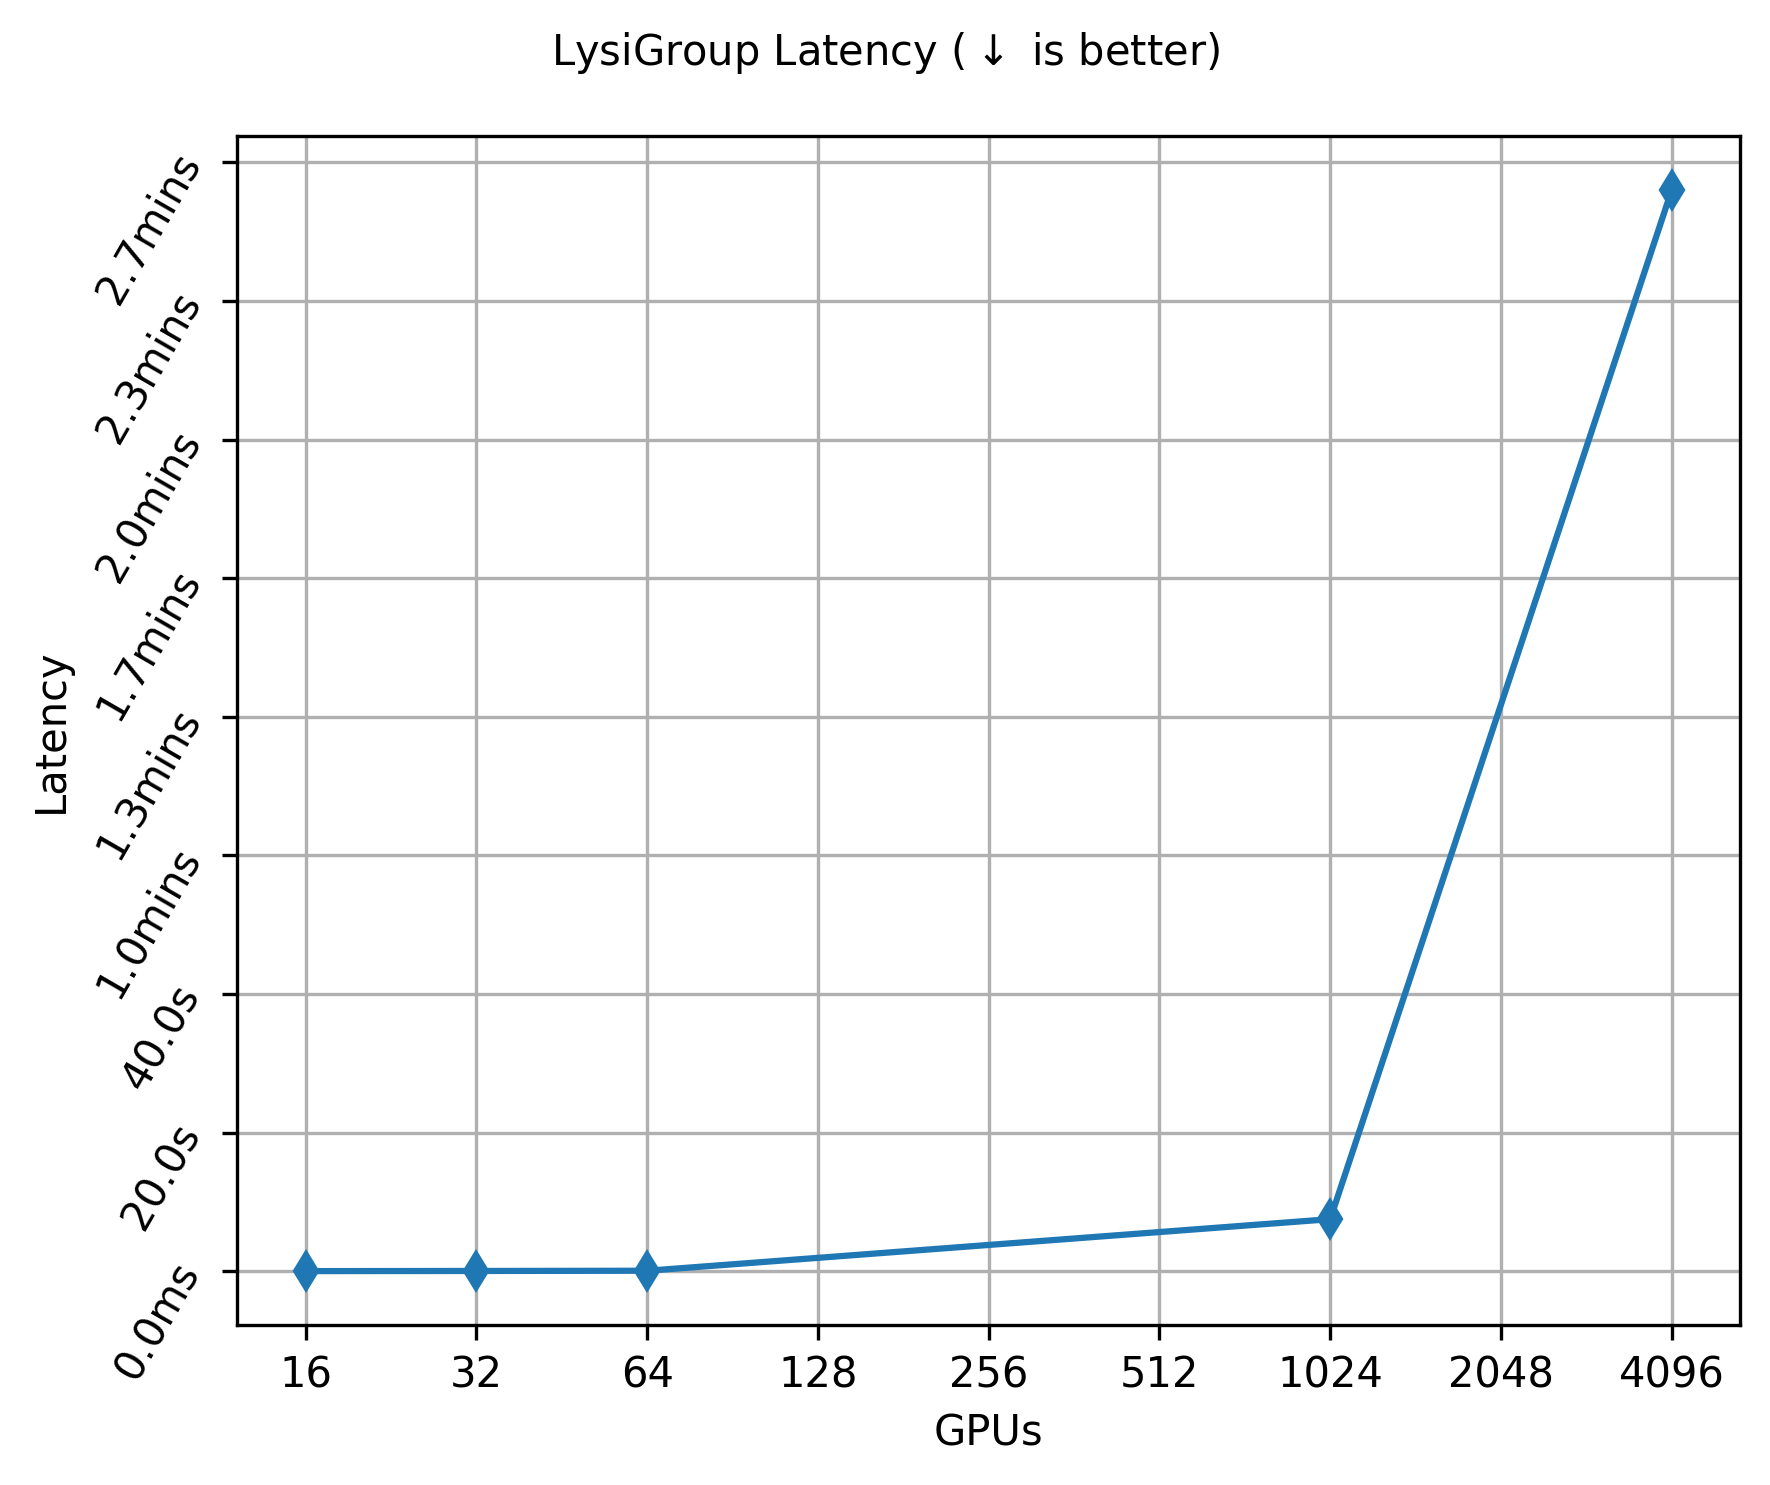

In [51]:
gpus = [16, 32, 64, 1024, 4096]
aristos_times = [0.00144, 0.022, 0.055, 7.5, 156]
single_plot(gpus, 
            aristos_times, 
            header=r"LysiGroup Latency ($\downarrow$ is better)", 
            x_title="GPUs", y_title=r"Latency",
            out_name="lysi_group_lat", n_plots=1, y_func_formatter=fmt_secs, x_func_formatter=fmt_twos,
            x_scale='log', y_rotation=60, x_ticks=gpus)

## NVSHMEM Broadcast Bug
Reported [here](https://forums.developer.nvidia.com/t/broadcast-algorithm-detection-anomaly/293981) and resolved [here](https://docs.nvidia.com/nvshmem/release-notes-install-guide/release-notes/release-3006.html#fixed-issues)

### Multi-Node
2x4 Perlmutter GPU 80GB Nodes

In [6]:
data_32_block, bcast_latency_32 = parse_nvshmem_times("data/bcast_investigation/bcast_bug.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=77, time_unit='us',
                                     read_limit=19)

['4', '21.592641']
['8', '3.660480']
['16', '3.568640']
['32', '3.578560']
['64', '3.572480']
['128', '3.577920']
['256', '3.486400']
['512', '3.495360']
['1024', '4.637120']
['2048', '3.571840']
['4096', '3.898240']
['8192', '5.213120']
['16384', '23.888960']
['32768', '30.526080']
['65536', '36.181760']
['131072', '53.218241']
['262144', '82.549763']
['524288', '139.406404']
['1048576', '256.708794']


In [10]:
fix_data_32_block, fix_bcast_latency_32 = parse_nvshmem_times("data/bcast_investigation/bcast_fix.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=77, time_unit='us',
                                     read_limit=19)

['4', '32.331200']
['8', '3.672320']
['16', '3.652160']
['32', '3.573120']
['64', '3.569920']
['128', '3.496000']
['256', '3.494080']
['512', '3.495040']
['1024', '4.632640']
['2048', '3.571200']
['4096', '3.816320']
['8192', '5.218240']
['16384', '8.081920']
['32768', '11.928639']
['65536', '34.214079']
['131072', '66.735358']
['262144', '135.466881']
['524288', '274.894714']
['1048576', '563.418236']


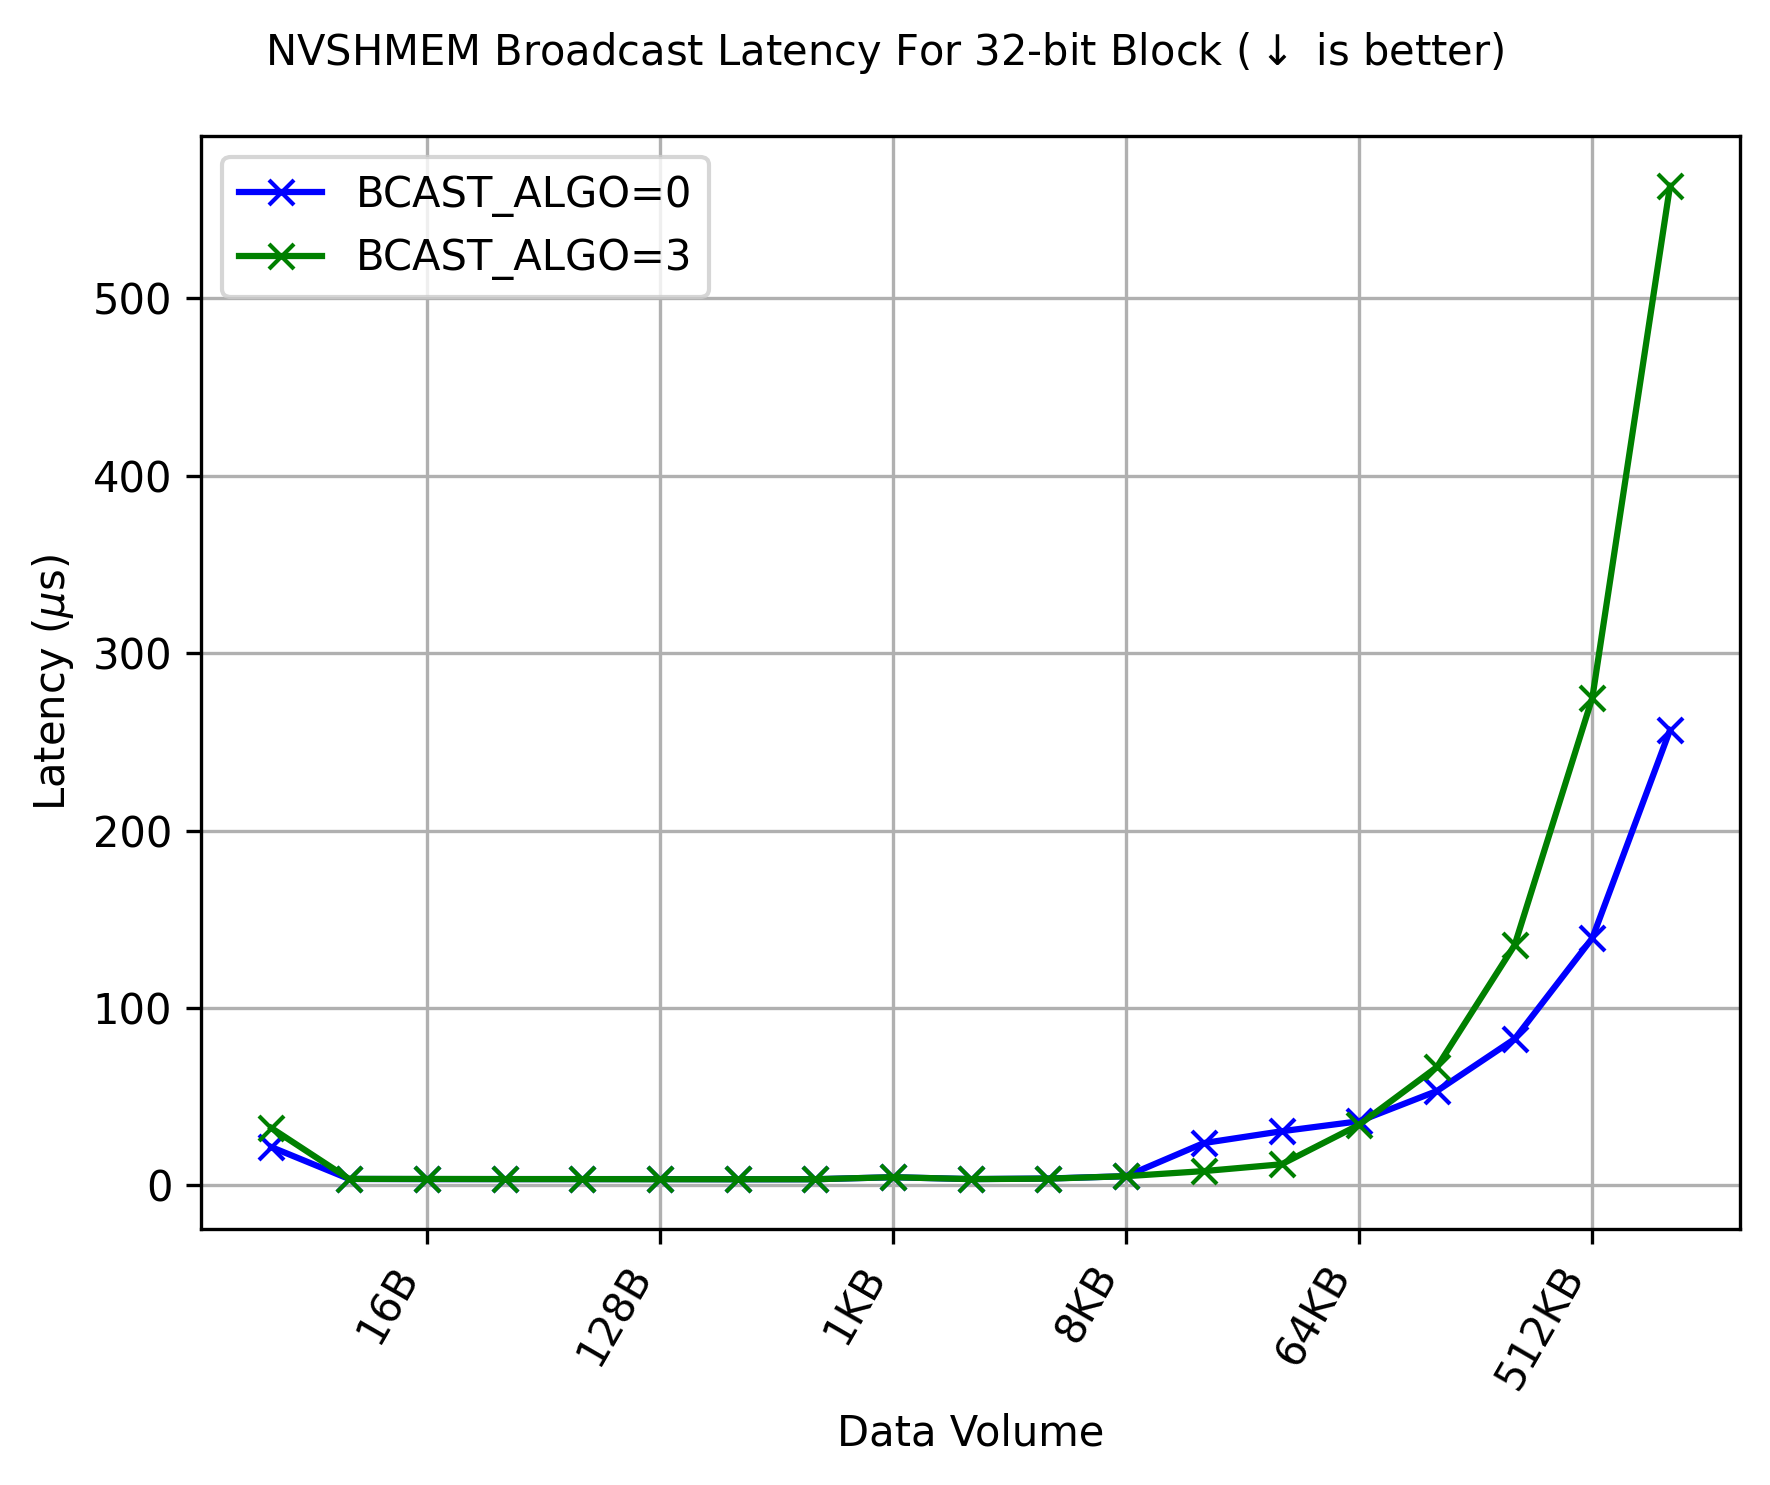

In [43]:
single_plot(fix_data_32_block, 
            [bcast_latency_32, fix_bcast_latency_32], 
            header=r"NVSHMEM Broadcast Latency For 32-bit Block ($\downarrow$ is better)", 
            x_title="Data Volume", y_title=r"Latency ($\mu$s)",
            out_name="nvsh_bcast_32_block", n_plots=2,
            labels=[r"BCAST_ALGO=0", r"BCAST_ALGO=3"], color=["blue", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log')

In [7]:
data_64_warp, bcast_latency_64_warp = parse_nvshmem_times("data/bcast_investigation/bcast_bug.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=147, time_unit='us',
                                     read_limit=12)

['8', '21.267200']
['16', '3.491200']
['32', '3.487680']
['64', '3.497600']
['128', '3.490240']
['256', '3.498880']
['512', '3.655680']
['1024', '4.562880']
['2048', '5.044480']
['4096', '6.933760']
['8192', '12.742400']
['16384', '44.210882']


In [11]:
fix_data_64_warp, fix_bcast_latency_64_warp = parse_nvshmem_times("data/bcast_investigation/bcast_fix.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=147, time_unit='us',
                                     read_limit=12)

['8', '31.746881']
['16', '3.489280']
['32', '3.496320']
['64', '3.491520']
['128', '3.495360']
['256', '3.491200']
['512', '3.656320']
['1024', '4.144320']
['2048', '5.051520']
['4096', '9.140800']
['8192', '10.698560']
['16384', '24.303360']


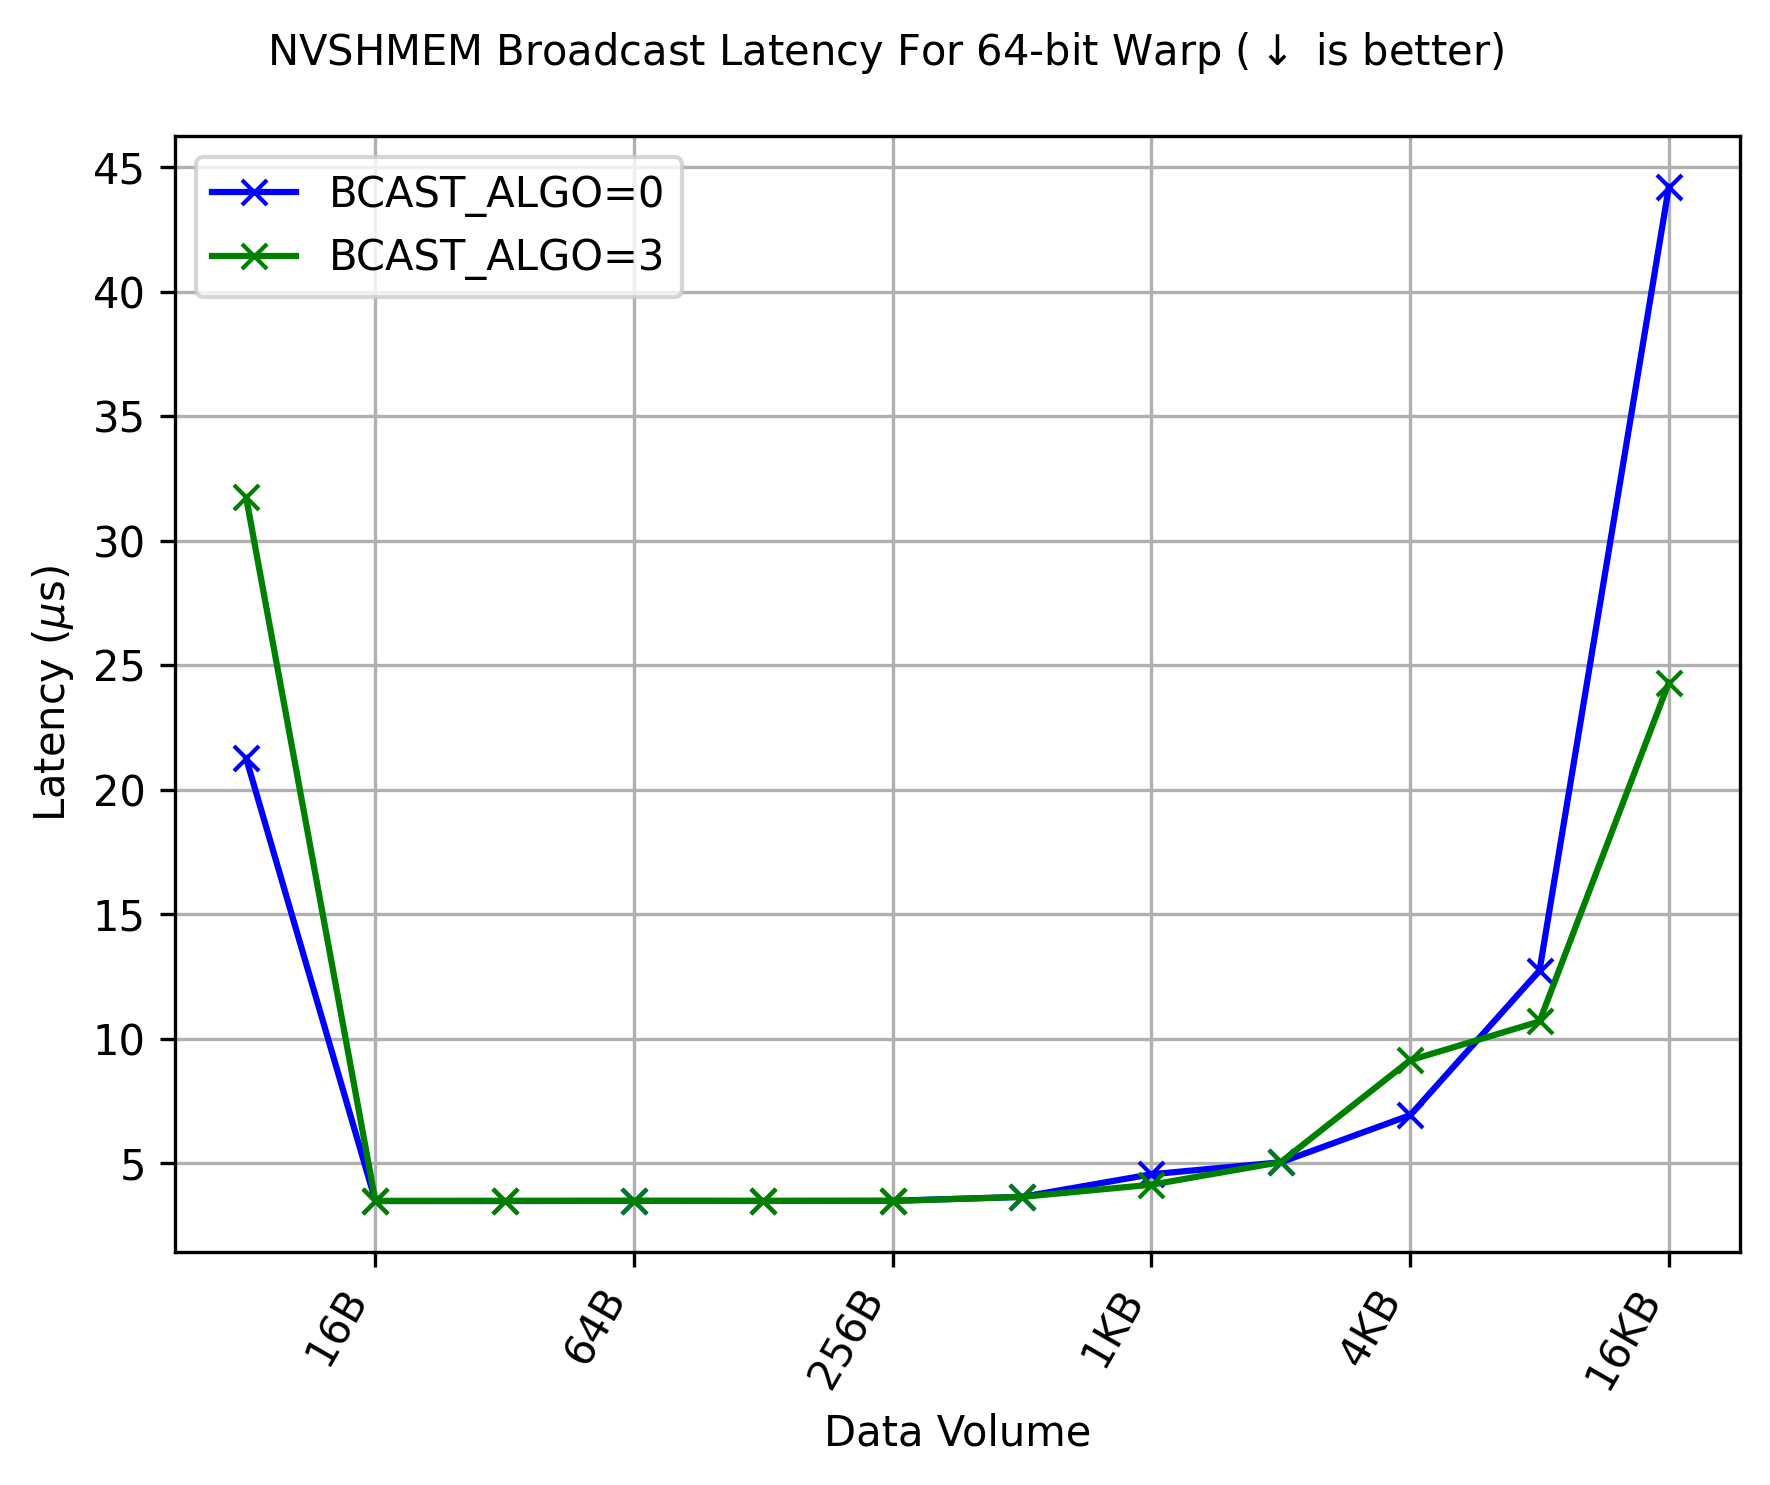

In [44]:
single_plot(fix_data_64_warp, 
            [bcast_latency_64_warp, fix_bcast_latency_64_warp], 
            header=r"NVSHMEM Broadcast Latency For 64-bit Warp ($\downarrow$ is better)", 
            x_title="Data Volume", y_title=r"Latency ($\mu$s)",
            out_name="nvsh_bcast_64_warp", n_plots=2,
            labels=[r"BCAST_ALGO=0", r"BCAST_ALGO=3"], color=["blue", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log')

In [8]:
data_64_block, bcast_latency_64_block = parse_nvshmem_times("data/bcast_investigation/bcast_bug.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=178, time_unit='us',
                                     read_limit=19)

['8', '21.173840']
['16', '4.156320']
['32', '4.172720']
['64', '4.182960']
['128', '4.149640']
['256', '4.130640']
['512', '4.094920']
['1024', '4.122160']
['2048', '4.210320']
['4096', '4.714880']
['8192', '6.034040']
['16384', '23.594880']
['32768', '26.833601']
['65536', '34.674282']
['131072', '49.943724']
['262144', '81.061878']
['524288', '139.699802']
['1048576', '258.655643']
['2097152', '498.285027']


In [12]:
fix_data_64_block, fix_bcast_latency_64_block = parse_nvshmem_times("data/bcast_investigation/bcast_fix.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=178, time_unit='us',
                                     read_limit=19)

['8', '31.667399']
['16', '4.184160']
['32', '4.148360']
['64', '4.148440']
['128', '4.105800']
['256', '4.106920']
['512', '4.054080']
['1024', '4.131280']
['2048', '5.001600']
['4096', '4.395440']
['8192', '5.870800']
['16384', '7.085280']
['32768', '11.941321']
['65536', '34.481320']
['131072', '65.086117']
['262144', '134.492035']
['524288', '273.858719']
['1048576', '556.006775']
['2097152', '854.729004']


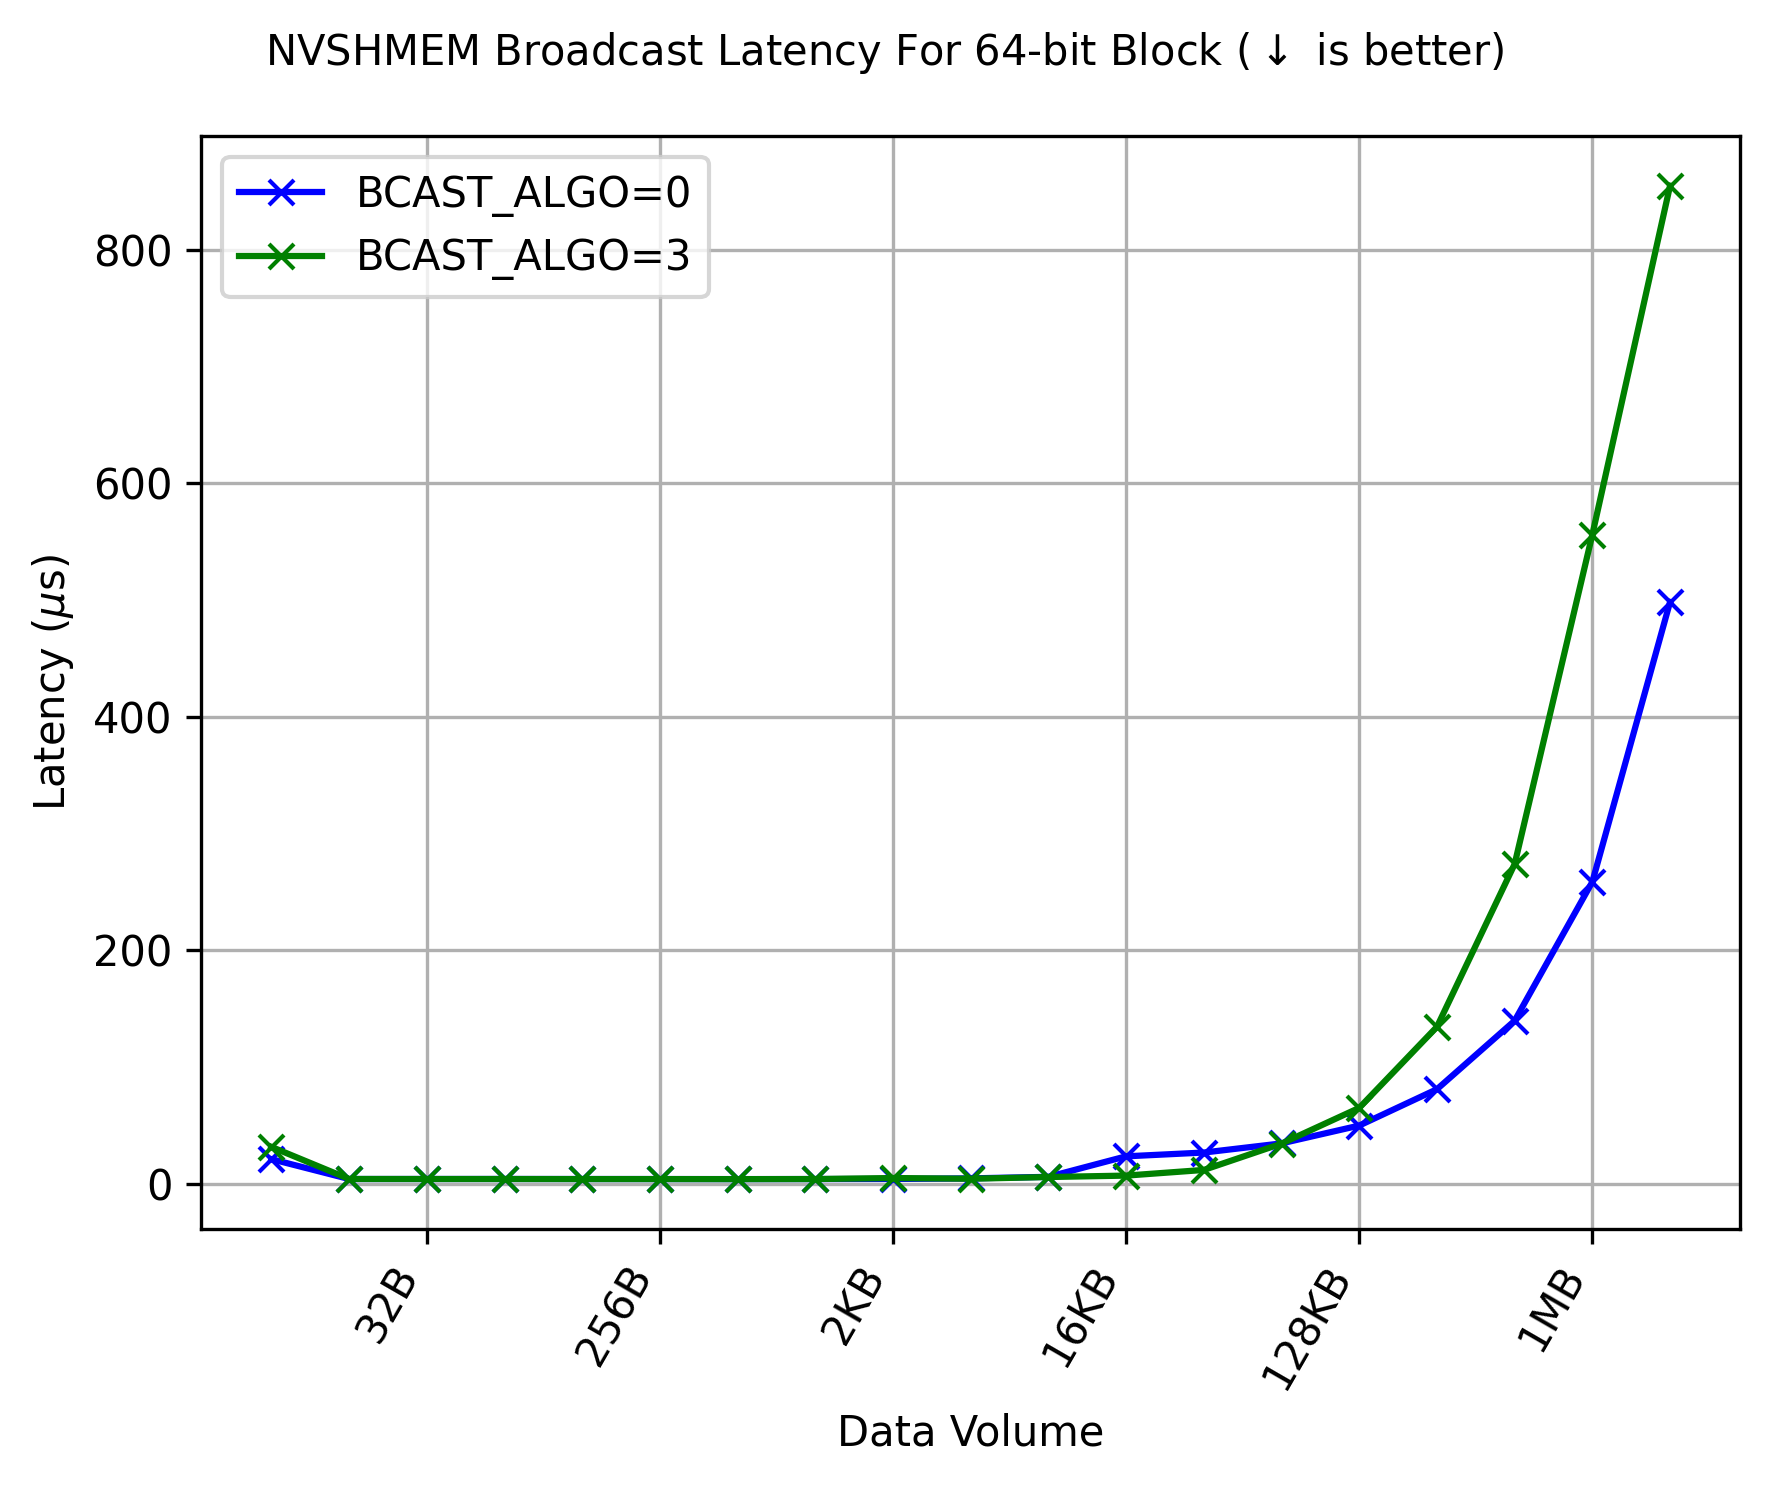

In [45]:
single_plot(fix_data_64_block, 
            [bcast_latency_64_block, fix_bcast_latency_64_block], 
            header=r"NVSHMEM Broadcast Latency For 64-bit Block ($\downarrow$ is better)", 
            x_title="Data Volume", y_title=r"Latency ($\mu$s)",
            out_name="nvsh_bcast_64_block", n_plots=2,
            labels=[r"BCAST_ALGO=0", r"BCAST_ALGO=3"], color=["blue", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log')

### Single Node

In [30]:
s_data_32_block, s_bcast_latency_32 = parse_nvshmem_times("data/bcast_investigation/bcast_single_bug.txt",
                                                          delimiter_regex=r"[^(\s+)\|]+",
                                                          skip=69, time_unit='us',
                                                          read_limit=19)

['4', '14.386560']
['8', '3.671680']
['16', '3.584960']
['32', '3.585600']
['64', '3.578240']
['128', '3.582400']
['256', '3.497600']
['512', '3.490240']
['1024', '3.576000']
['2048', '3.573120']
['4096', '3.821760']
['8192', '4.391680']
['16384', '16.032000']
['32768', '19.303041']
['65536', '26.437759']
['131072', '41.669440']
['262144', '71.161280']
['524288', '129.404163']
['1048576', '246.219521']


In [31]:
s_fix_data_32_block, s_fix_bcast_latency_32 = parse_nvshmem_times("data/bcast_investigation/bcast_single_fix.txt",
                                                                  delimiter_regex=r"[^(\s+)\|]+",
                                                                  skip=69, time_unit='us',
                                                                  read_limit=19)

['4', '7.261440']
['8', '3.664640']
['16', '3.579840']
['32', '3.580160']
['64', '3.576000']
['128', '3.492800']
['256', '3.498560']
['512', '3.497600']
['1024', '3.576320']
['2048', '3.573440']
['4096', '3.825280']
['8192', '4.405440']
['16384', '5.709120']
['32768', '10.287679']
['65536', '33.963201']
['131072', '68.377280']
['262144', '139.557762']
['524288', '281.294403']
['1048576', '562.424965']


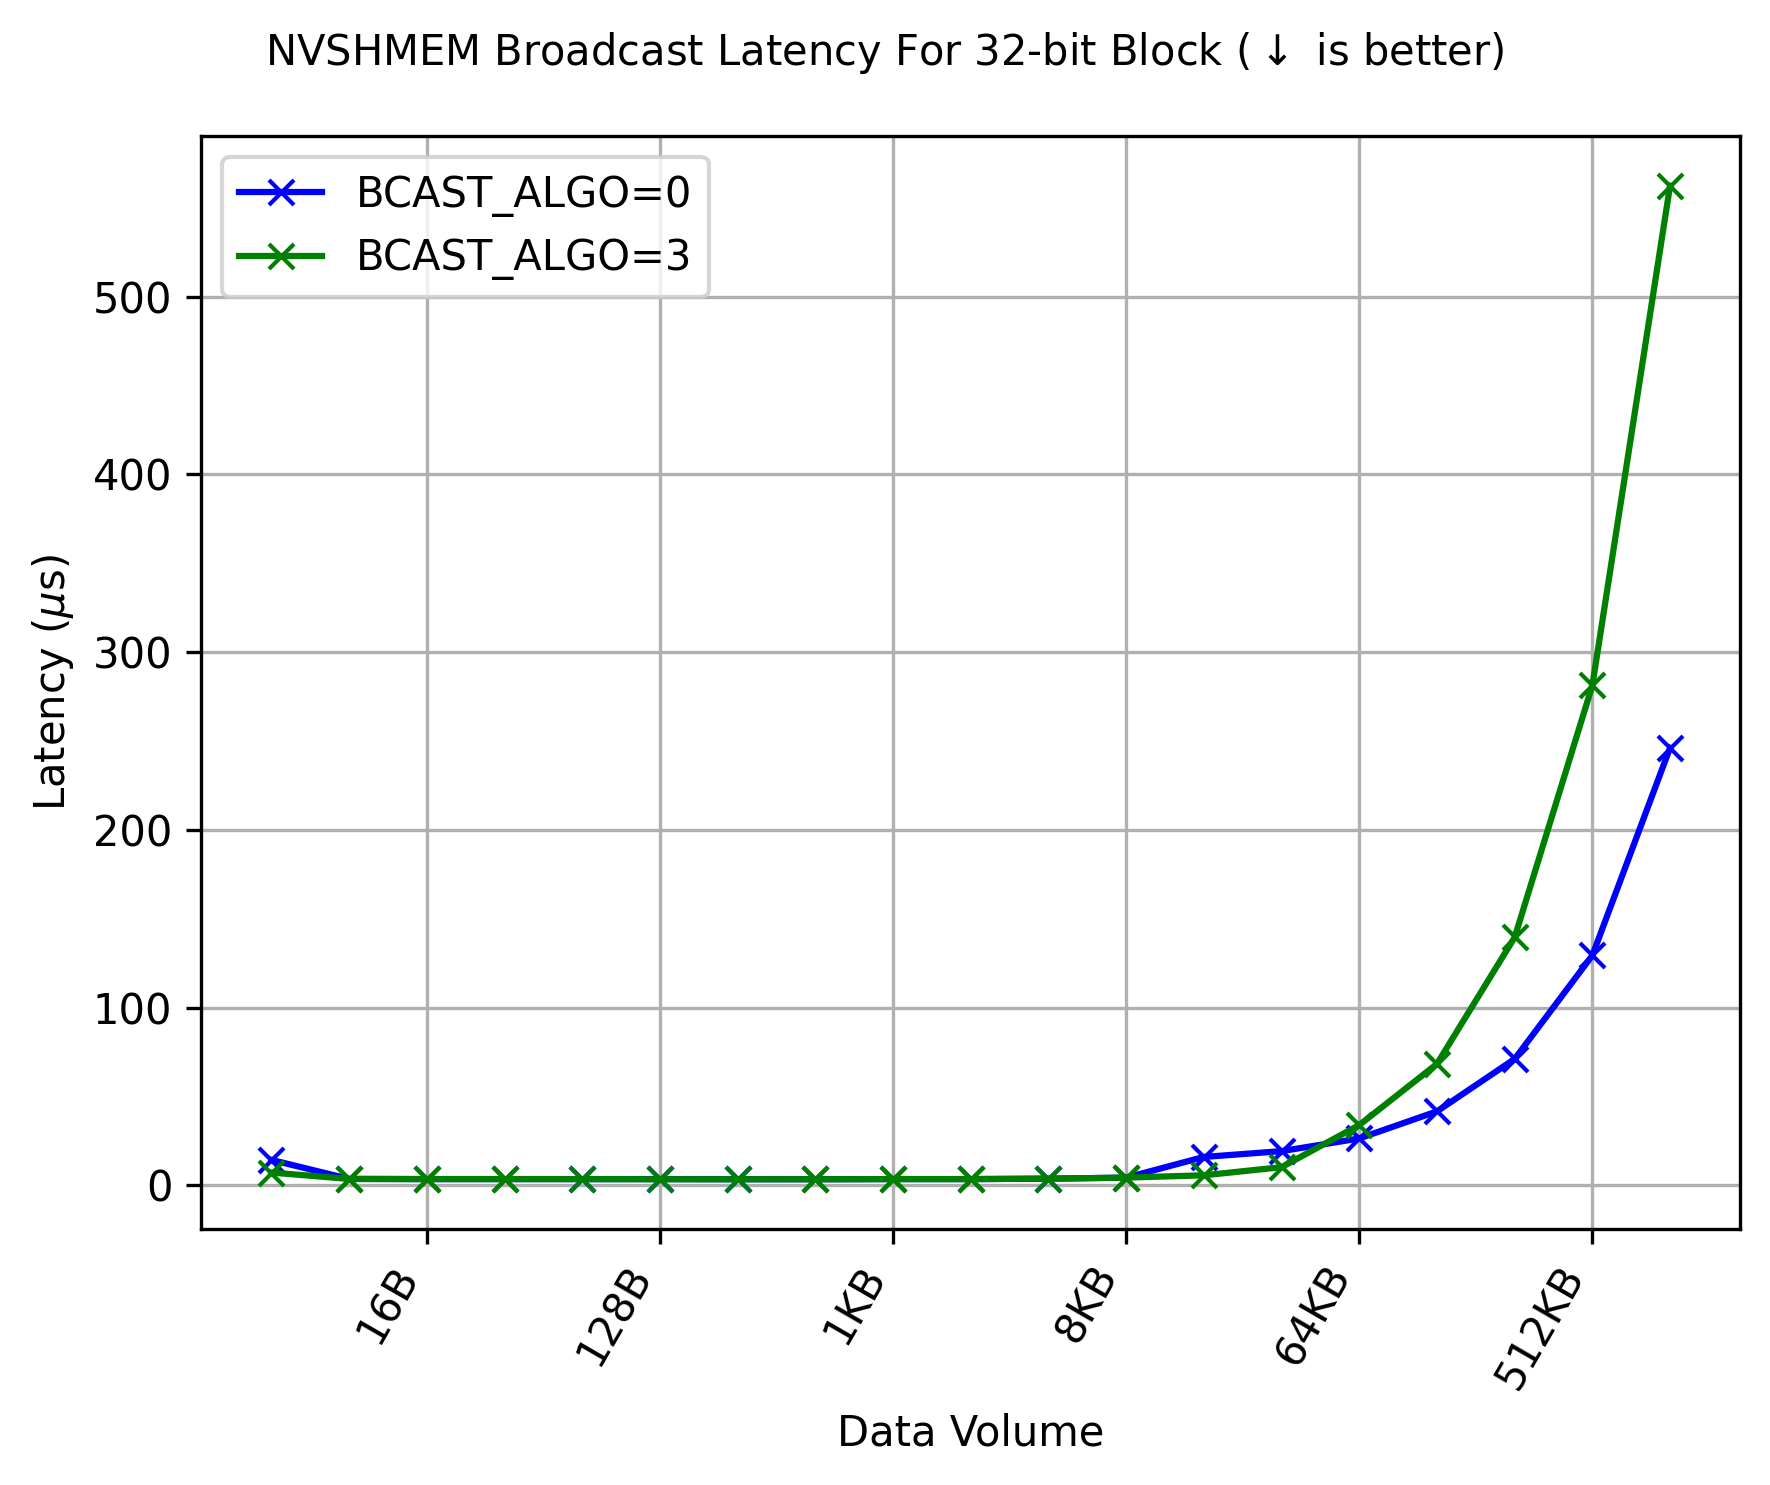

In [46]:
single_plot(s_fix_data_32_block, 
            [s_bcast_latency_32, s_fix_bcast_latency_32], 
            header=r"NVSHMEM Broadcast Latency For 32-bit Block ($\downarrow$ is better)", 
            x_title="Data Volume", y_title=r"Latency ($\mu$s)",
            out_name="nvsh_s_bcast_32_block", n_plots=2,
            labels=[r"BCAST_ALGO=0", r"BCAST_ALGO=3"], color=["blue", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log')

In [33]:
s_data_64_warp, s_bcast_latency_64_warp = parse_nvshmem_times("data/bcast_investigation/bcast_single_bug.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=139, time_unit='us',
                                     read_limit=12)

['8', '13.808960']
['16', '3.494720']
['32', '3.494720']
['64', '3.495040']
['128', '3.409920']
['256', '3.492160']
['512', '3.655040']
['1024', '4.237120']
['2048', '5.064640']
['4096', '6.938240']
['8192', '10.794880']
['16384', '36.595840']


In [34]:
s_fix_data_64_warp, s_fix_bcast_latency_64_warp = parse_nvshmem_times("data/bcast_investigation/bcast_single_fix.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=139, time_unit='us',
                                     read_limit=12)

['8', '7.013120']
['16', '3.493760']
['32', '3.492160']
['64', '3.492800']
['128', '3.486720']
['256', '3.486400']
['512', '3.651520']
['1024', '4.142400']
['2048', '5.053440']
['4096', '7.021440']
['8192', '10.693760']
['16384', '18.398080']


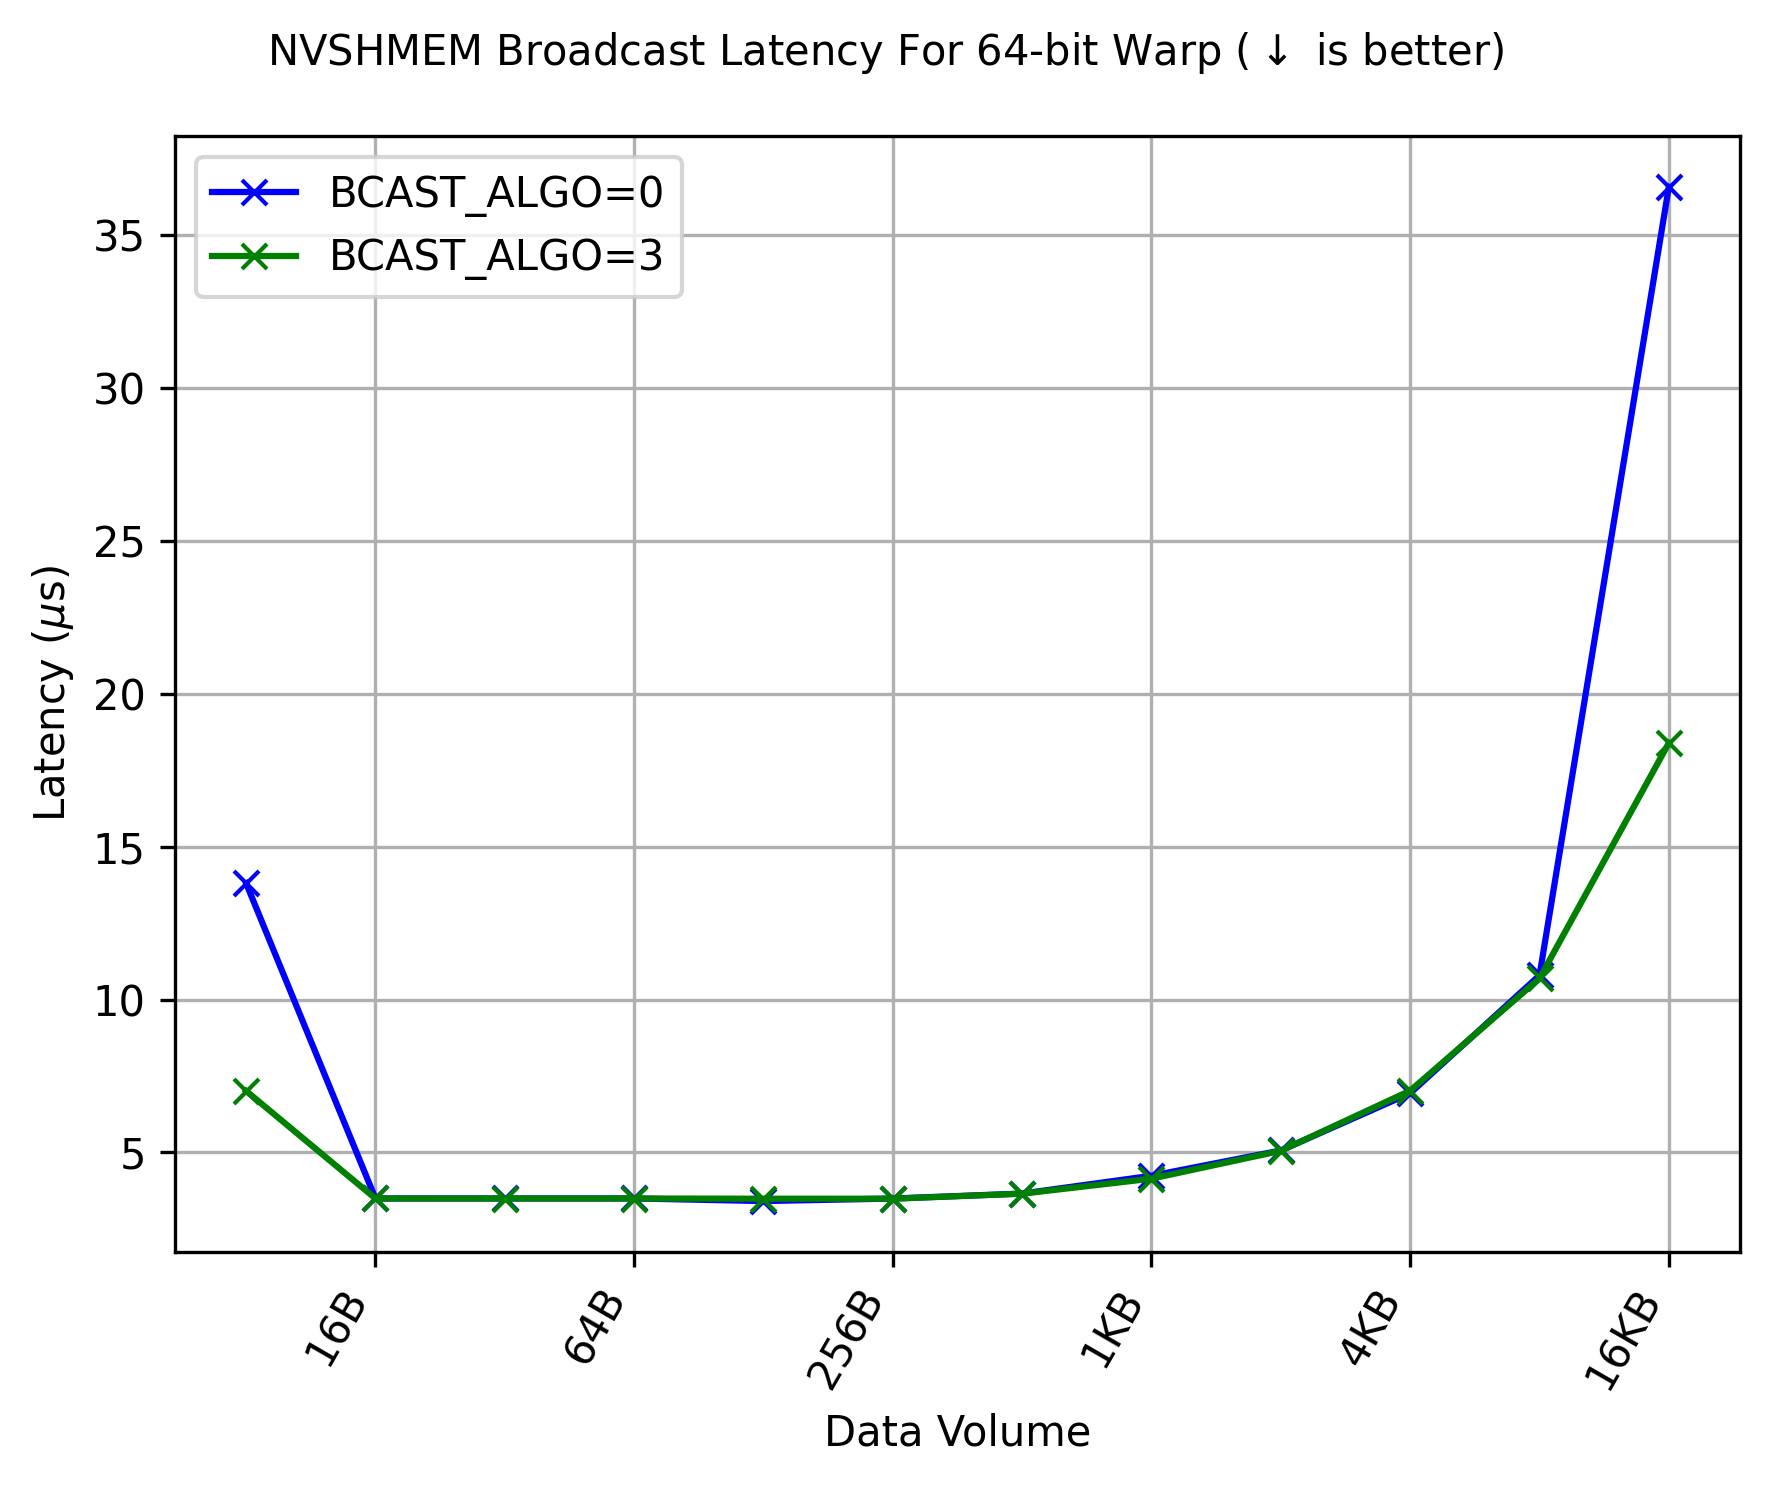

In [47]:
single_plot(s_fix_data_64_warp, 
            [s_bcast_latency_64_warp, s_fix_bcast_latency_64_warp], 
            header=r"NVSHMEM Broadcast Latency For 64-bit Warp ($\downarrow$ is better)", 
            x_title="Data Volume", y_title=r"Latency ($\mu$s)",
            out_name="nvsh_bcast_s_64_warp", n_plots=2,
            labels=[r"BCAST_ALGO=0", r"BCAST_ALGO=3"], color=["blue", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log')

In [38]:
s_data_64_block, s_bcast_latency_64_block = parse_nvshmem_times("data/bcast_investigation/bcast_single_bug.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=170, time_unit='us',
                                     read_limit=19)

['8', '13.948721']
['16', '3.593200']
['32', '3.598560']
['64', '3.583920']
['128', '3.576880']
['256', '3.518160']
['512', '3.492640']
['1024', '3.619440']
['2048', '3.674640']
['4096', '3.989200']
['8192', '4.476960']
['16384', '16.157279']
['32768', '19.346640']
['65536', '26.455441']
['131072', '41.444721']
['262144', '71.265521']
['524288', '129.489279']
['1048576', '246.902313']
['2097152', '481.209030']


In [39]:
s_fix_data_64_block, s_fix_bcast_latency_64_block = parse_nvshmem_times("data/bcast_investigation/bcast_single_fix.txt",
                                     delimiter_regex=r"[^(\s+)\|]+",
                                     skip=170, time_unit='us',
                                     read_limit=19)

['8', '6.679519']
['16', '3.648000']
['32', '3.572880']
['64', '3.572480']
['128', '3.497120']
['256', '3.496960']
['512', '3.488400']
['1024', '3.597040']
['2048', '3.731840']
['4096', '3.897680']
['8192', '4.470400']
['16384', '5.621120']
['32768', '10.292960']
['65536', '34.012721']
['131072', '66.324396']
['262144', '137.264481']
['524288', '277.554970']
['1048576', '559.239273']
['2097152', '475.599060']


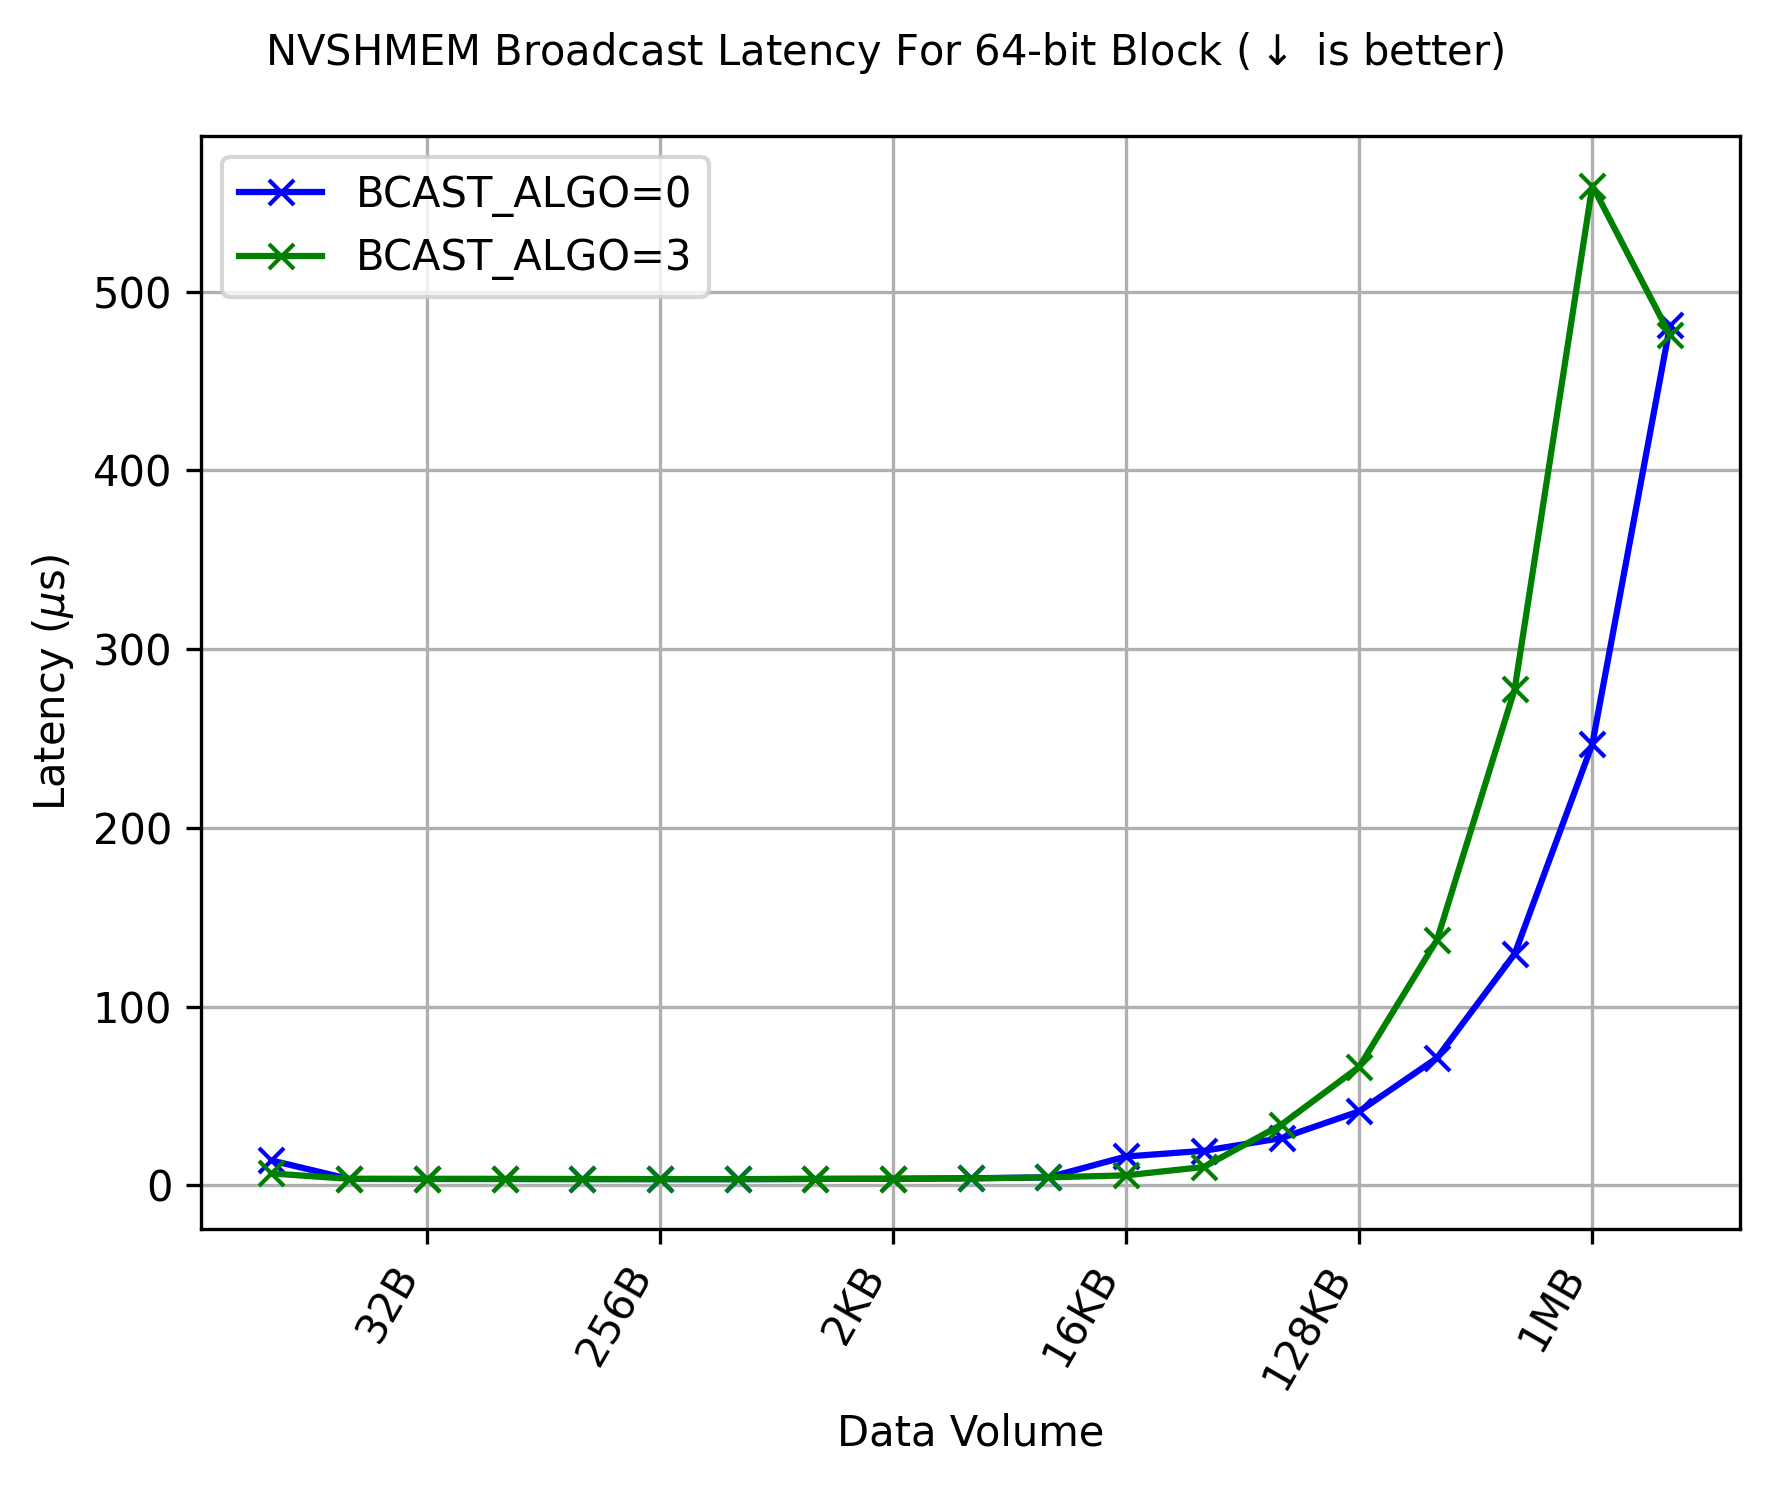

In [42]:
single_plot(s_fix_data_64_block, 
            [s_bcast_latency_64_block, s_fix_bcast_latency_64_block], 
            header=r"NVSHMEM Broadcast Latency For 64-bit Block ($\downarrow$ is better)", 
            x_title="Data Volume", y_title=r"Latency ($\mu$s)",
            out_name="nvsh_bcast_s_64_block", n_plots=2,
            labels=[r"BCAST_ALGO=0", r"BCAST_ALGO=3"], color=["blue", "green"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log')

## Warp Specialization Microbenchmark

In [41]:
warp_transfer_bytes, warp_transfer_lat = parse_nvshmem_times("data/transfers/artefacts/remote_transfer_warp.txt",
                                                          delimiter_regex=r"[^(\s+)\|]+",skip=7,read_limit=18)

['1024', '1.009355']
['2048', '2.068443']
['4096', '3.903898']
['8192', '8.537417']
['16384', '16.962481']
['32768', '21.048223']
['65536', '21.579191']
['131072', '21.841087']
['262144', '21.928965']
['524288', '22.109257']
['1048576', '22.056454']
['2097152', '22.063988']
['4194304', '22.090315']
['8388608', '22.095264']
['16777216', '21.812616']
['33554432', '22.107113']
['67108864', '21.960054']
['134217728', '21.934931']


In [42]:
block_transfer_bytes, block_transfer_lat = parse_nvshmem_times("data/transfers/artefacts/remote_transfer_1Block.txt",
                                                          delimiter_regex=r"[^(\s+)\|]+",skip=7,read_limit=18)

['1024', '0.990077']
['2048', '2.047836']
['4096', '3.885450']
['8192', '8.413905']
['16384', '15.161346']
['32768', '18.665369']
['65536', '18.463034']
['131072', '18.691889']
['262144', '18.718025']
['524288', '20.617693']
['1048576', '22.067936']
['2097152', '22.069651']
['4194304', '22.103773']
['8388608', '22.097883']
['16777216', '22.109949']
['33554432', '21.974720']
['67108864', '21.887726']
['134217728', '21.917877']


In [45]:
super_transfer_bytes, super_transfer_lat = parse_nvshmem_times("data/transfers/artefacts/remote_transfer_2048.txt",
                                                          delimiter_regex=r"[^(\s+)\|]+",skip=9,read_limit=18)

['1024', '0.145435']
['2048', '0.292807']
['4096', '0.608788']
['8192', '1.229536']
['16384', '2.351231']
['32768', '4.520809']
['65536', '9.626810']
['131072', '19.514097']
['262144', '20.151064']
['524288', '21.049097']
['1048576', '21.700628']
['2097152', '22.108015']
['4194304', '21.969946']
['8388608', '21.601881']
['16777216', '22.085829']
['33554432', '21.990015']
['67108864', '21.962307']
['134217728', '21.936264']


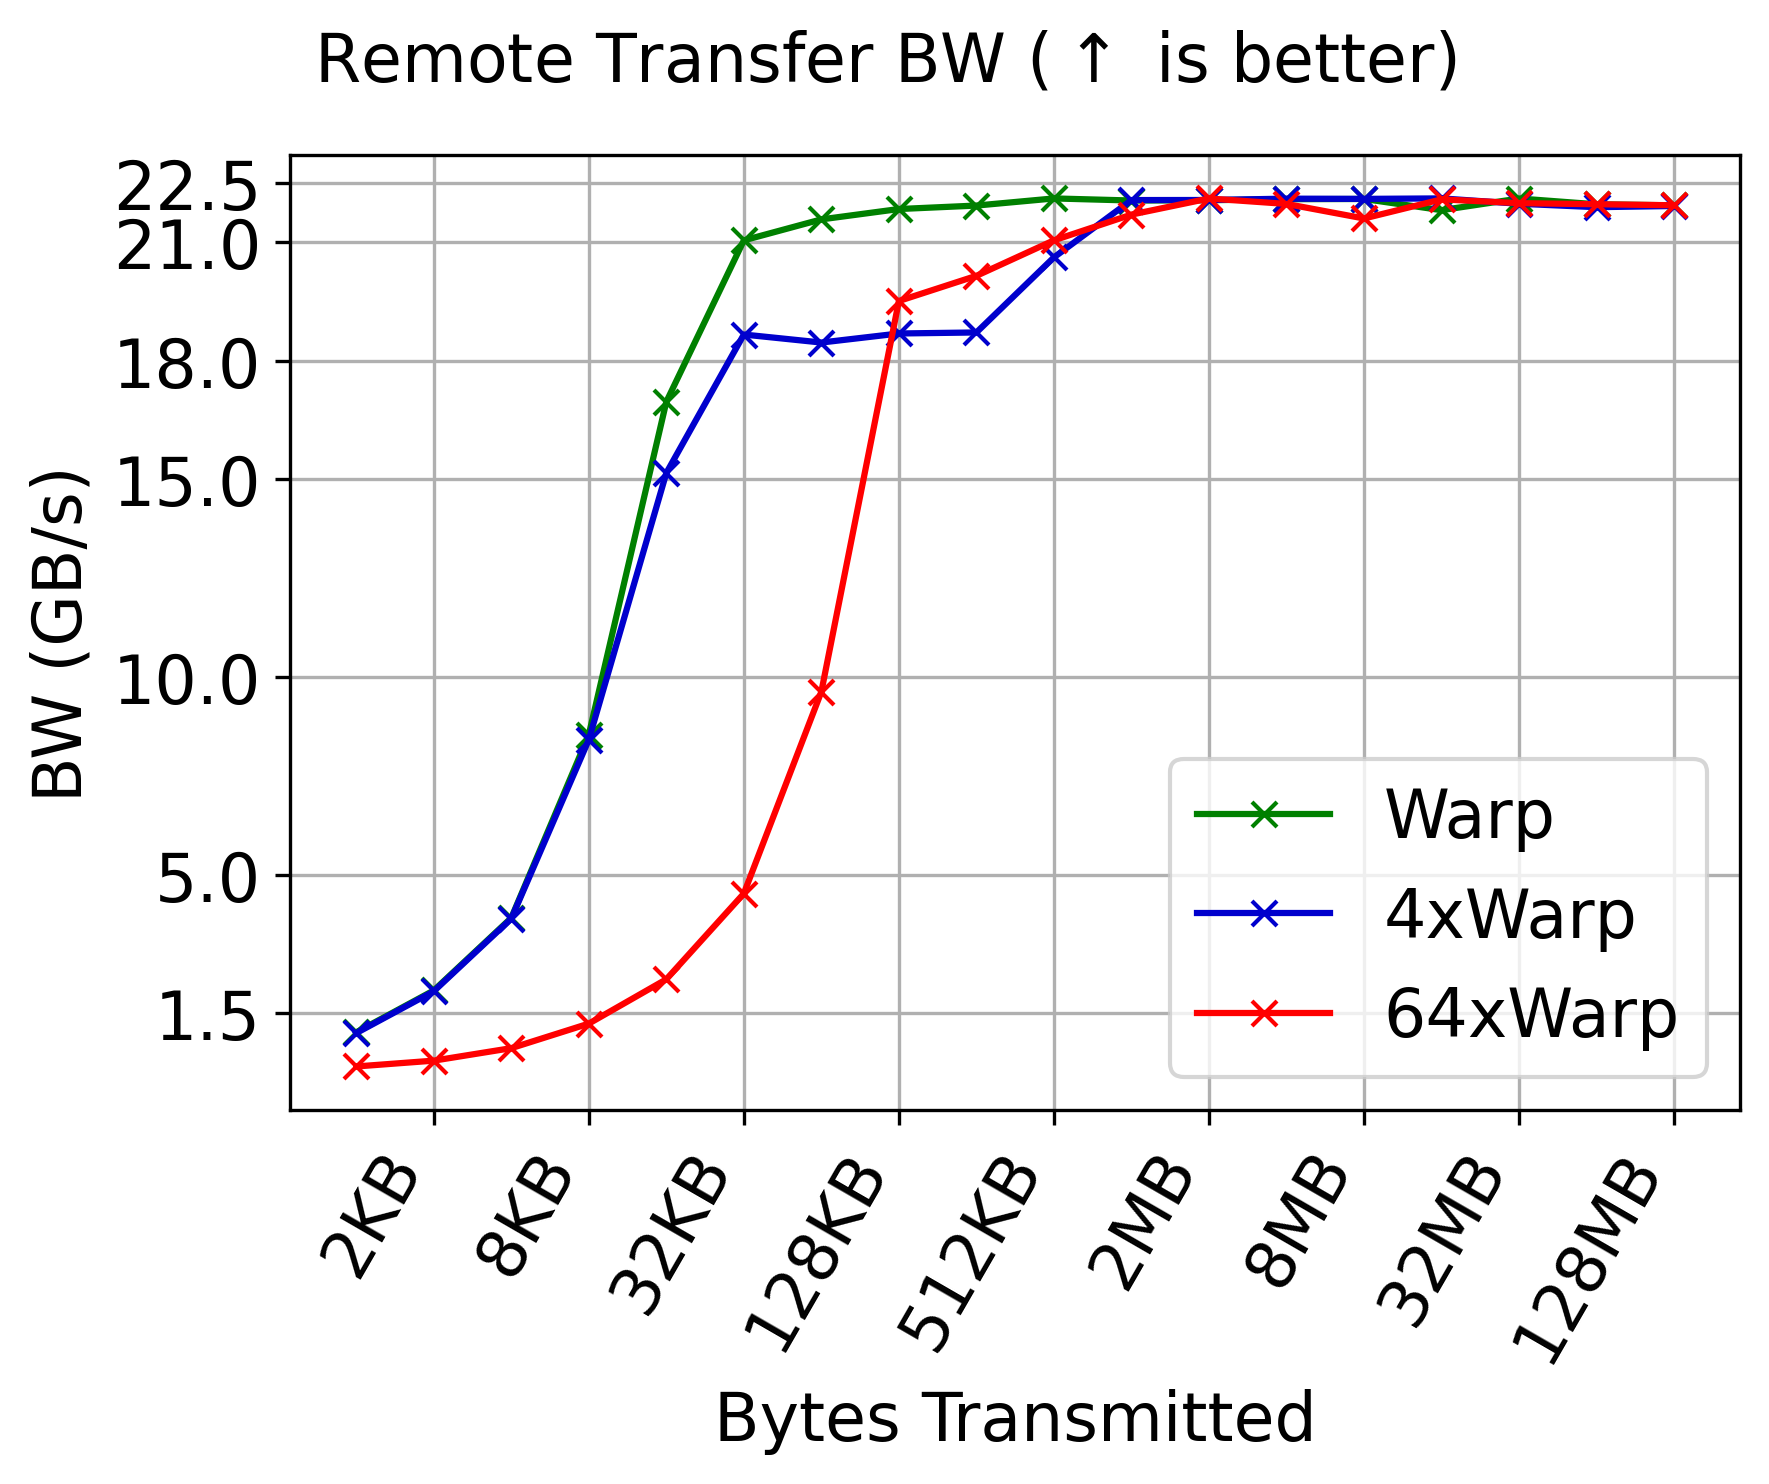

In [52]:
single_plot(warp_transfer_bytes, 
            [warp_transfer_lat, block_transfer_lat, super_transfer_lat], 
            header=r"Remote Transfer BW ($\uparrow$ is better)", 
            x_title="Bytes Transmitted", y_title="BW (GB/s)",
            out_name="remote_transfer.pdf", n_plots=3,
            labels=[r"Warp", r"4xWarp", r"64xWarp"], color=["green", "mediumblue", "red"], 
            plot_marker="x", x_rotation=60, x_func_formatter=fmt_bytes, x_scale='log', y_ticks=[1.5, 5, 10, 15, 18, 21, 22.5],
            header_font_size=16, axis_font_size=16)

## Block Specialization Microbenchmark

In [91]:
nv_block_bytes, nv_block_lat = parse_nvshmem_times("data/transfers/artefacts/nvlink_transfer_2048.txt",
                                                          delimiter_regex=r"[^(\s+)\|]+",skip=9,read_limit=18)
nv_block_bytes.pop(6)
nv_block_bytes.pop(6)
nv_block_lat.pop(6)
nv_block_lat.pop(6)
print(nv_block_bytes)

['1024', '2.752194']
['2048', '5.756883']
['4096', '11.447434']
['8192', '23.608919']
['16384', '46.915897']
['32768', '89.981155']
['65536', '72.121010']
['131072', '71.392235']
['262144', '76.981461']
['524288', '78.403275']
['1048576', '79.549652']
['2097152', '71.291351']
['4194304', '69.564728']
['8388608', '68.148743']
['16777216', '68.507782']
['33554432', '68.539055']
['67108864', '62.921406']
['134217728', '62.425304']
[1024, 2048, 4096, 8192, 16384, 32768, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728]


In [92]:
nv_block_2_bytes, nv_block_2_lat = parse_nvshmem_times("data/transfers/artefacts/nvlink_transfer_4096.txt",
                                                          delimiter_regex=r"[^(\s+)\|]+",skip=9,read_limit=18)
nv_block_2_lat.pop(6)
nv_block_2_lat.pop(6)
print(nv_block_2_lat)

['1024', '2.864609']
['2048', '5.754104']
['4096', '11.541631']
['8192', '22.938919']
['16384', '47.382030']
['32768', '89.642891']
['65536', '173.103500']
['131072', '77.395294']
['262144', '79.375870']
['524288', '81.066696']
['1048576', '82.205338']
['2097152', '82.474670']
['4194304', '77.799973']
['8388608', '80.532478']
['16777216', '81.282448']
['33554432', '81.677551']
['67108864', '81.308075']
['134217728', '76.779533']
[2.864609, 5.754104, 11.541631, 22.938919, 47.38203, 89.642891, 79.37587, 81.066696, 82.205338, 82.47467, 77.799973, 80.532478, 81.282448, 81.677551, 81.308075, 76.779533]


In [93]:
nv_block_4_bytes, nv_block_4_lat = parse_nvshmem_times("data/transfers/artefacts/nvlink_transfer_8192.txt",
                                                          delimiter_regex=r"[^(\s+)\|]+",skip=9,read_limit=18)
nv_block_4_lat.pop(6)
nv_block_4_lat.pop(6)
print(nv_block_4_lat)

['1024', '2.853639']
['2048', '5.740252']
['4096', '11.502657']
['8192', '23.005314']
['16384', '45.767765']
['32768', '87.665466']
['65536', '171.162018']
['131072', '333.205353']
['262144', '79.782539']
['524288', '81.017197']
['1048576', '81.750656']
['2097152', '82.267937']
['4194304', '82.523735']
['8388608', '82.206993']
['16777216', '81.556244']
['33554432', '82.387535']
['67108864', '82.631203']
['134217728', '82.622200']
[2.853639, 5.740252, 11.502657, 23.005314, 45.767765, 87.665466, 79.782539, 81.017197, 81.750656, 82.267937, 82.523735, 82.206993, 81.556244, 82.387535, 82.631203, 82.6222]


In [94]:
print(nv_block_2_lat)
nv_warp_bytes, nv_warp_lat = parse_nvshmem_times("data/transfers/arte/nvlink_warp.txt",
                                                       delimiter_regex=r"[^(\s+)\|]+", skip=9, read_limit=18)
nv_warp_lat.pop(6)
nv_warp_lat.pop(6)

[2.864609, 5.754104, 11.541631, 22.938919, 47.38203, 89.642891, 79.37587, 81.066696, 82.205338, 82.47467, 77.799973, 80.532478, 81.282448, 81.677551, 81.308075, 76.779533]
['1024', '2.641228']
['2048', '4.025153']
['4096', '5.380191']
['8192', '6.467320']
['16384', '7.195234']
['32768', '7.625827']
['65536', '7.861370']
['131072', '2.538653']
['262144', '2.561384']
['524288', '2.564684']
['1048576', '2.566285']
['2097152', '2.567603']
['4194304', '2.570335']
['8388608', '2.569319']
['16777216', '2.568505']
['33554432', '1.394879']
['67108864', '1.090020']
['134217728', '1.090280']


2.538653

In [95]:
nv_b_bytes, nv_b_lat = parse_nvshmem_times("data/transfers/arte/nvlink_block.txt",
                                                       delimiter_regex=r"[^(\s+)\|]+", skip=9, read_limit=18)
nv_b_lat.pop(6)
nv_b_lat.pop(6)
print(nv_b_bytes)

['1024', '3.019885']
['2048', '6.039769']
['4096', '9.816799']
['8192', '14.884524']
['16384', '19.854296']
['32768', '23.836067']
['65536', '26.441202']
['131072', '8.262571']
['262144', '8.557045']
['524288', '8.657703']
['1048576', '8.704494']
['2097152', '8.782616']
['4194304', '8.844642']
['8388608', '8.845509']
['16777216', '8.832385']
['33554432', '5.229129']
['67108864', '4.006012']
['134217728', '3.997465']
[1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728]


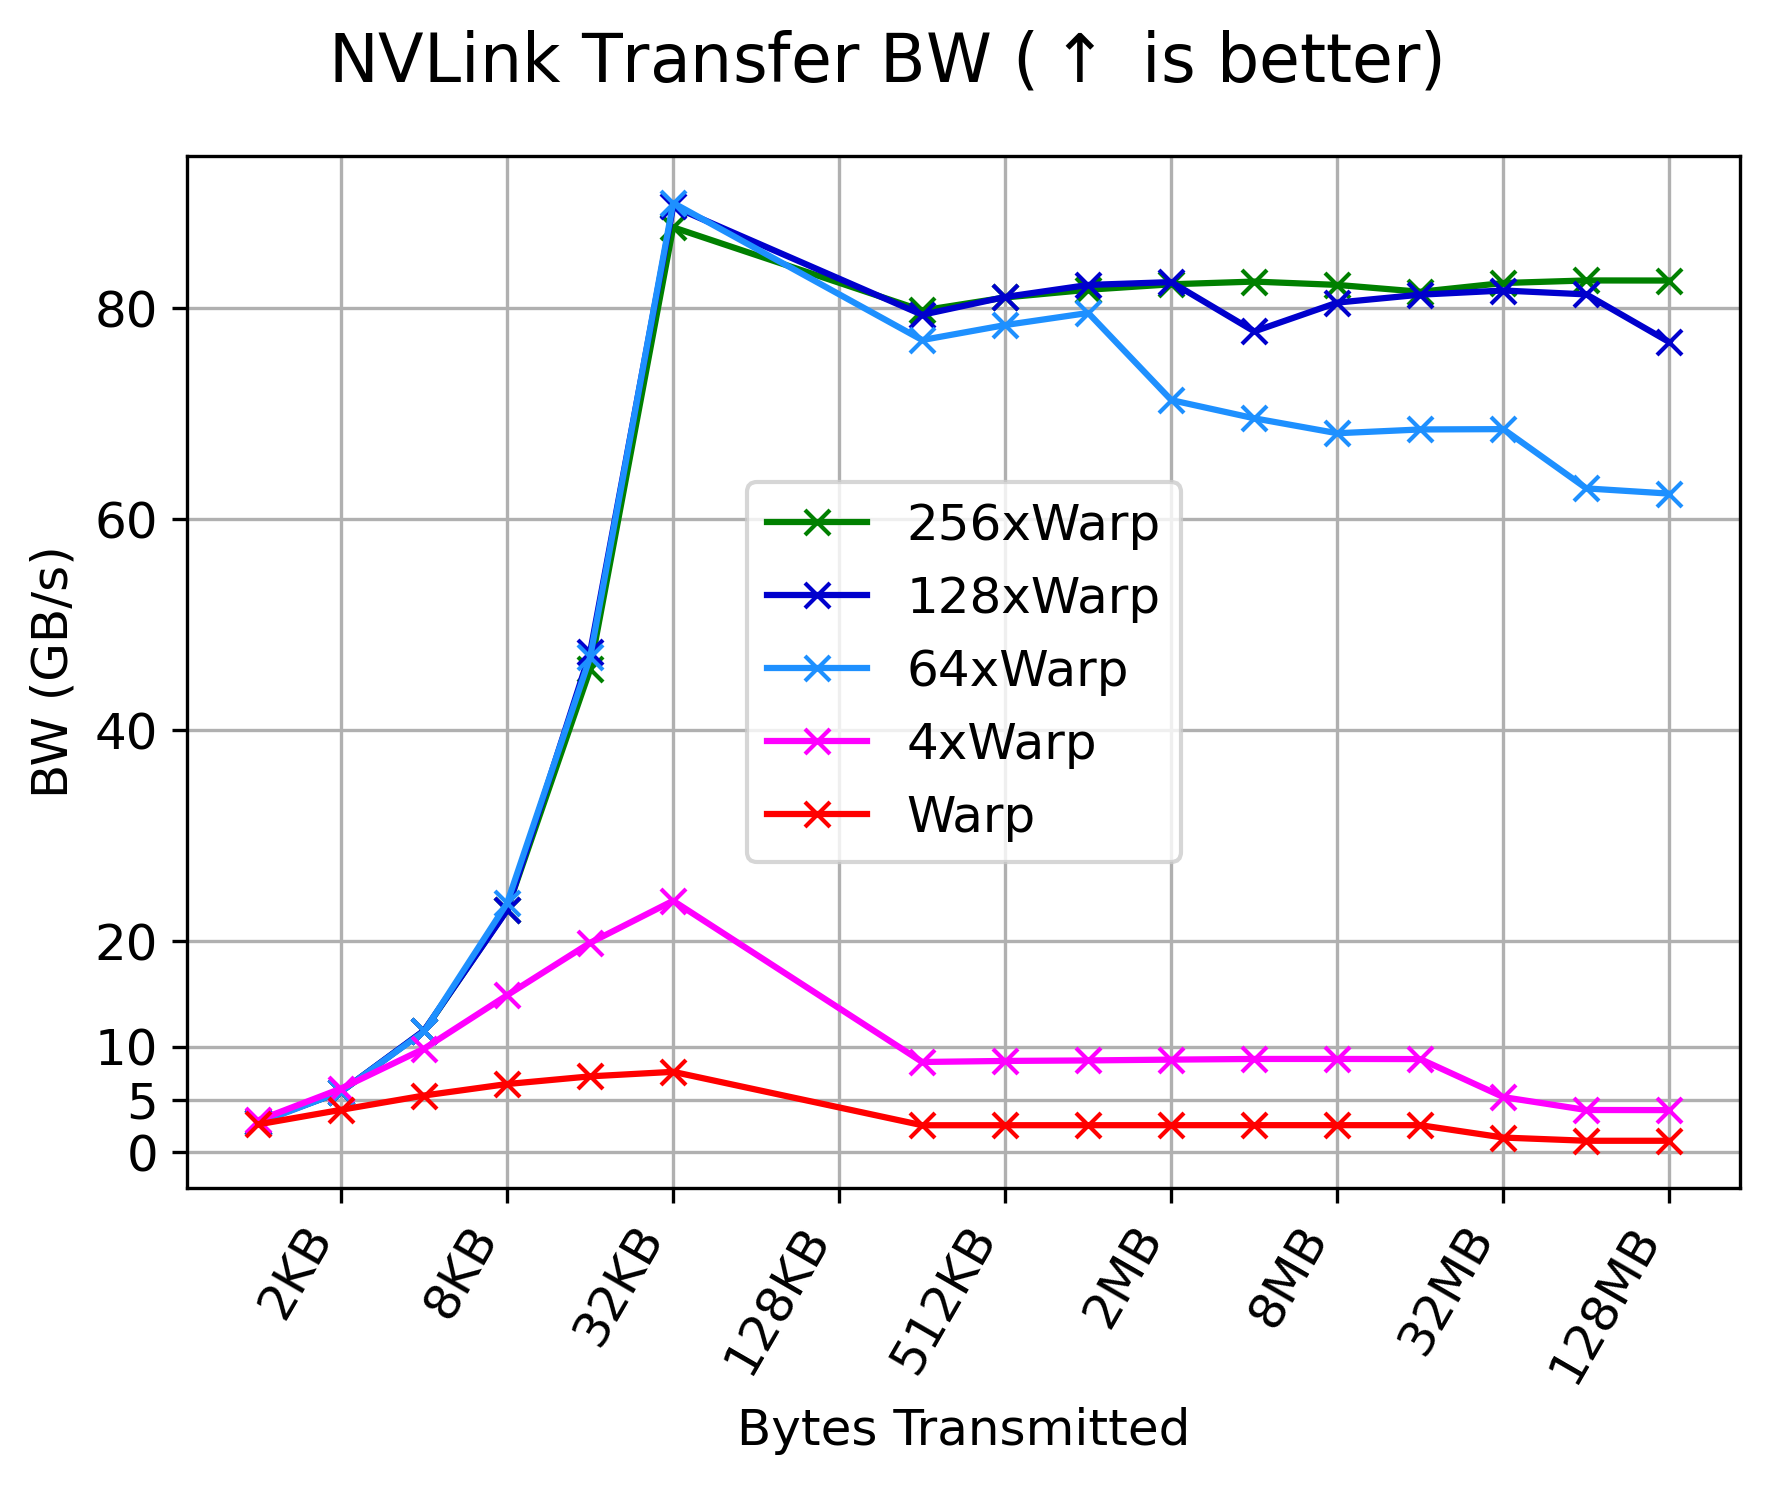

In [96]:
single_plot(nv_block_bytes, 
            [nv_block_4_lat, nv_block_2_lat, nv_block_lat, nv_b_lat, nv_warp_lat], 
            header=r"NVLink Transfer BW ($\uparrow$ is better)", 
            x_title="Bytes Transmitted", y_title="BW (GB/s)",
            out_name="nvlink_transfer.pdf", n_plots=5,
            labels=[r"256xWarp", r"128xWarp", r"64xWarp", r"4xWarp", r"Warp"], color=["green", "mediumblue", "dodgerblue", "magenta", "red"], 
            plot_marker = "x", x_rotation = 60, x_func_formatter = fmt_bytes, x_scale = 'log', header_font_size=16, axis_font_size=12,
            y_ticks=[0, 5, 10, 20, 40, 60, 80])